# Generación de red neural Long-Short Term Memory e hiperparametrización para nasdaq100.csv

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, LeakyReLU
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from keras import Input

2025-08-14 08:01:16.421455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755158476.614133      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755158476.671809      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the CSV file
def load_data(file_path):
    df = pd.read_csv(file_path, header=[0,1])
    # Primero quitamos la primera fila
    df = df.iloc[1:].copy()

    # Renombramos la columna de fechas bien
    new_cols = df.columns.tolist()
    new_cols[0] = ('Date', '')  # la primera columna será 'Date'
    df.columns = pd.MultiIndex.from_tuples(new_cols)

    # Ahora movemos 'Date' al índice o dejamos que sea columna:
    df = df.rename(columns={'': 'Date'}, level=0)  # si el nivel 1 tiene '' para Date


    return df

def preprocess_data(df, ticker, train_start='2020-01-01', train_end='2023-12-31',
                    test_start='2024-01-01', test_end='2024-12-31', sequence_length=60):
    # Filtrar datos del ticker
    df_ticker = df[ticker].copy()
    df_ticker['Date'] = df['Date']

    # Filtrar por fechas primero (evita fuga de datos)
    # df_ticker = df_ticker[(df_ticker['Date'] >= train_start) & (df_ticker['Date'] <= test_end)].reset_index(drop=True)

    # Calcular log-returns de las features
    features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df_ticker[features] = df_ticker[features].replace(0, np.nan)  # replace 0 with nan
    # df_ticker[features] = np.log(df_ticker[features]).diff()
    df_ticker = df_ticker.dropna().reset_index(drop=True)

    # Crear target: next day's Close
    df_ticker['Close_next'] = df_ticker['Close'].shift(-1)
    df_ticker['Direction_next'] = (df_ticker['Close_next'] > df_ticker['Close']).astype(int)

    # Eliminar filas con NaN
    df_ticker = df_ticker.dropna().reset_index(drop=True)

    # Escalar features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_ticker[features])
    # data_scaled = df_ticker[features]

    # Separar train/test
    train_mask = (df_ticker['Date'] >= train_start) & (df_ticker['Date'] <= train_end)
    test_mask  = (df_ticker['Date'] >= test_start)  & (df_ticker['Date'] <= test_end)

    train_data = data_scaled[train_mask]
    test_data  = data_scaled[test_mask]

    train_labels = df_ticker.loc[train_mask, 'Close_next'].values
    test_labels  = df_ticker.loc[test_mask, 'Close_next'].values

    # Crear secuencias
    X_train, y_train = create_sequences(train_data, train_labels, sequence_length)
    X_test,  y_test  = create_sequences(test_data,  test_labels,  sequence_length)

    return X_train, y_train, X_test, y_test, scaler

def create_sequences(data, labels, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(labels[i])
    return np.array(X), np.array(y)


def build_lstm_model(sequence_length, n_features):
    """
    Build an LSTM model for predicting financial returns.
    """

    model = Sequential([
        Input(shape=(sequence_length, n_features)),
        LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        LSTM(64, kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        Dense(64, kernel_regularizer=l2(1e-5)),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dense(64, kernel_regularizer=l2(1e-5)),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dense(64, kernel_regularizer=l2(1e-5)),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dense(64, kernel_regularizer=l2(1e-5)),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(0.35),
        Dense(1, activation='linear')
    ])

    return model

# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_pred_binary = (pd.Series(y_pred.flatten()).diff() >= 0).astype(int).iloc[1:] # Remove the first element
    y_test_binary = (pd.Series(y_test).diff() >= 0).astype(int).iloc[1:]         # Remove the first element

    accuracy = accuracy_score(y_test_binary,y_pred_binary)
    precision = precision_score(y_test_binary, y_pred_binary)
    recall = recall_score(y_test_binary, y_pred_binary)
    f1 = f1_score(y_test_binary, y_pred_binary)
    # Estimate the RMSE
    rmse = np.sqrt(np.mean((y_test - y_pred.flatten()) ** 2))


    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"RMSE: {rmse:.6f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return accuracy, precision, recall, f1, rmse

In [5]:
def execute_training_tickers(ticker,sequence_length):
    print("/--------------------------------------------------------------------/")
    print(ticker)
    print("/--------------------------------------------------------------------/")
    df = load_data(file_path)
    X_train, y_train, X_test, y_test, scaler = preprocess_data(
        df, ticker,
        train_start='2020-01-01', train_end='2023-12-31',
        test_start='2024-01-01', test_end='2024-12-31',
        sequence_length=sequence_length
    )

    # Build and train model
    model = build_lstm_model(sequence_length, X_train.shape[2])

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(
        monitor='val_mae',  # Switch to val_loss for smoother monitoring
        patience=50,         # Increase patience to allow recovery
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=25,          # Reduce patience to trigger sooner
        min_lr=1e-6,
        verbose=1
    )

    optimizer = Adam(learning_rate=0.001) # You can tune the learning rate
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=500,          # Increase epochs
        batch_size=16,       # Increase batch size
        validation_split=0.2,  # Increase validation split
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate model
    accuracy, precision, recall, f1, rmse = evaluate_model(model, X_test, y_test)

    # Predict and calculate residuals
    y_pred = model.predict(X_test).flatten()
    residuals = y_test - y_pred
    return accuracy, precision, recall, f1, rmse

    # Create the figure
    fig = go.Figure()

    # Add Actual values
    fig.add_trace(go.Scatter(
        y=y_test,
        mode='lines',
        name='Actual',
        line=dict(color='blue', width=2),
        opacity=0.6
    ))

    # Add Predicted values
    fig.add_trace(go.Scatter(
        y=y_pred,
        mode='lines',
        name='Predicted',
        line=dict(color='green', width=2),
        opacity=0.6
    ))

    # Update layout
    fig.update_layout(
        title='Comparison of Actual and Predicted',
        xaxis_title='Sample index',
        yaxis_title='Value',
        template='plotly_white'
    )

    # Show figure
    fig.show()


/--------------------------------------------------------------------/
FANG
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
I0000 00:00:1755158516.444032      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755158516.444808      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/500


I0000 00:00:1755158530.288470      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 9814.8818 - mae: 91.5090 - val_loss: 20750.2891 - val_mae: 143.5609 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9238.0918 - mae: 90.7403 - val_loss: 19900.9336 - val_mae: 140.5858 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8825.2256 - mae: 89.7207 - val_loss: 18709.7812 - val_mae: 136.3453 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8350.9219 - mae: 88.0669 - val_loss: 16885.0898 - val_mae: 129.5229 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7856.8818 - mae: 86.1744 - val_loss: 14835.3857 - val_mae: 121.3097 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7314.9224 - mae: 83.6224 - val_loss: 12981.1045 - val_mae: 113.5775 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6750.9175 - mae: 80.6711 - val_loss: 11

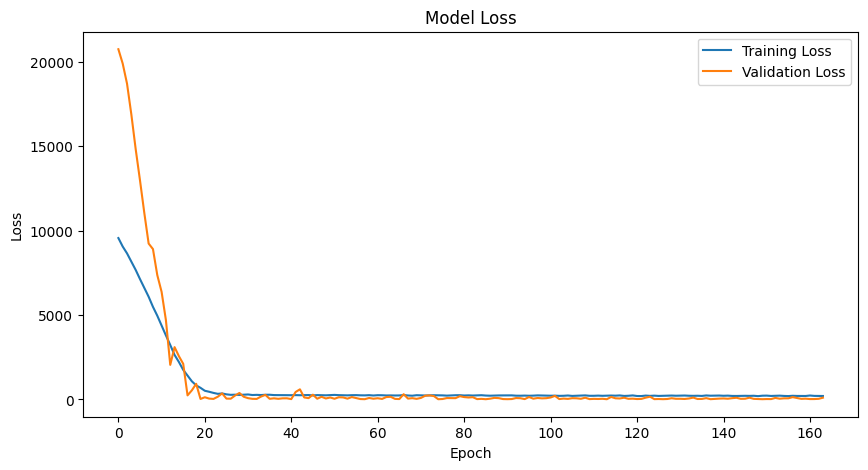

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Accuracy: 0.5246
Precision: 0.5781
Recall: 0.5441
F1-Score: 0.5606
RMSE: 22.037217


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


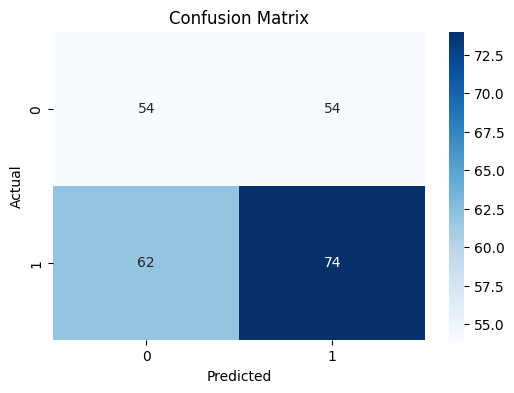

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.5245901639344263, 0.578125, 0.5441176470588235, 0.5606060606060606, 22.03721722121508)
/--------------------------------------------------------------------/
BKR
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 571.9990 - mae: 23.4089 - val_loss: 1029.9182 - val_mae: 31.9452 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 532.5132 - mae: 22.8841 - val_loss: 974.7432 - val_mae: 31.0788 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 500.9238 - mae: 22.2148 - val_loss: 914.2887 - val_mae: 30.1017 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 460.3889 - mae: 21.2174 - val_loss: 798.1157 - val_mae: 28.1546 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 407.3891 - mae: 19.9567 - val_loss: 555.7397 - val_mae: 23.5111 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 336.6581 - mae: 18.0304 - val_loss: 458.6082 - val_mae: 21.3509 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 262.1796 - mae: 15.8364 - val_loss: 379.6352 - val

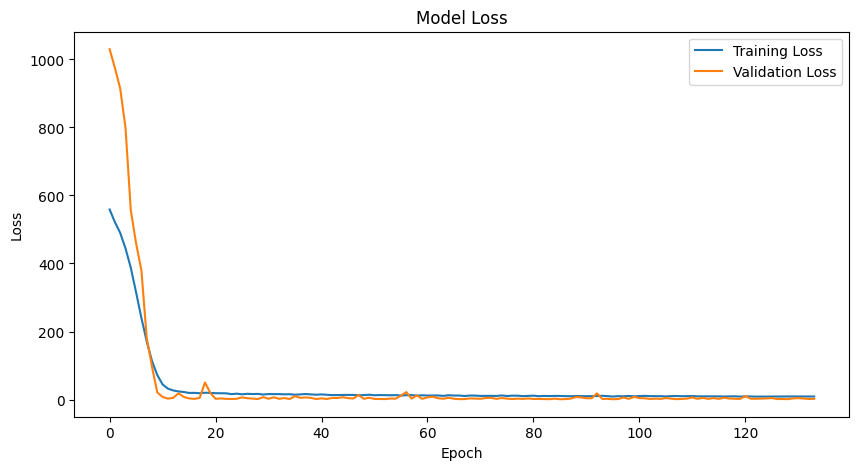

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Accuracy: 0.5082
Precision: 0.5124
Recall: 0.5041
F1-Score: 0.5082
RMSE: 2.252786


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


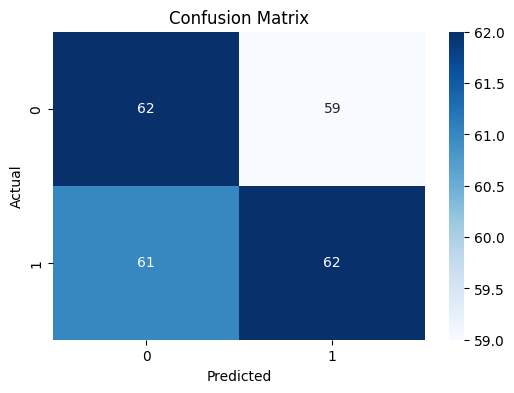

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5081967213114754, 0.512396694214876, 0.5040650406504065, 0.5081967213114754, 2.2527859955193574)
/--------------------------------------------------------------------/
CDNS
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 20398.8066 - mae: 139.1790 - val_loss: 55162.4961 - val_mae: 233.9541 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 19968.4746 - mae: 138.5495 - val_loss: 53992.3789 - val_mae: 231.4488 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 19499.8047 - mae: 137.5378 - val_loss: 52532.6328 - val_mae: 228.2969 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18997.1855 - mae: 136.2183 - val_loss: 49879.2930 - val_mae: 222.4517 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18344.7930 - mae: 134.2545 - val_loss: 45738.1875 - val_mae: 213.0273 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17649.5352 - mae: 131.8961 - val_loss: 42561.7148 - val_mae: 205.5008 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16815.5820 - ma

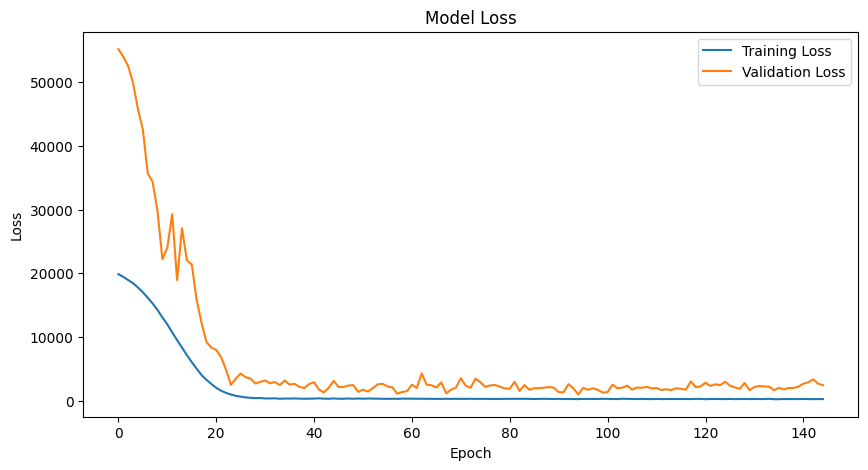

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
Accuracy: 0.5410
Precision: 0.5469
Recall: 0.5645
F1-Score: 0.5556
RMSE: 85.658883


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


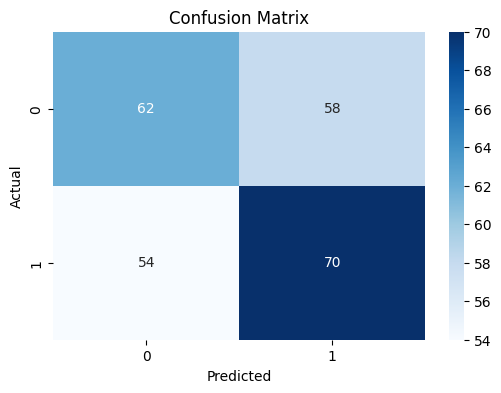

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5409836065573771, 0.546875, 0.5645161290322581, 0.5555555555555557, 85.65888320142172)
/--------------------------------------------------------------------/
CSCO
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 2354.5039 - mae: 48.1761 - val_loss: 2571.2925 - val_mae: 50.6338 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2271.0151 - mae: 47.4941 - val_loss: 2465.7214 - val_mae: 49.5856 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2207.6328 - mae: 46.8629 - val_loss: 2297.1252 - val_mae: 47.8639 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2114.6035 - mae: 45.8806 - val_loss: 2078.8042 - val_mae: 45.5385 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1963.5499 - mae: 44.1691 - val_loss: 2020.5092 - val_mae: 44.8785 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1805.8059 - mae: 42.3283 - val_loss: 1760.6606 - val_mae: 41.8984 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1575.6244 - mae: 39.4496 - val_loss: 14

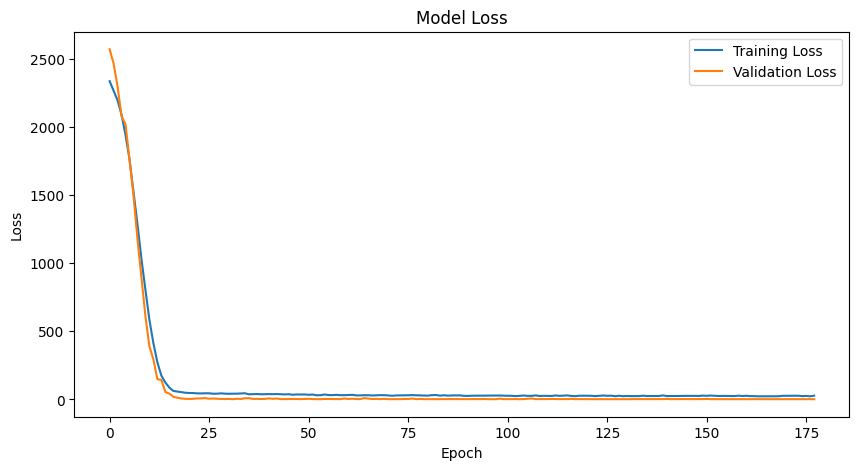

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Accuracy: 0.5410
Precision: 0.5854
Recall: 0.5414
F1-Score: 0.5625
RMSE: 1.180957


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


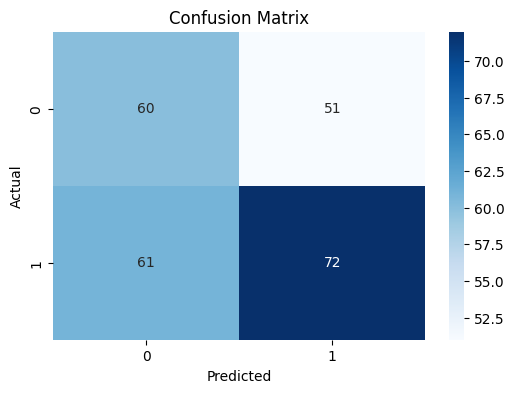

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5409836065573771, 0.5853658536585366, 0.5413533834586466, 0.5625, 1.180957106320607)
/--------------------------------------------------------------------/
MSTR
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 1684.0320 - mae: 35.9024 - val_loss: 1523.5745 - val_mae: 37.7716 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1432.0913 - mae: 35.2587 - val_loss: 1524.9512 - val_mae: 37.8024 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1291.4668 - mae: 34.1266 - val_loss: 1499.4597 - val_mae: 37.4854 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1182.2034 - mae: 32.9691 - val_loss: 1417.2388 - val_mae: 36.3800 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1043.8445 - mae: 31.1639 - val_loss: 1359.5010 - val_mae: 35.7211 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 929.1636 - mae: 29.3039 - val_loss: 1158.7263 - val_mae: 32.9106 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 817.9808 - mae: 27.2482 - val_loss: 885.

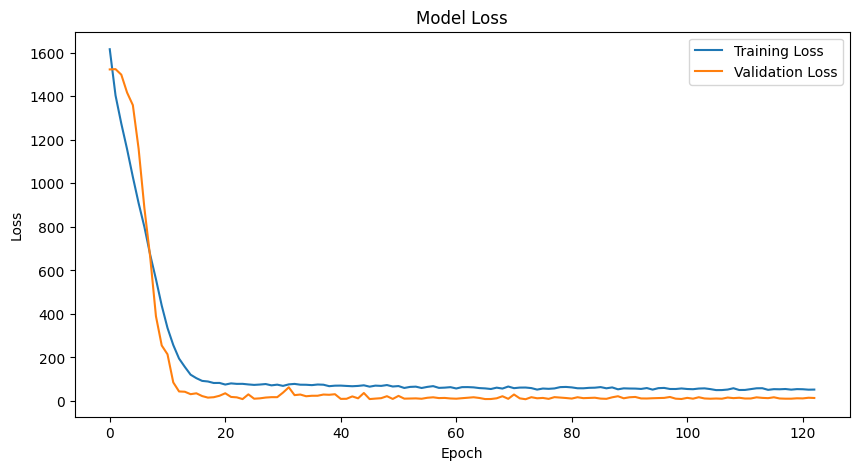

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.5041
Precision: 0.5083
Recall: 0.4959
F1-Score: 0.5021
RMSE: 124.394575


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


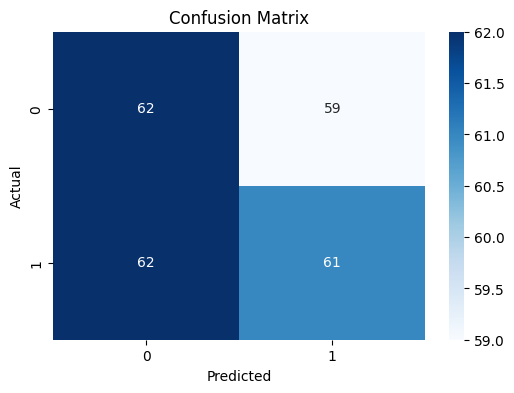

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5040983606557377, 0.5083333333333333, 0.4959349593495935, 0.5020576131687242, 124.394575286462)
/--------------------------------------------------------------------/
GOOG
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 11425.4775 - mae: 104.3325 - val_loss: 15683.0859 - val_mae: 124.6843 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 11058.6309 - mae: 103.5306 - val_loss: 15095.8643 - val_mae: 122.3251 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 10735.4463 - mae: 102.5563 - val_loss: 14440.1953 - val_mae: 119.6662 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 10384.3721 - mae: 101.1616 - val_loss: 13681.3320 - val_mae: 116.5238 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9964.7773 - mae: 99.2813 - val_loss: 12763.8057 - val_mae: 112.6179 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9482.6816 - mae: 96.9265 - val_loss: 11625.2422 - val_mae: 107.5697 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8940.9365 - mae: 94

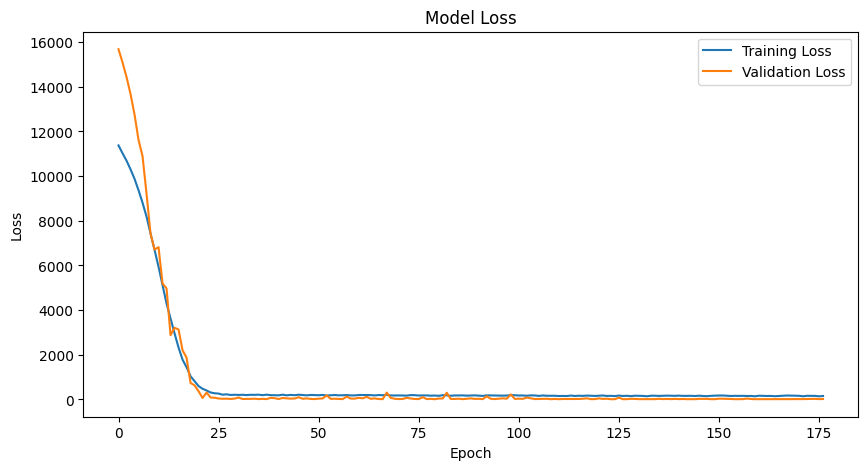

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Accuracy: 0.4713
Precision: 0.5683
Recall: 0.5338
F1-Score: 0.5505
RMSE: 9.337789


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


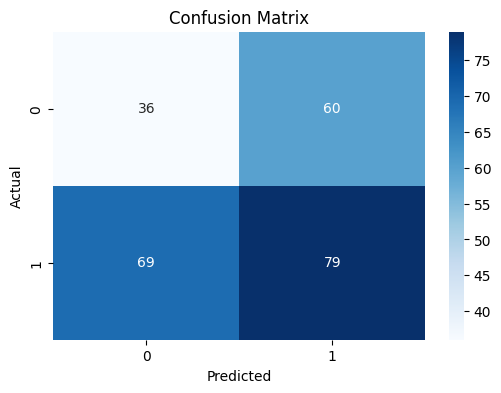

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4713114754098361, 0.5683453237410072, 0.5337837837837838, 0.5505226480836237, 9.337789218308584)
/--------------------------------------------------------------------/
FTNT
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 2163.0066 - mae: 44.4410 - val_loss: 3956.0701 - val_mae: 62.4278 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1992.3180 - mae: 43.7666 - val_loss: 3760.8572 - val_mae: 60.8601 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1885.3478 - mae: 42.8631 - val_loss: 3351.1189 - val_mae: 57.4356 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1775.2363 - mae: 41.6920 - val_loss: 2873.3276 - val_mae: 53.1727 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1637.8579 - mae: 40.0390 - val_loss: 2385.1057 - val_mae: 48.3719 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1475.6088 - mae: 37.9487 - val_loss: 2242.3235 - val_mae: 46.8268 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1299.8287 - mae: 35.5424 - val_loss: 17

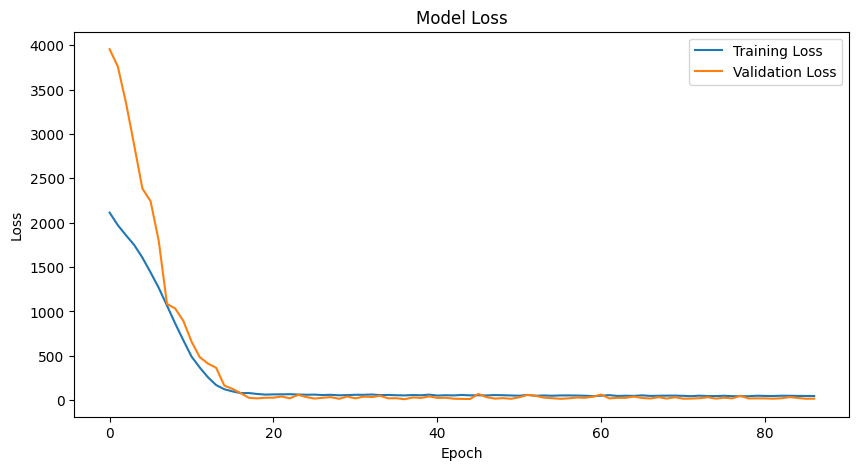

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Accuracy: 0.4836
Precision: 0.5323
Recall: 0.4925
F1-Score: 0.5116
RMSE: 9.463820


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


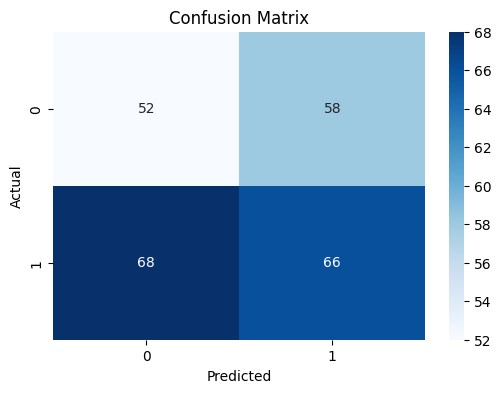

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.48360655737704916, 0.532258064516129, 0.4925373134328358, 0.5116279069767442, 9.463819686312517)
/--------------------------------------------------------------------/
NVDA
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 295.8803 - mae: 16.3090 - val_loss: 1641.6792 - val_mae: 39.7648 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 259.5382 - mae: 15.7959 - val_loss: 1534.2493 - val_mae: 38.4132 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 237.4173 - mae: 15.0860 - val_loss: 1422.9982 - val_mae: 37.0129 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 208.7985 - mae: 14.0930 - val_loss: 1282.3492 - val_mae: 35.1852 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 176.2926 - mae: 12.9021 - val_loss: 1163.5442 - val_mae: 33.4777 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 135.4081 - mae: 11.1985 - val_loss: 869.2241 - val_mae: 28.9803 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 101.4852 - mae: 9.4612 - val_loss: 588.4216 - 

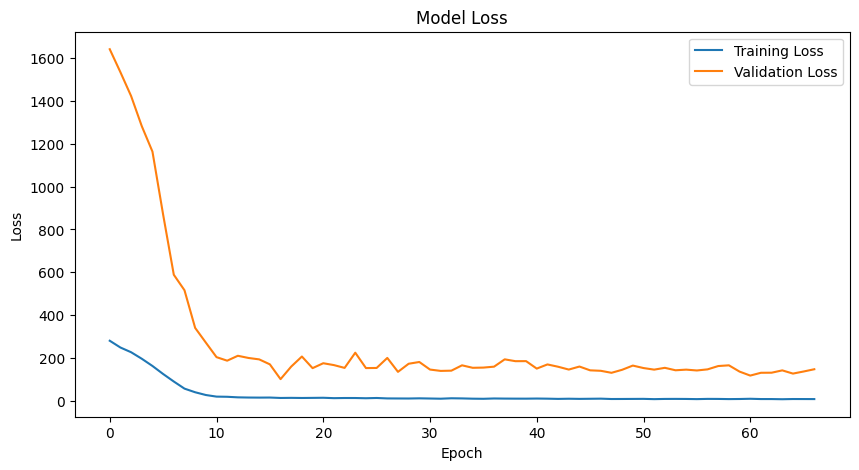

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
Accuracy: 0.4836
Precision: 0.5391
Recall: 0.4593
F1-Score: 0.4960
RMSE: 80.338674


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


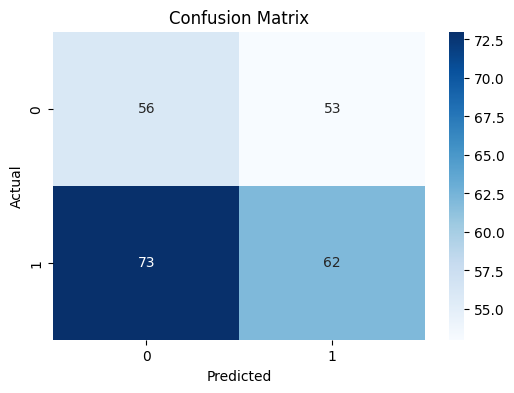

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.48360655737704916, 0.5391304347826087, 0.45925925925925926, 0.496, 80.33867434631391)
/--------------------------------------------------------------------/
TTD
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 4056.4512 - mae: 60.9999 - val_loss: 5303.7583 - val_mae: 72.3486 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3842.8528 - mae: 60.4597 - val_loss: 5112.8643 - val_mae: 71.0339 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3660.6904 - mae: 59.4625 - val_loss: 4834.3984 - val_mae: 69.0925 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3500.1987 - mae: 58.3615 - val_loss: 4282.8140 - val_mae: 65.0533 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3249.1570 - mae: 56.2972 - val_loss: 3854.8088 - val_mae: 61.7599 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3028.1956 - mae: 54.3008 - val_loss: 3216.4829 - val_mae: 56.5391 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2753.8462 - mae: 51.8108 - val_loss: 31

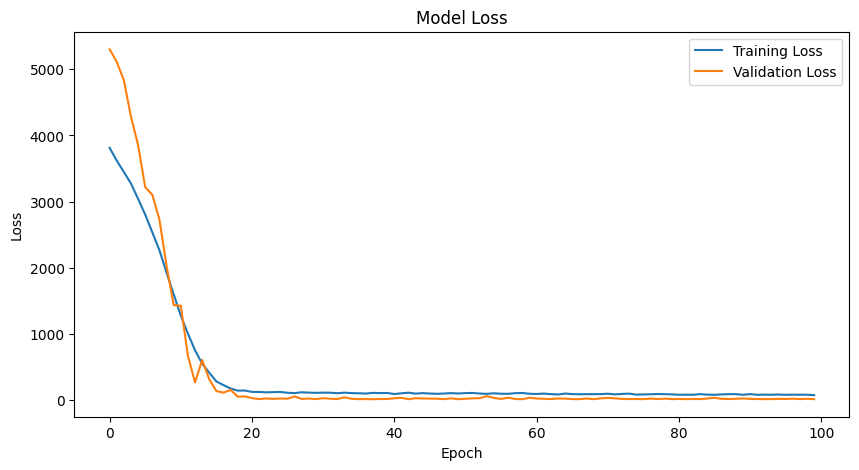

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Accuracy: 0.5164
Precision: 0.5571
Recall: 0.5821
F1-Score: 0.5693
RMSE: 13.427887


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


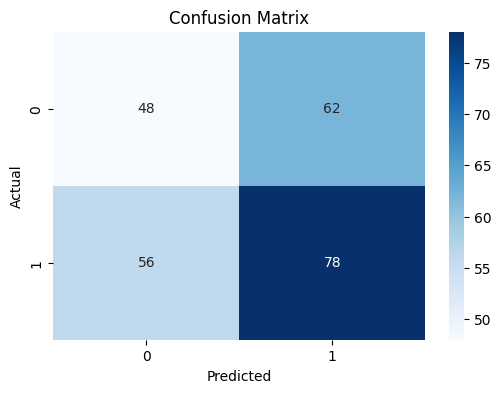

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.5163934426229508, 0.5571428571428572, 0.582089552238806, 0.5693430656934307, 13.427887071486266)
/--------------------------------------------------------------------/
GOOGL
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 11307.8643 - mae: 103.7089 - val_loss: 15537.5762 - val_mae: 124.1212 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 10979.3818 - mae: 103.0700 - val_loss: 15276.0498 - val_mae: 123.0925 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 10675.4639 - mae: 102.1395 - val_loss: 14809.3457 - val_mae: 121.2640 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 10350.1426 - mae: 100.8717 - val_loss: 14057.4336 - val_mae: 118.2614 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9956.5303 - mae: 99.1542 - val_loss: 12228.8408 - val_mae: 110.3686 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9447.7168 - mae: 96.6815 - val_loss: 11716.9219 - val_mae: 108.0369 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8927.5293 - mae: 94

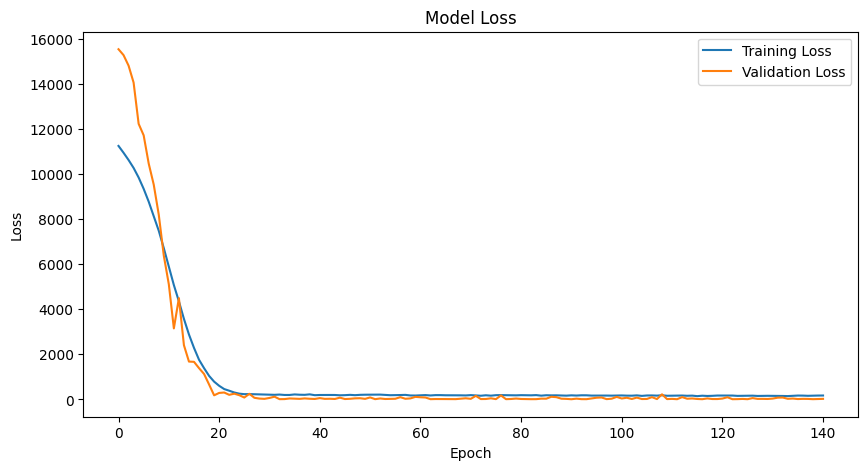

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.4959
Precision: 0.5906
Recall: 0.5137
F1-Score: 0.5495
RMSE: 21.148319


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


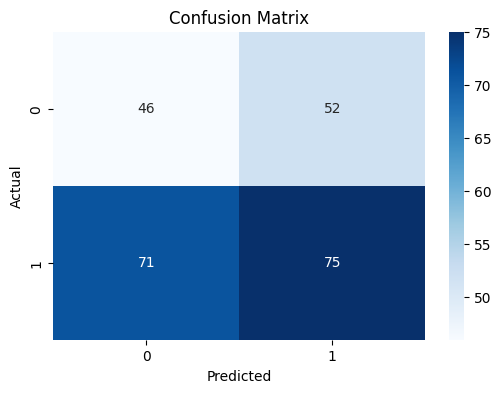

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4959016393442623, 0.5905511811023622, 0.5136986301369864, 0.5494505494505495, 21.148318634724333)
/--------------------------------------------------------------------/
ODFL
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 16520.4980 - mae: 124.7723 - val_loss: 34738.2148 - val_mae: 185.3195 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16052.1699 - mae: 124.1292 - val_loss: 33787.3203 - val_mae: 182.7552 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15674.4033 - mae: 123.3209 - val_loss: 32360.4023 - val_mae: 178.8397 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15187.1836 - mae: 121.8191 - val_loss: 30762.9453 - val_mae: 174.3707 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 14623.4648 - mae: 119.8587 - val_loss: 28321.2266 - val_mae: 167.3021 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 13967.8506 - mae: 117.3948 - val_loss: 25802.3477 - val_mae: 159.7541 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 13311.5889 - ma

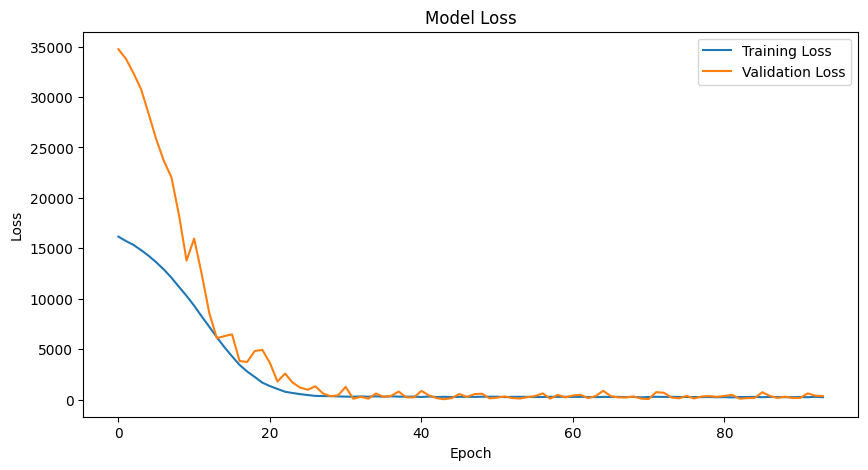

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Accuracy: 0.4754
Precision: 0.5000
Recall: 0.5234
F1-Score: 0.5115
RMSE: 9.701861


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


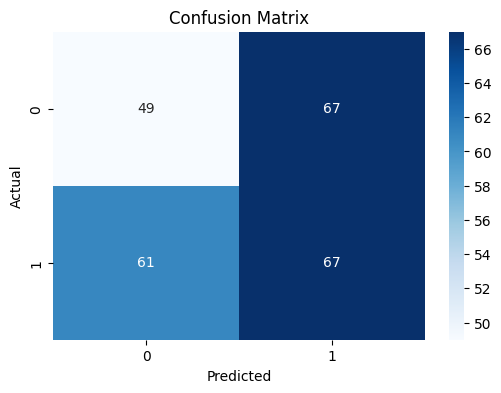

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.47540983606557374, 0.5, 0.5234375, 0.5114503816793893, 9.701860538445045)
/--------------------------------------------------------------------/
ADP
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 40081.7617 - mae: 197.1889 - val_loss: 52672.1797 - val_mae: 229.0690 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 39579.1953 - mae: 196.5639 - val_loss: 51937.7852 - val_mae: 227.4679 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 39014.3086 - mae: 195.5989 - val_loss: 50863.3281 - val_mae: 225.1177 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 38289.1523 - mae: 194.2028 - val_loss: 49683.2695 - val_mae: 222.5014 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 37489.8359 - mae: 192.4449 - val_loss: 47894.5859 - val_mae: 218.4650 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 36360.1484 - mae: 189.8144 - val_loss: 42982.3047 - val_mae: 207.1059 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 35176.0938 - ma

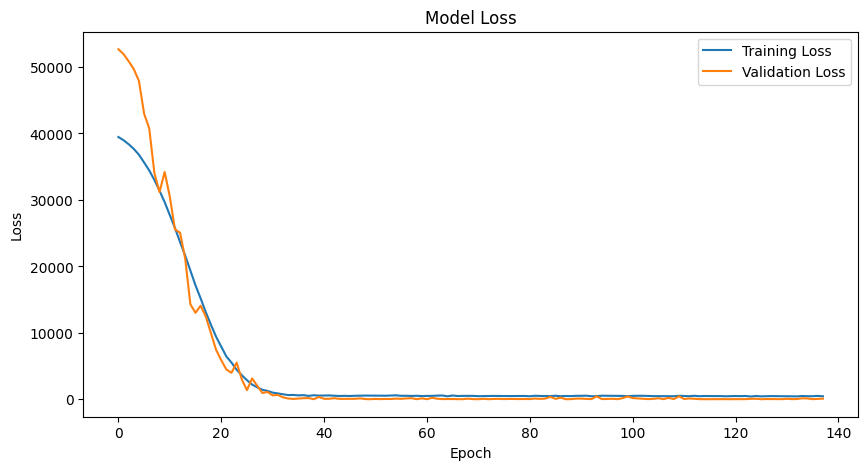

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
Accuracy: 0.4959
Precision: 0.5407
Recall: 0.5448
F1-Score: 0.5428
RMSE: 9.566304


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


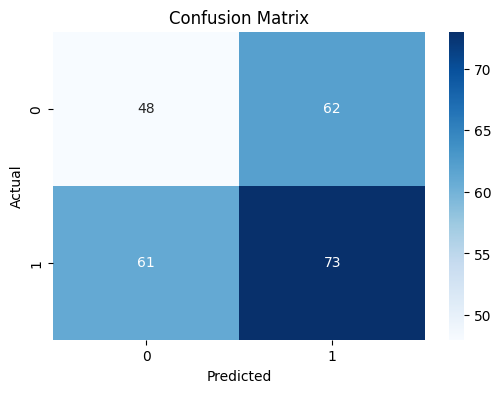

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.4959016393442623, 0.5407407407407407, 0.5447761194029851, 0.5427509293680298, 9.56630411293971)
/--------------------------------------------------------------------/
MCHP
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 4629.1387 - mae: 67.1584 - val_loss: 6538.2959 - val_mae: 80.6687 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4503.1821 - mae: 66.6133 - val_loss: 6368.1235 - val_mae: 79.6109 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4377.0918 - mae: 65.8167 - val_loss: 6035.4653 - val_mae: 77.5077 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4229.3745 - mae: 64.7551 - val_loss: 5437.7891 - val_mae: 73.5916 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4008.3760 - mae: 63.0566 - val_loss: 4711.2603 - val_mae: 68.4525 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3747.4556 - mae: 60.9381 - val_loss: 4239.6802 - val_mae: 64.9880 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3430.8506 - mae: 58.2151 - val_loss: 39

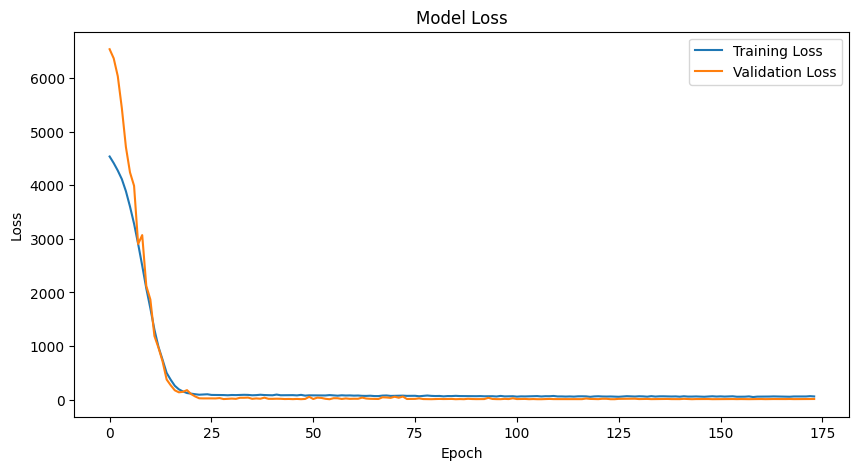

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Accuracy: 0.5451
Precision: 0.5469
Recall: 0.5691
F1-Score: 0.5578
RMSE: 3.898460


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


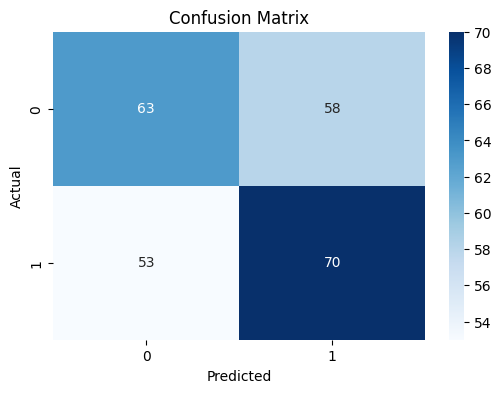

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5450819672131147, 0.546875, 0.5691056910569106, 0.5577689243027888, 3.8984598785709834)
/--------------------------------------------------------------------/
XEL
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 4605.1782 - mae: 67.7500 - val_loss: 3840.3379 - val_mae: 61.8370 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4536.2544 - mae: 67.2638 - val_loss: 3764.0820 - val_mae: 61.2274 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4433.6270 - mae: 66.5029 - val_loss: 3652.5459 - val_mae: 60.3276 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4309.5835 - mae: 65.5694 - val_loss: 3629.0852 - val_mae: 60.1519 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4105.4438 - mae: 63.9760 - val_loss: 3372.8916 - val_mae: 57.9927 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3850.8467 - mae: 61.9516 - val_loss: 3038.8689 - val_mae: 55.0432 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3507.9167 - mae: 59.1129 - val_loss: 27

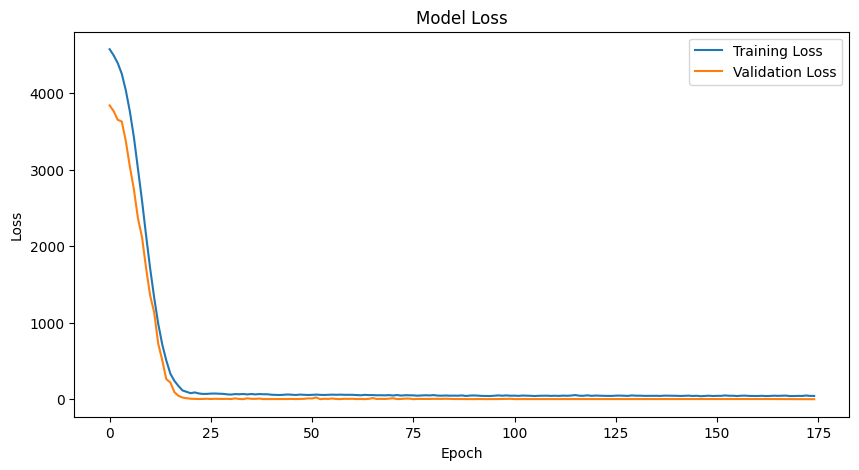

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Accuracy: 0.5082
Precision: 0.5414
Recall: 0.5496
F1-Score: 0.5455
RMSE: 2.639318


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


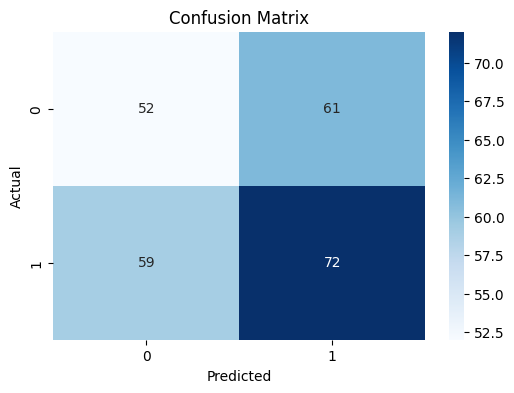

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.5081967213114754, 0.5413533834586466, 0.549618320610687, 0.5454545454545454, 2.6393183004266683)
/--------------------------------------------------------------------/
ABNB
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - loss: 21203.0176 - mae: 142.2176 - val_loss: 17264.2051 - val_mae: 130.9596 - learning_rate: 0.0010
Epoch 2/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 20871.6699 - mae: 141.6715 - val_loss: 17200.6094 - val_mae: 130.7248 - learning_rate: 0.0010
Epoch 3/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 20575.4199 - mae: 141.1150 - val_loss: 17186.9473 - val_mae: 130.6918 - learning_rate: 0.0010
Epoch 4/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 20296.0508 - mae: 140.3927 - val_loss: 17221.5059 - val_mae: 130.8851 - learning_rate: 0.0010
Epoch 5/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 19885.2949 - mae: 139.3103 - val_loss: 17308.4980 - val_mae: 131.2999 - learning_rate: 0.0010
Epoch 6/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 19404.5273 - mae: 137.8822 - val_loss: 17518.1465 - val_mae: 132.1649 - learning_rate: 0.0010
Epoch 7/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 18894.6504 - ma

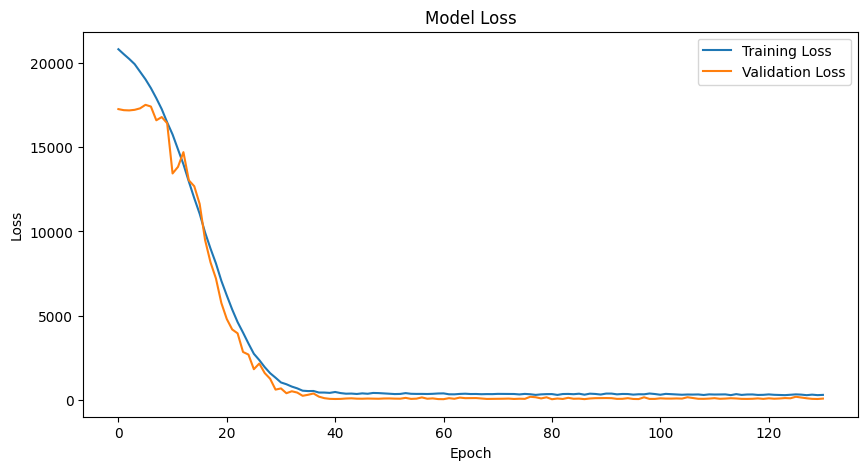

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Accuracy: 0.4959
Precision: 0.5234
Recall: 0.5194
F1-Score: 0.5214
RMSE: 7.722930


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


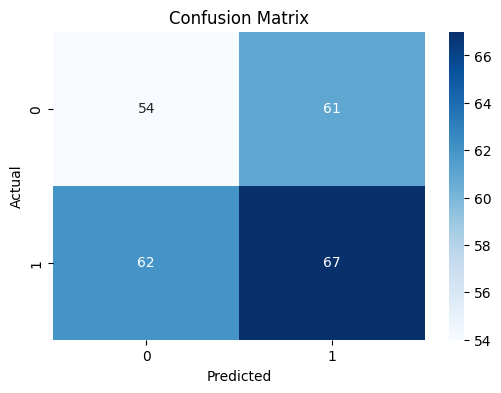

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4959016393442623, 0.5234375, 0.5193798449612403, 0.5214007782101168, 7.722930033505953)
/--------------------------------------------------------------------/
ADI
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 22923.2363 - mae: 149.7816 - val_loss: 33291.1953 - val_mae: 182.2221 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 22645.0176 - mae: 149.2193 - val_loss: 32830.1797 - val_mae: 180.9570 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 22281.5996 - mae: 148.3510 - val_loss: 32063.4824 - val_mae: 178.8291 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 21905.9277 - mae: 147.2890 - val_loss: 30395.1211 - val_mae: 174.1053 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 21341.2070 - mae: 145.5437 - val_loss: 28370.9883 - val_mae: 168.2566 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 20630.1504 - mae: 143.2292 - val_loss: 27021.7148 - val_mae: 164.2229 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 19779.6367 - ma

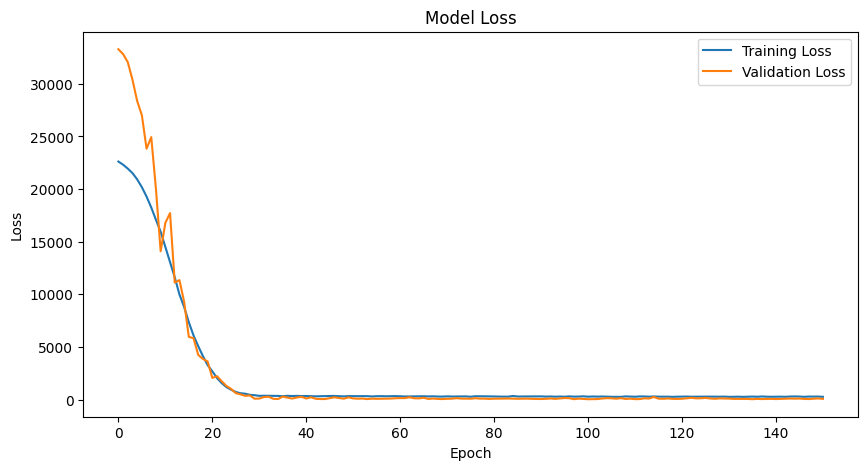

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Accuracy: 0.5000
Precision: 0.5185
Recall: 0.5512
F1-Score: 0.5344
RMSE: 31.005611


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


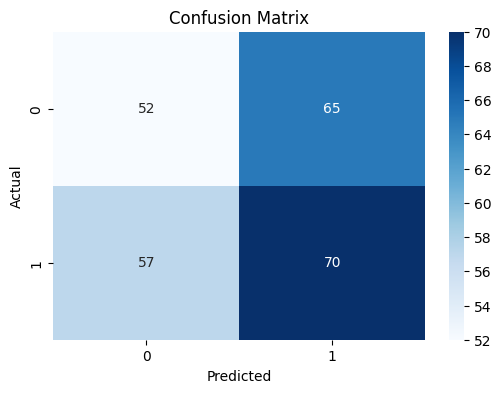

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5, 0.5185185185185185, 0.5511811023622047, 0.5343511450381679, 31.005611426947905)
/--------------------------------------------------------------------/
APP
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 2585.0232 - mae: 44.2231 - val_loss: 1341.3707 - val_mae: 36.1927 - learning_rate: 0.0010
Epoch 2/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2341.1384 - mae: 43.7973 - val_loss: 1316.5173 - val_mae: 35.8497 - learning_rate: 0.0010
Epoch 3/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2184.4109 - mae: 43.1697 - val_loss: 1317.2692 - val_mae: 35.8679 - learning_rate: 0.0010
Epoch 4/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2054.4299 - mae: 42.3751 - val_loss: 1291.4719 - val_mae: 35.5208 - learning_rate: 0.0010
Epoch 5/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1934.1016 - mae: 41.5792 - val_loss: 1247.7383 - val_mae: 34.9271 - learning_rate: 0.0010
Epoch 6/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1823.1301 - mae: 40.6848 - val_loss: 1173.0087 - val_mae: 33.8786 - learning_rate: 0.0010
Epoch 7/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1663.0330 - mae: 39.1305 - val_loss: 12

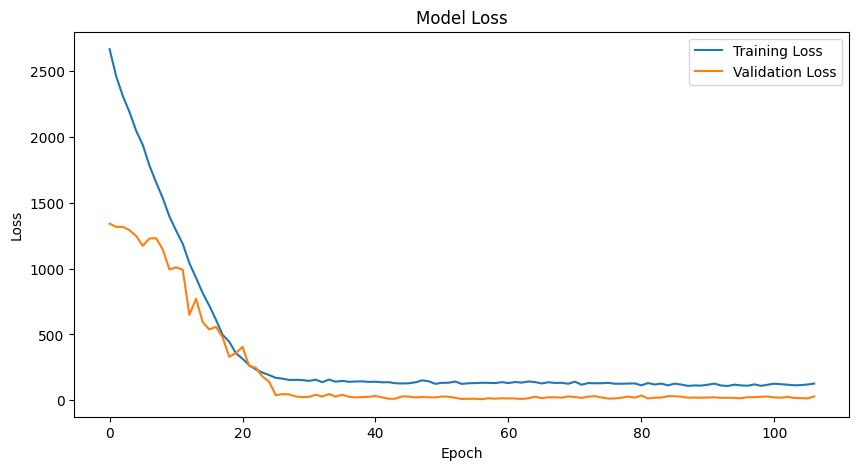

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.5164
Precision: 0.5769
Recall: 0.5435
F1-Score: 0.5597
RMSE: 85.406121


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


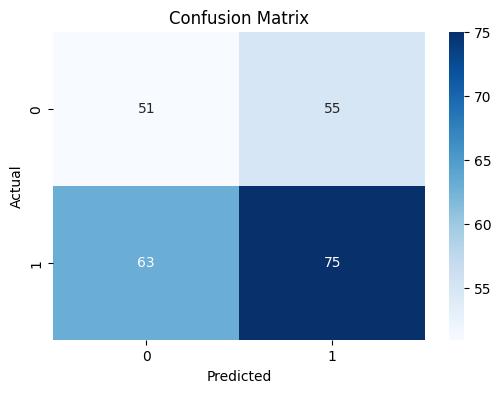

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5163934426229508, 0.5769230769230769, 0.5434782608695652, 0.5597014925373134, 85.40612124805283)
/--------------------------------------------------------------------/
BIIB
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 73085.9453 - mae: 267.1176 - val_loss: 73165.1328 - val_mae: 269.4925 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 72507.5156 - mae: 266.4624 - val_loss: 72813.7734 - val_mae: 268.8469 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 71794.1016 - mae: 265.5029 - val_loss: 72025.2578 - val_mae: 267.3796 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 70896.9844 - mae: 264.1409 - val_loss: 70570.4219 - val_mae: 264.7588 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 69879.4219 - mae: 262.5158 - val_loss: 69222.6562 - val_mae: 262.4448 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 68482.5234 - mae: 260.1315 - val_loss: 68456.8516 - val_mae: 261.2543 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 66689.5000 - ma

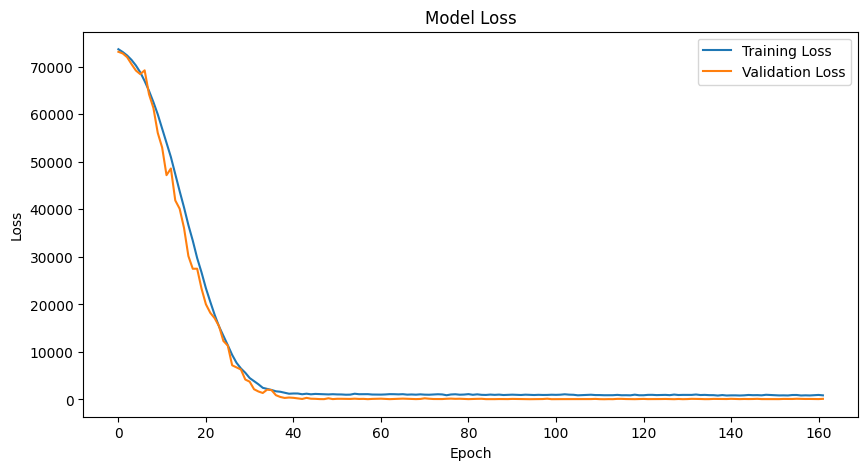

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Accuracy: 0.5164
Precision: 0.4667
Recall: 0.4414
F1-Score: 0.4537
RMSE: 23.164022


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


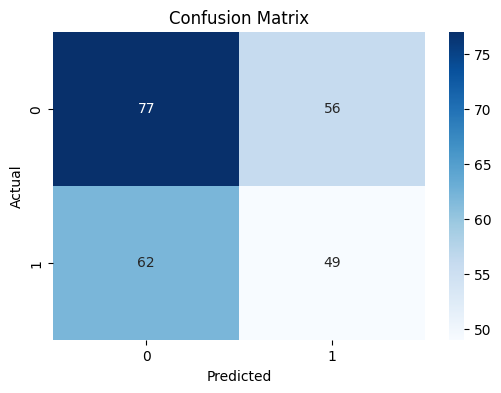

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5163934426229508, 0.4666666666666667, 0.44144144144144143, 0.45370370370370366, 23.164022361407696)
/--------------------------------------------------------------------/
ARM
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step - loss: 3103.4993 - mae: 55.4621 - val_loss: 5015.2031 - val_mae: 70.7356 - learning_rate: 0.0010
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3053.5525 - mae: 55.0393 - val_loss: 5007.4399 - val_mae: 70.6807 - learning_rate: 0.0010
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3065.1311 - mae: 55.1456 - val_loss: 5000.5166 - val_mae: 70.6317 - learning_rate: 0.0010
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3045.4294 - mae: 54.9586 - val_loss: 4992.4131 - val_mae: 70.5743 - learning_rate: 0.0010
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3046.6609 - mae: 54.9628 - val_loss: 4983.6743 - val_mae: 70.5124 - learning_rate: 0.0010
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3063.2268 - mae: 55.1126 - val_loss: 4974.0967 - val_mae: 70.4445 - learning_rate: 0.0010
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3040.3679 - mae: 54.9516 - val_loss: 4965.1123 - val

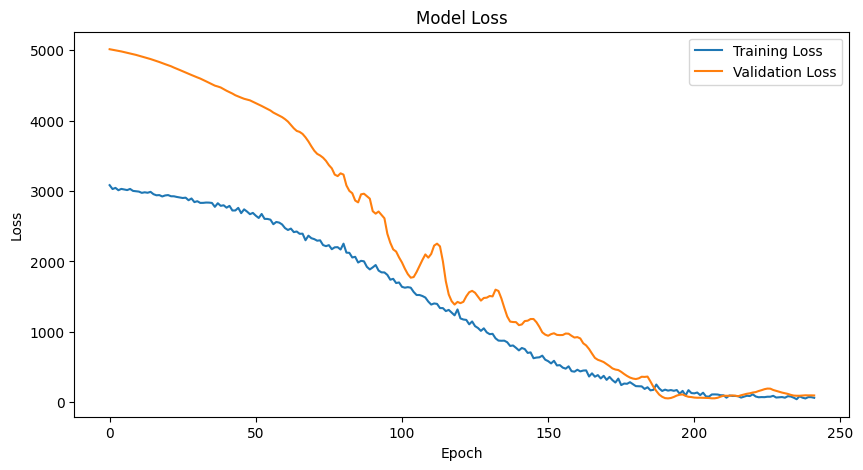

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Accuracy: 0.5041
Precision: 0.5424
Recall: 0.4885
F1-Score: 0.5141
RMSE: 91.262432


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


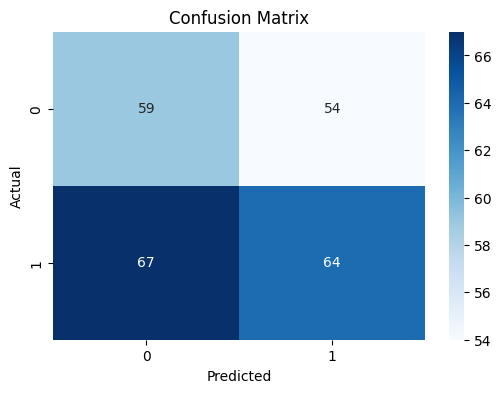

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.5040983606557377, 0.5423728813559322, 0.48854961832061067, 0.5140562248995983, 91.26243181934562)
/--------------------------------------------------------------------/
LIN
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 79774.8828 - mae: 279.0211 - val_loss: 143001.3281 - val_mae: 377.7176 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 79161.8516 - mae: 278.4611 - val_loss: 142071.4844 - val_mae: 376.4866 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 78523.7422 - mae: 277.7009 - val_loss: 139979.4219 - val_mae: 373.7101 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 77570.7031 - mae: 276.3781 - val_loss: 136498.5625 - val_mae: 369.0526 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 76369.8750 - mae: 274.5750 - val_loss: 126522.1953 - val_mae: 355.3618 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 74758.8047 - mae: 271.9738 - val_loss: 119362.2266 - val_mae: 345.0826 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 72906.851

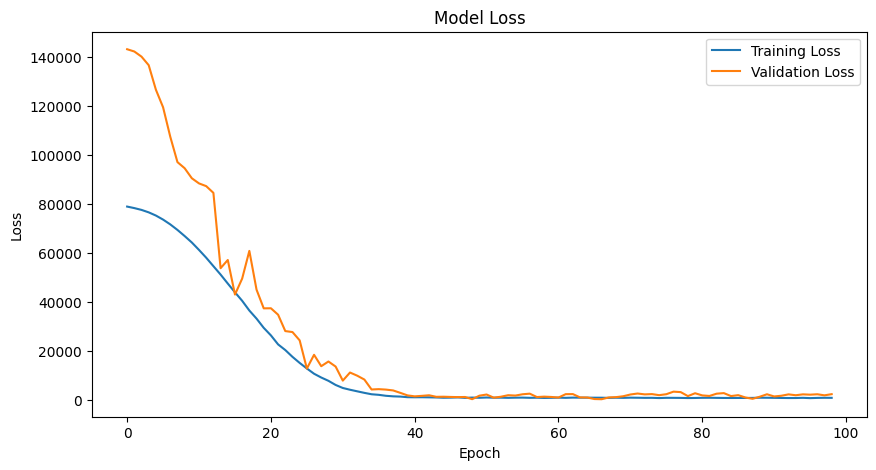

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Accuracy: 0.5492
Precision: 0.5702
Recall: 0.5433
F1-Score: 0.5565
RMSE: 74.429142


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


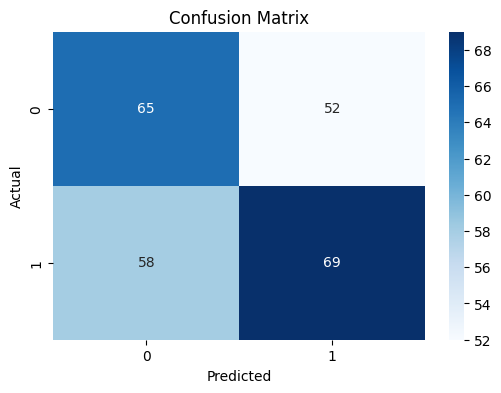

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.5491803278688525, 0.5702479338842975, 0.5433070866141733, 0.5564516129032259, 74.4291419721295)
/--------------------------------------------------------------------/
ORLY
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 1567.4104 - mae: 38.7637 - val_loss: 3763.5200 - val_mae: 61.2921 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1487.0576 - mae: 38.1814 - val_loss: 3646.5405 - val_mae: 60.3305 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1410.5215 - mae: 37.3333 - val_loss: 3424.2905 - val_mae: 58.4630 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1326.2433 - mae: 36.1703 - val_loss: 3146.9753 - val_mae: 56.0455 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1224.6003 - mae: 34.7449 - val_loss: 2716.3831 - val_mae: 52.0754 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1075.4243 - mae: 32.5177 - val_loss: 2236.0728 - val_mae: 47.2550 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 926.6091 - mae: 30.0253 - val_loss: 165

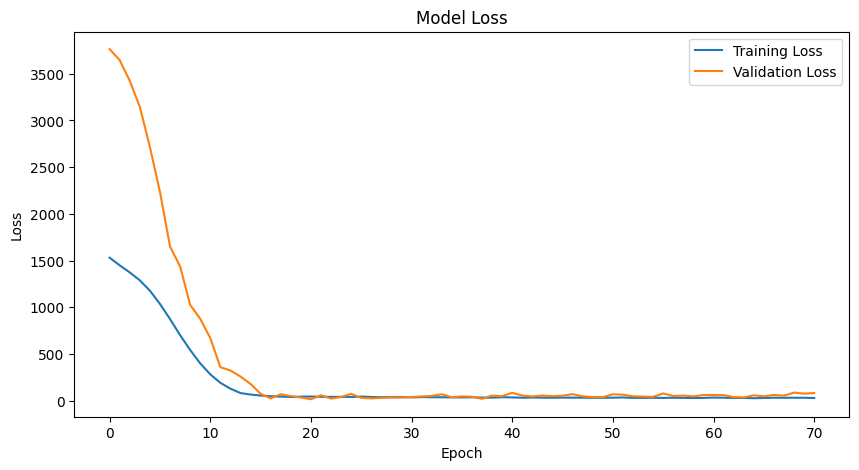

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Accuracy: 0.5205
Precision: 0.6031
Recall: 0.5486
F1-Score: 0.5745
RMSE: 15.027903


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


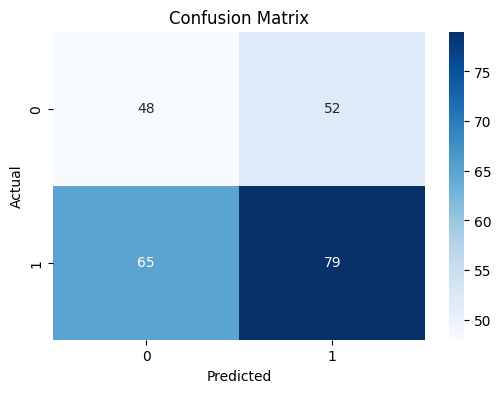

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5204918032786885, 0.6030534351145038, 0.5486111111111112, 0.5745454545454546, 15.027903377507759)
/--------------------------------------------------------------------/
REGN
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 367578.0625 - mae: 599.0299 - val_loss: 630672.2500 - val_mae: 792.9423 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 365982.8750 - mae: 598.2762 - val_loss: 628167.0625 - val_mae: 791.3622 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 364568.5312 - mae: 597.5413 - val_loss: 624265.6875 - val_mae: 788.9008 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 362463.3438 - mae: 596.2244 - val_loss: 616072.1875 - val_mae: 783.7042 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 359405.8750 - mae: 594.0833 - val_loss: 602579.3750 - val_mae: 775.1052 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 355754.9062 - mae: 591.6094 - val_loss: 590352.7500 - val_mae: 767.2239 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 351

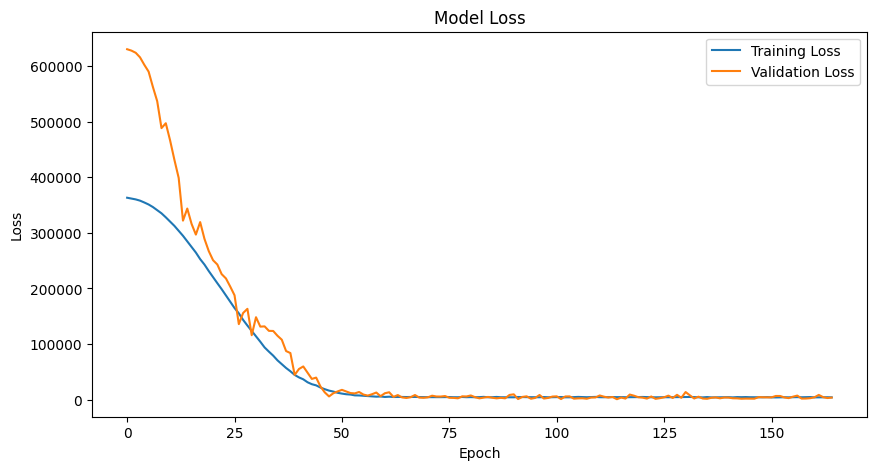

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Accuracy: 0.5123
Precision: 0.5283
Recall: 0.4480
F1-Score: 0.4848
RMSE: 229.955018


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


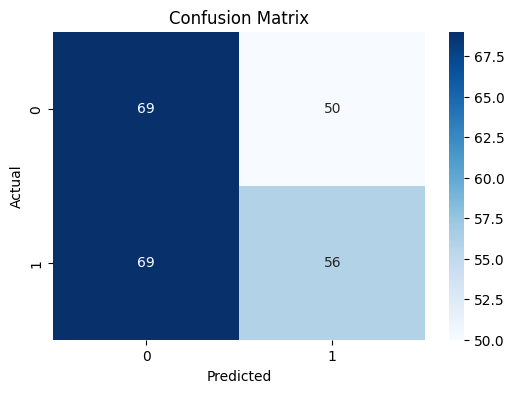

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.5122950819672131, 0.5283018867924528, 0.448, 0.4848484848484848, 229.95501847602546)
/--------------------------------------------------------------------/
AVGO
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 2271.2205 - mae: 46.6053 - val_loss: 6956.9316 - val_mae: 82.3273 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2149.2317 - mae: 45.8876 - val_loss: 6750.8887 - val_mae: 81.0773 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2065.5559 - mae: 45.1629 - val_loss: 6586.7319 - val_mae: 80.0979 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1965.6448 - mae: 44.0940 - val_loss: 6214.2617 - val_mae: 77.8852 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1830.6007 - mae: 42.5159 - val_loss: 5424.6865 - val_mae: 72.8927 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1667.0011 - mae: 40.5162 - val_loss: 4392.2871 - val_mae: 65.5595 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1460.8652 - mae: 37.9214 - val_loss: 37

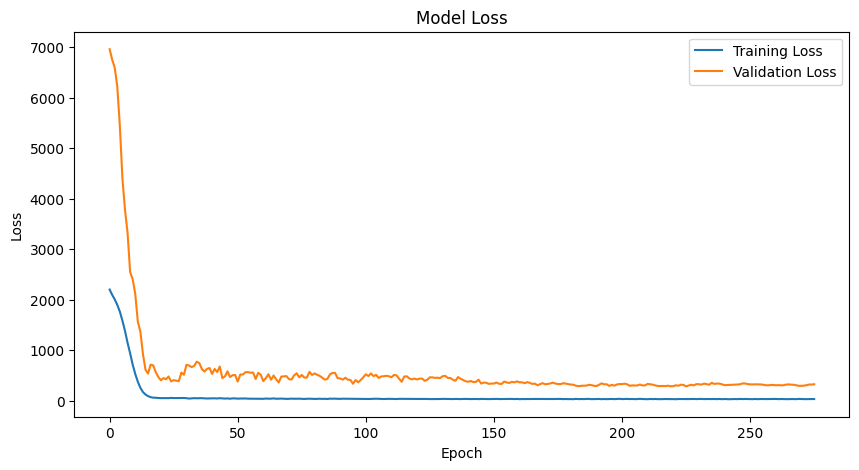

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Accuracy: 0.4754
Precision: 0.5000
Recall: 0.4922
F1-Score: 0.4961
RMSE: 85.553988


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


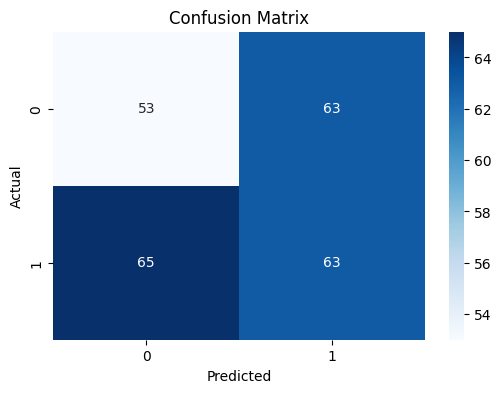

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.47540983606557374, 0.5, 0.4921875, 0.49606299212598426, 85.55398803275968)
/--------------------------------------------------------------------/
INTC
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 2396.2520 - mae: 47.6826 - val_loss: 1223.3308 - val_mae: 34.6073 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2272.1108 - mae: 47.0638 - val_loss: 1134.7954 - val_mae: 33.3085 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2159.5957 - mae: 46.1321 - val_loss: 1082.6532 - val_mae: 32.5750 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2051.5786 - mae: 45.0513 - val_loss: 1075.8707 - val_mae: 32.5681 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1919.4053 - mae: 43.5647 - val_loss: 1029.3391 - val_mae: 31.9042 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1742.1616 - mae: 41.4490 - val_loss: 1096.2347 - val_mae: 32.9667 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1551.0975 - mae: 39.0335 - val_loss: 99

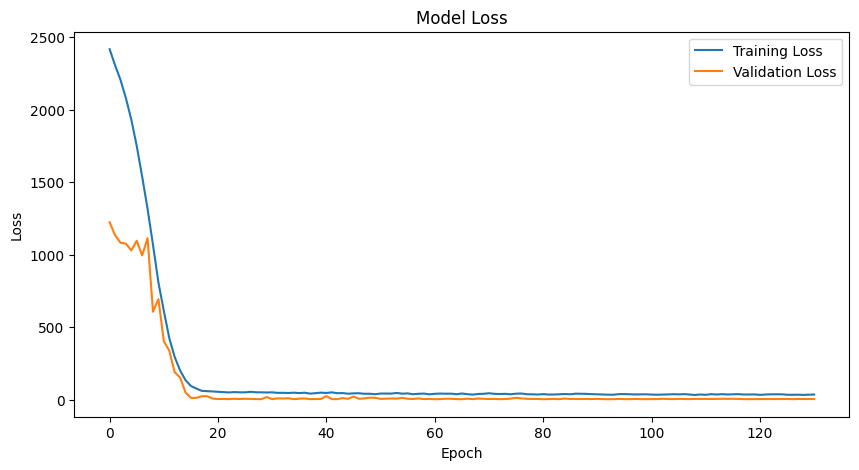

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy: 0.4959
Precision: 0.4896
Recall: 0.3884
F1-Score: 0.4332
RMSE: 2.817881


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


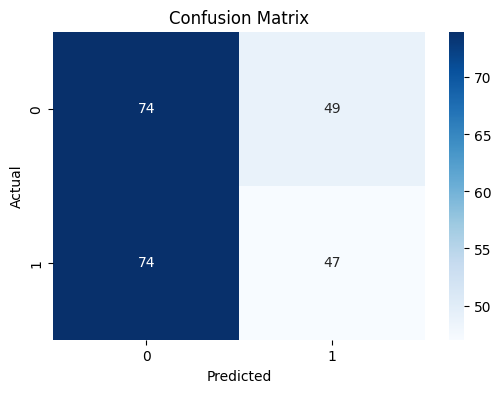

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.4959016393442623, 0.4895833333333333, 0.3884297520661157, 0.4331797235023041, 2.8178808138328018)
/--------------------------------------------------------------------/
SBUX
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 9253.0908 - mae: 95.2200 - val_loss: 9812.5869 - val_mae: 98.9342 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9051.0674 - mae: 94.6063 - val_loss: 9568.7559 - val_mae: 97.6982 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8874.2236 - mae: 93.8449 - val_loss: 9316.5762 - val_mae: 96.4110 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8637.2109 - mae: 92.6863 - val_loss: 9096.0469 - val_mae: 95.2658 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8340.0918 - mae: 91.0910 - val_loss: 8492.8311 - val_mae: 92.0984 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7967.9033 - mae: 89.0092 - val_loss: 7631.7451 - val_mae: 87.3007 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7473.5332 - mae: 86.1559 - val_loss: 70

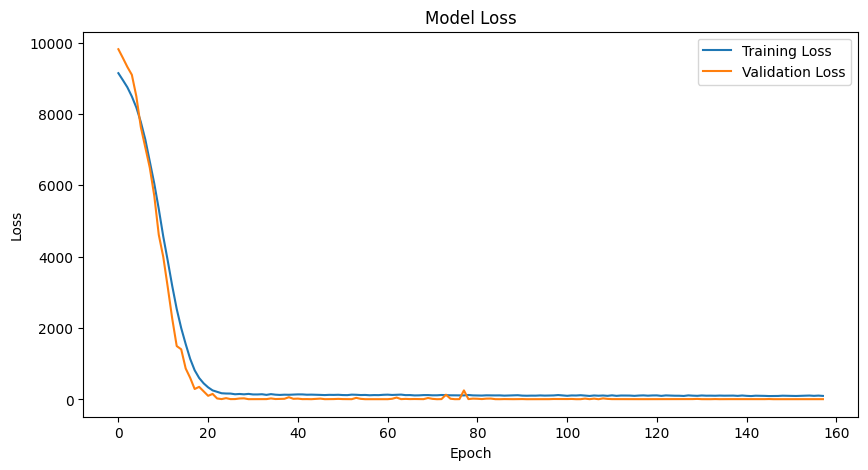

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Accuracy: 0.4508
Precision: 0.4138
Recall: 0.4211
F1-Score: 0.4174
RMSE: 3.501751


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


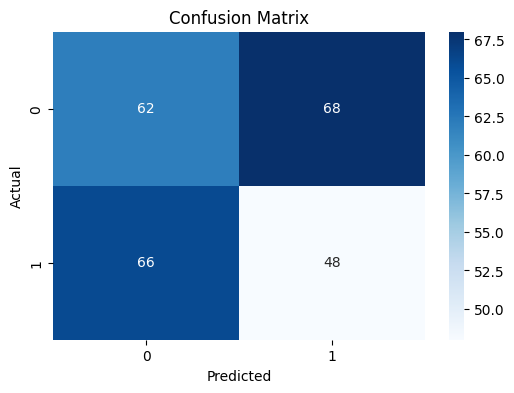

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.45081967213114754, 0.41379310344827586, 0.42105263157894735, 0.4173913043478261, 3.501750857508783)
/--------------------------------------------------------------------/
PDD
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 8857.8643 - mae: 86.3753 - val_loss: 8995.0049 - val_mae: 91.5346 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8328.9219 - mae: 85.7810 - val_loss: 8901.5850 - val_mae: 91.1237 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7915.6973 - mae: 84.5375 - val_loss: 8553.4121 - val_mae: 89.4612 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7539.0586 - mae: 83.2541 - val_loss: 8299.7031 - val_mae: 88.4863 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7099.8486 - mae: 81.3101 - val_loss: 7537.8560 - val_mae: 84.7929 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6642.9204 - mae: 78.9340 - val_loss: 7149.2109 - val_mae: 82.9980 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6183.2295 - mae: 76.5260 - val_loss: 55

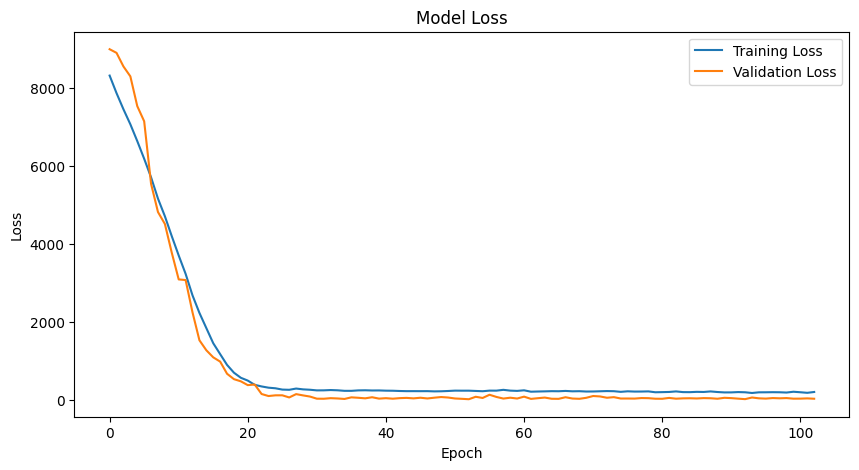

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.5041
Precision: 0.4615
Recall: 0.4248
F1-Score: 0.4424
RMSE: 9.057757


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


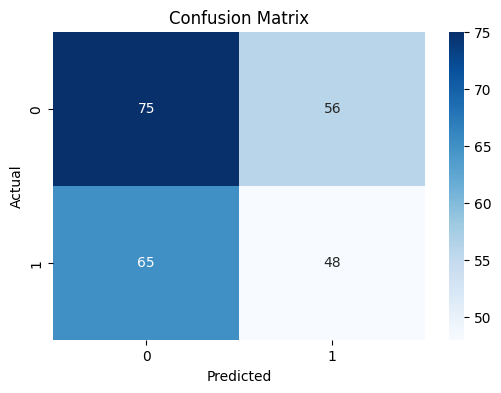

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5040983606557377, 0.46153846153846156, 0.4247787610619469, 0.44239631336405527, 9.05775663311116)
/--------------------------------------------------------------------/
AMZN
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 20357.5059 - mae: 139.9394 - val_loss: 16426.6992 - val_mae: 127.2417 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 19990.3535 - mae: 139.3896 - val_loss: 16243.4062 - val_mae: 126.5518 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 19590.9180 - mae: 138.4899 - val_loss: 16243.3320 - val_mae: 126.6776 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 19041.3809 - mae: 136.9090 - val_loss: 16338.5381 - val_mae: 127.2564 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18518.1738 - mae: 135.3106 - val_loss: 16282.7529 - val_mae: 127.2412 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17822.1211 - mae: 132.9392 - val_loss: 17187.1484 - val_mae: 130.9017 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17028.6191 - ma

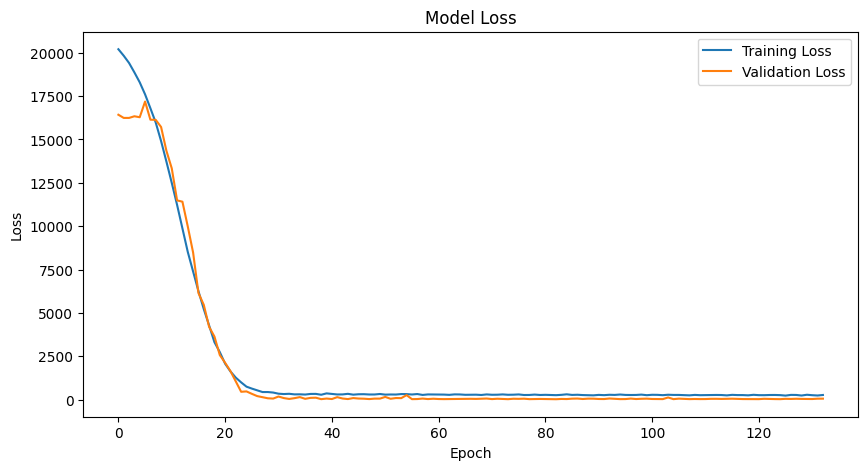

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Accuracy: 0.5000
Precision: 0.5286
Recall: 0.5692
F1-Score: 0.5481
RMSE: 14.104734


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


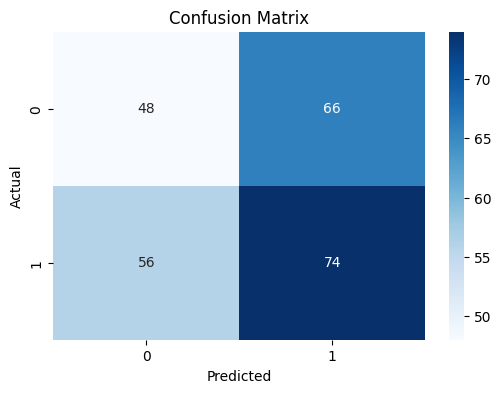

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5, 0.5285714285714286, 0.5692307692307692, 0.5481481481481482, 14.104733801462979)
/--------------------------------------------------------------------/
HON
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 38061.3047 - mae: 193.4456 - val_loss: 37332.7734 - val_mae: 193.0577 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 37695.8633 - mae: 192.9161 - val_loss: 36520.6562 - val_mae: 190.9491 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 37279.4453 - mae: 192.1048 - val_loss: 35492.2969 - val_mae: 188.2472 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 36717.1211 - mae: 190.8632 - val_loss: 34408.4062 - val_mae: 185.3628 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 35984.7344 - mae: 189.1357 - val_loss: 34030.2578 - val_mae: 184.3604 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 35116.3555 - mae: 186.9670 - val_loss: 33220.9219 - val_mae: 182.1928 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 33991.5742 - ma

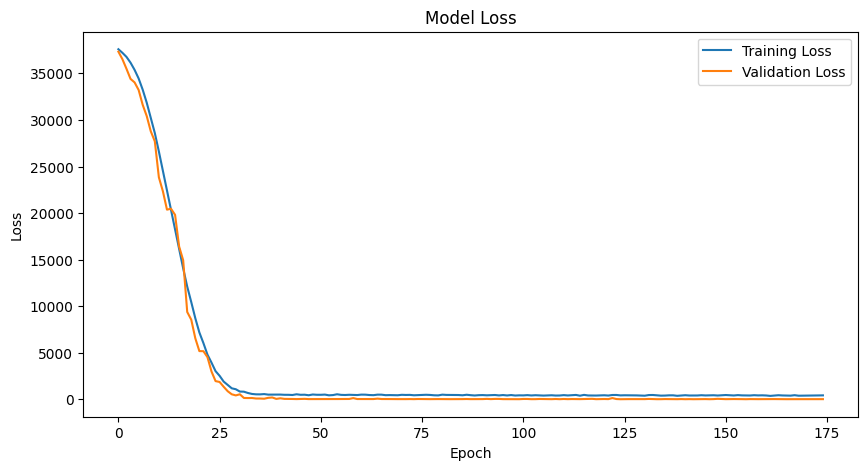

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Accuracy: 0.4959
Precision: 0.5115
Recall: 0.5317
F1-Score: 0.5214
RMSE: 5.160413


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


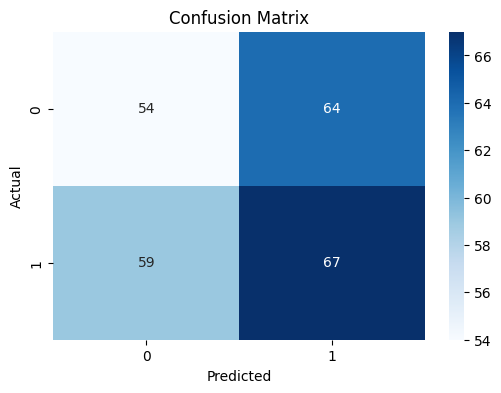

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4959016393442623, 0.5114503816793893, 0.5317460317460317, 0.5214007782101167, 5.1604131009236545)
/--------------------------------------------------------------------/
MRVL
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 2562.2668 - mae: 48.6688 - val_loss: 2825.9590 - val_mae: 52.5506 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2402.0601 - mae: 48.0989 - val_loss: 2685.2546 - val_mae: 51.2275 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2292.3586 - mae: 47.3041 - val_loss: 2491.9302 - val_mae: 49.3722 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2165.6997 - mae: 46.0956 - val_loss: 2326.5706 - val_mae: 47.7427 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2029.4799 - mae: 44.6261 - val_loss: 2054.8901 - val_mae: 45.0517 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1860.4135 - mae: 42.6755 - val_loss: 1902.1157 - val_mae: 43.3714 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1662.6759 - mae: 40.2039 - val_loss: 18

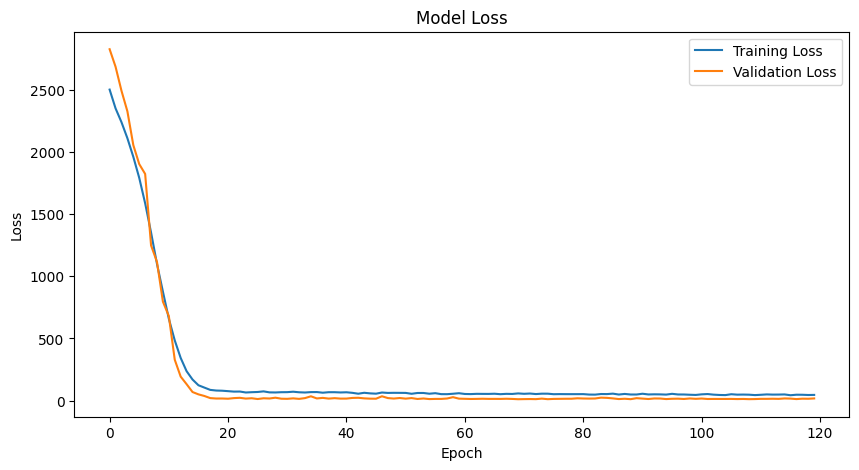

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Accuracy: 0.4549
Precision: 0.4776
Recall: 0.5039
F1-Score: 0.4904
RMSE: 8.477971


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


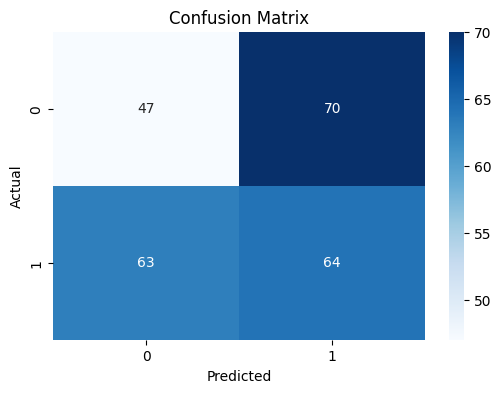

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.45491803278688525, 0.47761194029850745, 0.5039370078740157, 0.4904214559386973, 8.477971167358284)
/--------------------------------------------------------------------/
PYPL
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 32378.8418 - mae: 164.8718 - val_loss: 4005.8594 - val_mae: 62.9132 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 31403.0215 - mae: 164.3250 - val_loss: 3756.7532 - val_mae: 60.9106 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 30481.0879 - mae: 163.2697 - val_loss: 3807.7705 - val_mae: 61.3630 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 29520.5918 - mae: 161.8341 - val_loss: 4771.8418 - val_mae: 68.7727 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 28320.6621 - mae: 159.6971 - val_loss: 6208.2856 - val_mae: 78.4998 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 26919.6172 - mae: 156.8546 - val_loss: 8199.1885 - val_mae: 90.3173 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 25513.1484 - mae: 153.7742 

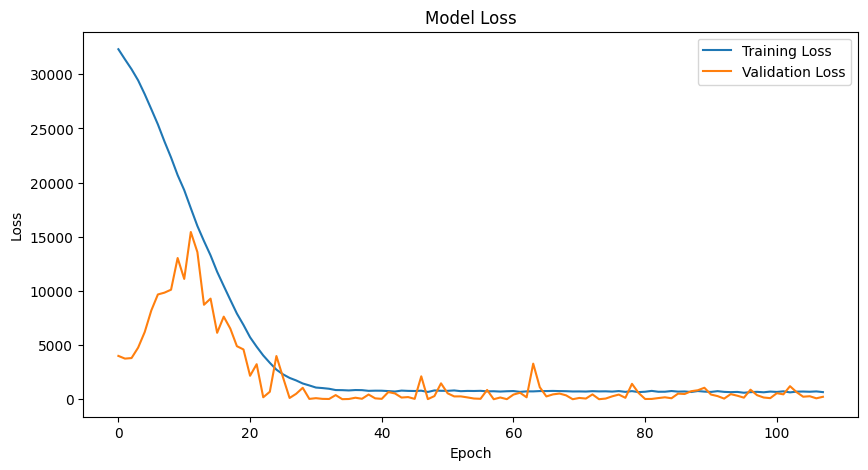

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Accuracy: 0.5164
Precision: 0.5547
Recall: 0.5714
F1-Score: 0.5630
RMSE: 2.806831


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


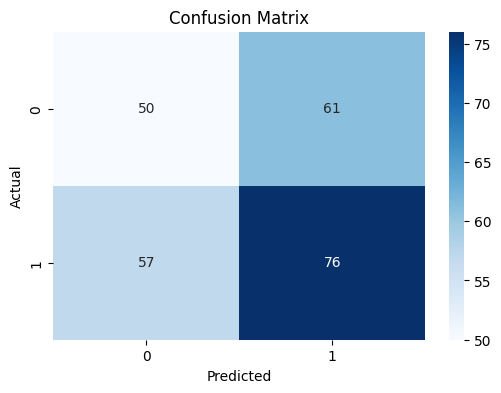

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.5163934426229508, 0.5547445255474452, 0.5714285714285714, 0.562962962962963, 2.8068306484862786)
/--------------------------------------------------------------------/
MSFT
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 63107.4219 - mae: 247.4413 - val_loss: 109213.3516 - val_mae: 329.3221 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 62553.7930 - mae: 246.9792 - val_loss: 108238.3516 - val_mae: 327.8454 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 61880.5703 - mae: 246.1607 - val_loss: 106151.7812 - val_mae: 324.6706 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 60976.8516 - mae: 244.7482 - val_loss: 102821.0312 - val_mae: 319.5595 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 59898.6367 - mae: 242.8815 - val_loss: 96910.6406 - val_mae: 310.4364 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 58440.6406 - mae: 240.3006 - val_loss: 93840.6797 - val_mae: 305.4220 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 56769.8047 

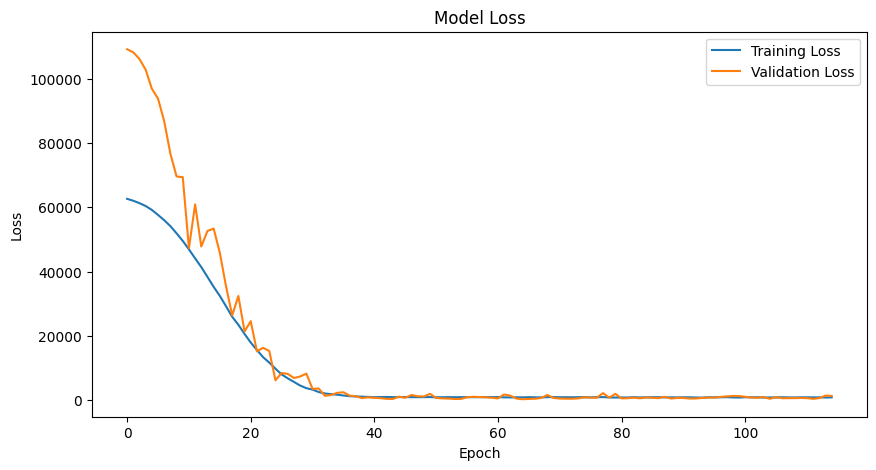

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step
Accuracy: 0.4918
Precision: 0.5323
Recall: 0.5000
F1-Score: 0.5156
RMSE: 76.789908


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


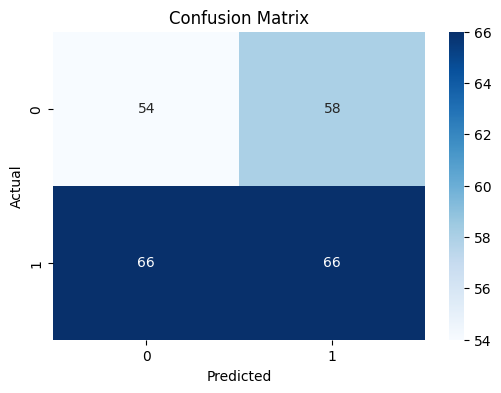

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.4918032786885246, 0.532258064516129, 0.5, 0.515625, 76.78990819222118)
/--------------------------------------------------------------------/
CHTR
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 323267.7500 - mae: 555.1423 - val_loss: 150457.6875 - val_mae: 385.8931 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 321409.5312 - mae: 554.5118 - val_loss: 150410.2500 - val_mae: 385.8499 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 319472.2188 - mae: 553.6155 - val_loss: 150812.2031 - val_mae: 386.4001 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 316875.3125 - mae: 552.1166 - val_loss: 154008.5312 - val_mae: 390.7040 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 313739.3125 - mae: 550.0454 - val_loss: 159735.9531 - val_mae: 397.9449 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 309731.6562 - mae: 547.3209 - val_loss: 167528.8906 - val_mae: 407.7382 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 305

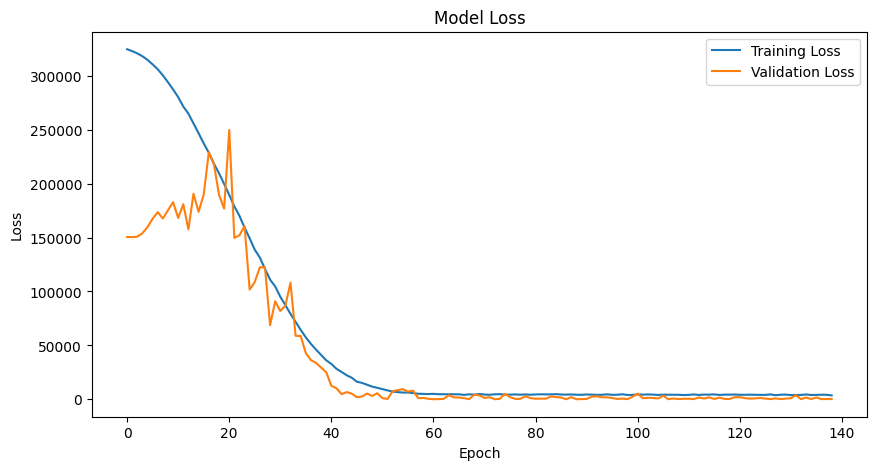

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Accuracy: 0.5287
Precision: 0.5046
Recall: 0.4741
F1-Score: 0.4889
RMSE: 22.206139


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


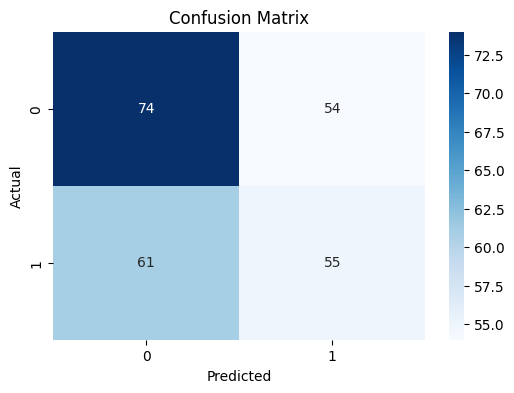

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.5286885245901639, 0.5045871559633027, 0.47413793103448276, 0.4888888888888889, 22.206138533112266)
/--------------------------------------------------------------------/
LRCX
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 2367.6995 - mae: 47.4424 - val_loss: 3882.2952 - val_mae: 61.8484 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2257.8633 - mae: 46.9469 - val_loss: 3701.5867 - val_mae: 60.3710 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2147.7336 - mae: 46.0073 - val_loss: 3471.9297 - val_mae: 58.4445 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2038.2257 - mae: 44.8642 - val_loss: 3191.6697 - val_mae: 56.0429 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1908.4268 - mae: 43.3355 - val_loss: 2869.8792 - val_mae: 53.1728 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1745.3805 - mae: 41.3706 - val_loss: 2569.2766 - val_mae: 50.4155 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1536.3560 - mae: 38.7355 - val_loss: 19

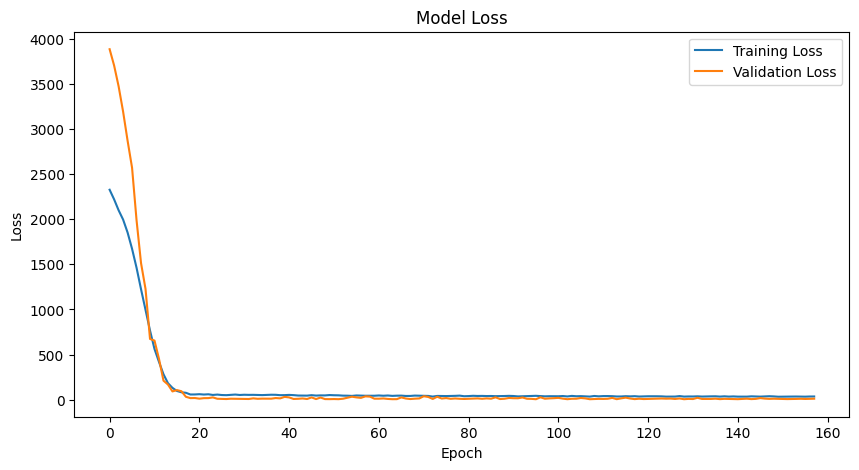

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.5410
Precision: 0.5441
Recall: 0.5968
F1-Score: 0.5692
RMSE: 18.015162


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


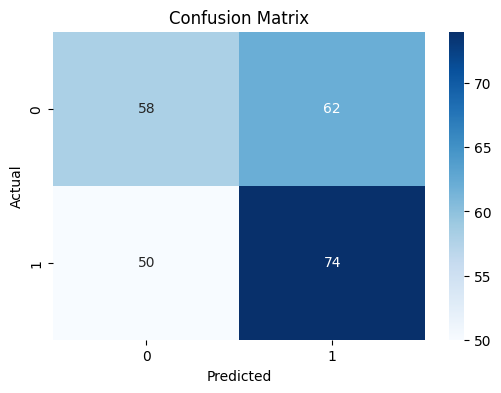

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5409836065573771, 0.5441176470588235, 0.5967741935483871, 0.5692307692307692, 18.01516154138604)
/--------------------------------------------------------------------/
GILD
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 4762.1055 - mae: 68.6090 - val_loss: 6118.7583 - val_mae: 78.1779 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4668.8154 - mae: 68.1175 - val_loss: 6055.7314 - val_mae: 77.7740 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4542.0483 - mae: 67.2420 - val_loss: 5851.5908 - val_mae: 76.4535 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4369.7832 - mae: 65.9717 - val_loss: 5448.6299 - val_mae: 73.7816 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4188.6309 - mae: 64.5915 - val_loss: 4969.4888 - val_mae: 70.4557 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3925.6826 - mae: 62.4918 - val_loss: 4277.5928 - val_mae: 65.3689 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3592.8652 - mae: 59.7694 - val_loss: 31

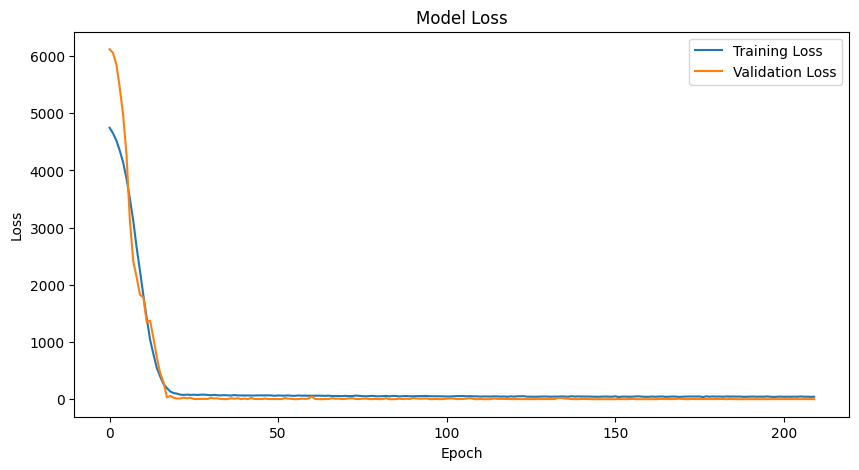

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Accuracy: 0.5123
Precision: 0.5522
Recall: 0.5564
F1-Score: 0.5543
RMSE: 3.104829


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


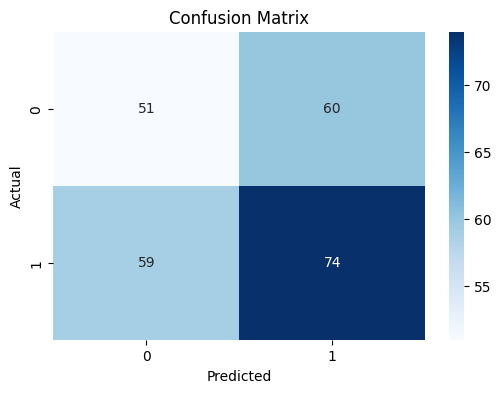

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5122950819672131, 0.5522388059701493, 0.556390977443609, 0.5543071161048688, 3.104828936507086)
/--------------------------------------------------------------------/
KDP
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 1136.8182 - mae: 33.5086 - val_loss: 1024.0527 - val_mae: 31.9562 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1088.6178 - mae: 32.8970 - val_loss: 978.1330 - val_mae: 31.2322 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1041.8948 - mae: 32.1955 - val_loss: 893.5724 - val_mae: 29.8566 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 982.3155 - mae: 31.2564 - val_loss: 764.7418 - val_mae: 27.6348 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 887.0333 - mae: 29.6798 - val_loss: 701.9443 - val_mae: 26.4770 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 786.0406 - mae: 27.8822 - val_loss: 570.2107 - val_mae: 23.8333 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 645.1385 - mae: 25.2303 - val_loss: 458.1960 - 

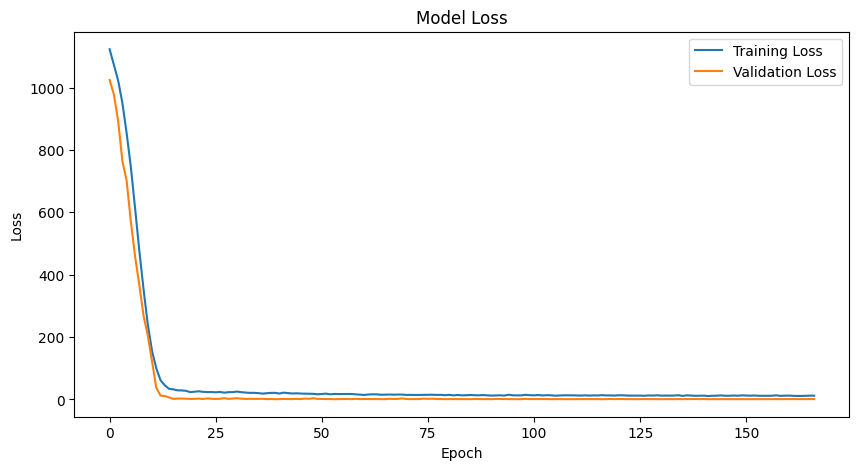

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Accuracy: 0.5041
Precision: 0.5077
Recall: 0.5366
F1-Score: 0.5217
RMSE: 0.858709


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


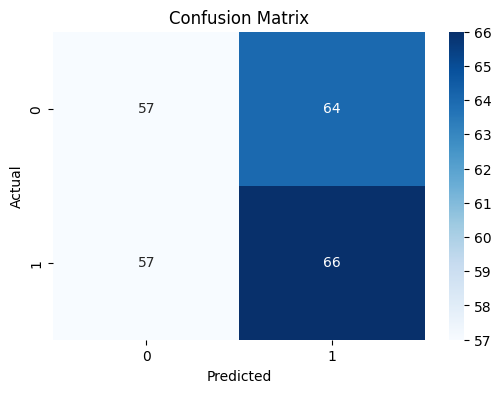

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5040983606557377, 0.5076923076923077, 0.5365853658536586, 0.5217391304347826, 0.8587094555197872)
/--------------------------------------------------------------------/
QCOM
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 17696.4707 - mae: 130.6607 - val_loss: 14146.4033 - val_mae: 118.5378 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17302.4805 - mae: 129.9007 - val_loss: 14005.5381 - val_mae: 117.9494 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16977.8965 - mae: 129.0718 - val_loss: 13797.4551 - val_mae: 117.0788 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16519.3594 - mae: 127.5657 - val_loss: 13654.0801 - val_mae: 116.5054 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15992.2695 - mae: 125.7179 - val_loss: 12983.1533 - val_mae: 113.6084 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 15418.6328 - mae: 123.5595 - val_loss: 12720.6914 - val_mae: 112.5773 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 14729.5186 - ma

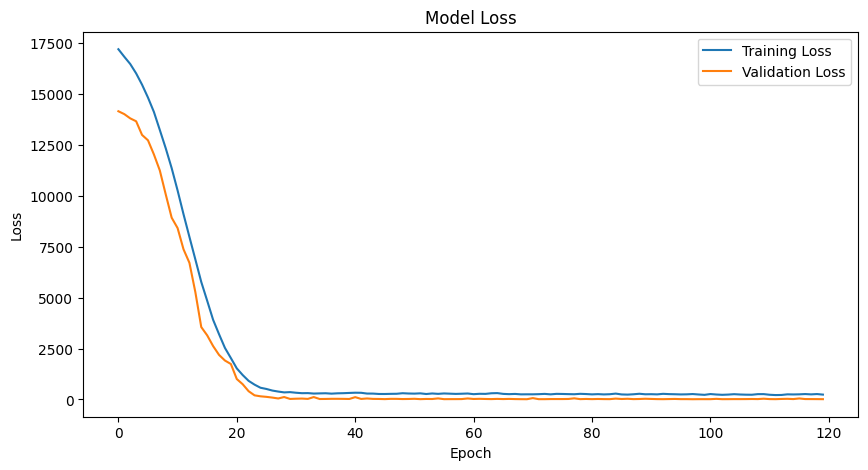

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Accuracy: 0.5123
Precision: 0.5317
Recall: 0.5276
F1-Score: 0.5296
RMSE: 14.966258


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


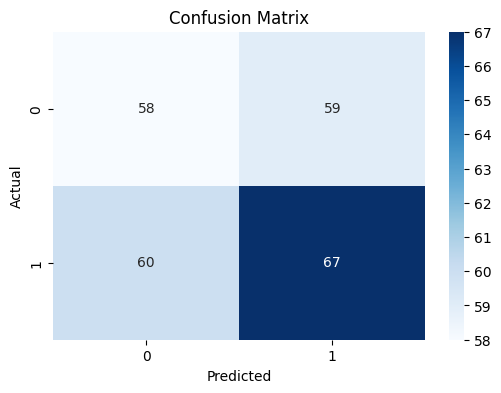

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5122950819672131, 0.5317460317460317, 0.5275590551181102, 0.5296442687747036, 14.966257783291818)
/--------------------------------------------------------------------/
GEHC
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step - loss: 5545.7891 - mae: 74.1340 - val_loss: 5000.1914 - val_mae: 70.5821 - learning_rate: 0.0010
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5495.4668 - mae: 73.8571 - val_loss: 4977.0874 - val_mae: 70.4182 - learning_rate: 0.0010
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5453.8594 - mae: 73.6431 - val_loss: 4949.4629 - val_mae: 70.2219 - learning_rate: 0.0010
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5423.4663 - mae: 73.4741 - val_loss: 4921.8457 - val_mae: 70.0253 - learning_rate: 0.0010
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5410.1494 - mae: 73.3971 - val_loss: 4895.3208 - val_mae: 69.8363 - learning_rate: 0.0010
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5380.7217 - mae: 73.1787 - val_loss: 4871.8887 - val_mae: 69.6693 - learning_rate: 0.0010
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5363.0103 - mae: 73.0900 - val_loss: 4

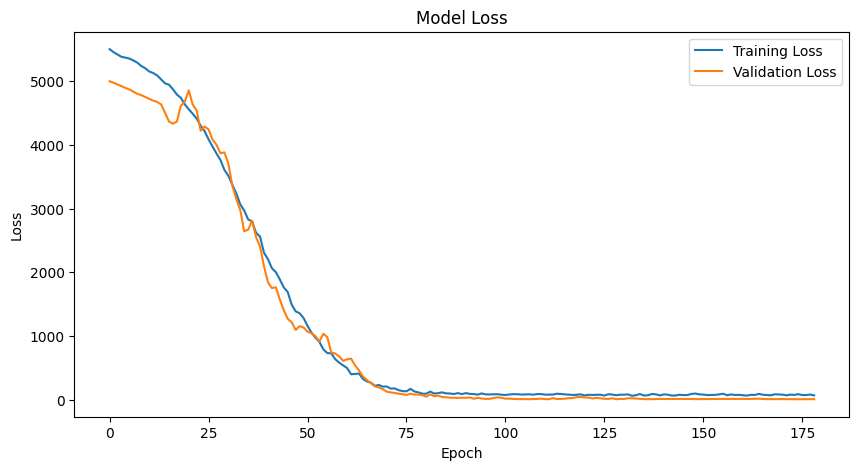

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.5000
Precision: 0.4958
Recall: 0.4876
F1-Score: 0.4917
RMSE: 5.789256


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


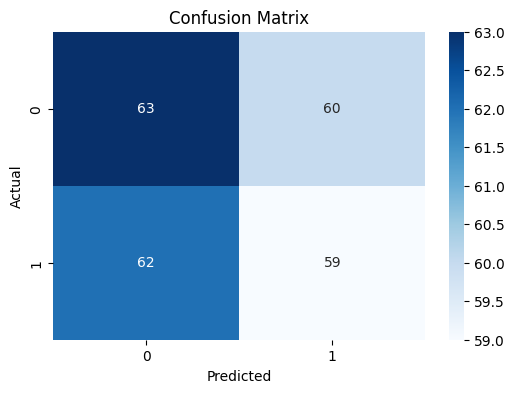

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5, 0.4957983193277311, 0.48760330578512395, 0.4916666666666667, 5.789256222722639)
/--------------------------------------------------------------------/
CMCSA
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 2096.4231 - mae: 45.2489 - val_loss: 1717.9551 - val_mae: 41.3573 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2018.9133 - mae: 44.7006 - val_loss: 1669.4607 - val_mae: 40.7791 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1955.7445 - mae: 44.0474 - val_loss: 1584.9370 - val_mae: 39.7441 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1851.6941 - mae: 42.8620 - val_loss: 1529.8608 - val_mae: 39.0555 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1725.4594 - mae: 41.3728 - val_loss: 1551.2999 - val_mae: 39.3608 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1564.2020 - mae: 39.3307 - val_loss: 1246.3544 - val_mae: 35.2636 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1370.0059 - mae: 36.7593 - val_loss: 12

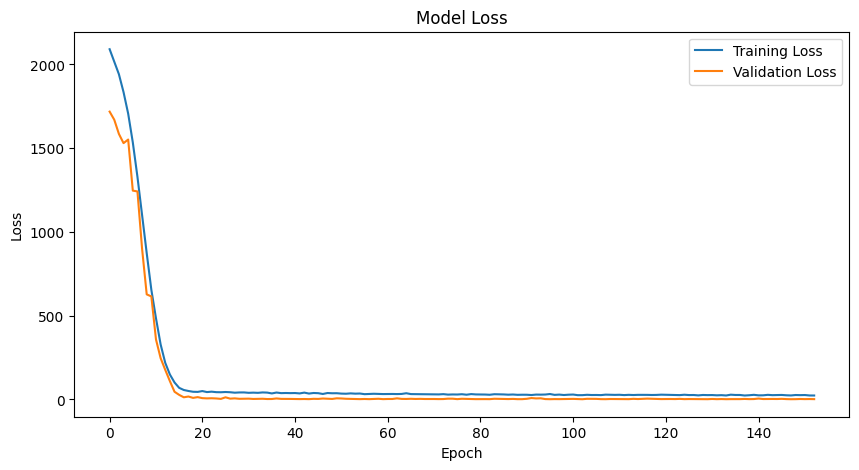

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Accuracy: 0.4918
Precision: 0.4483
Recall: 0.4643
F1-Score: 0.4561
RMSE: 1.105555


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


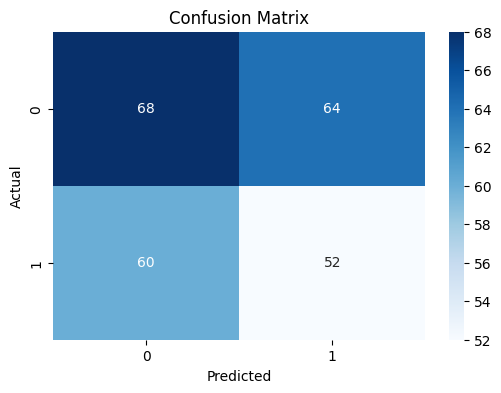

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4918032786885246, 0.4482758620689655, 0.4642857142857143, 0.456140350877193, 1.1055554490917336)
/--------------------------------------------------------------------/
ANSS
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 97681.6797 - mae: 308.2867 - val_loss: 96280.8594 - val_mae: 309.6894 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 96948.6406 - mae: 307.6984 - val_loss: 95505.8516 - val_mae: 308.4450 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 96072.0078 - mae: 306.9119 - val_loss: 94153.2656 - val_mae: 306.2671 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 94966.7422 - mae: 305.5479 - val_loss: 92473.3594 - val_mae: 303.5797 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 93469.5703 - mae: 303.5371 - val_loss: 91644.7891 - val_mae: 302.2743 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 91898.0234 - mae: 301.3268 - val_loss: 88964.6953 - val_mae: 297.8358 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 89667.1562 - ma

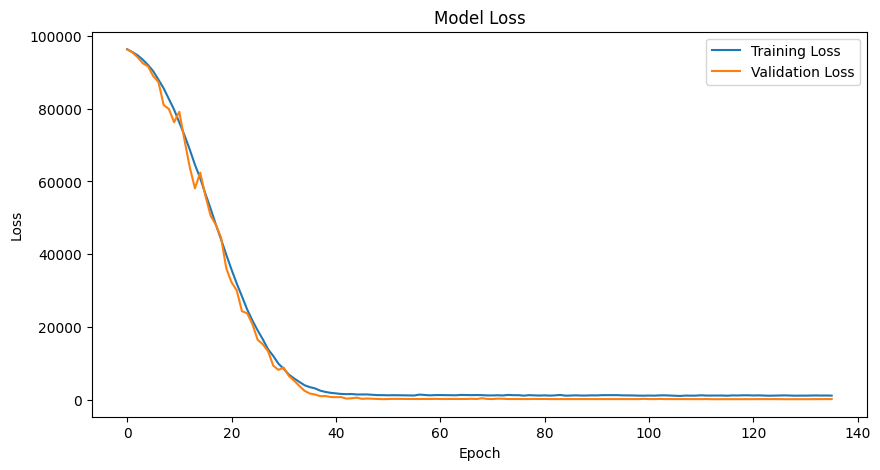

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Accuracy: 0.4877
Precision: 0.4960
Recall: 0.5000
F1-Score: 0.4980
RMSE: 7.311463


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


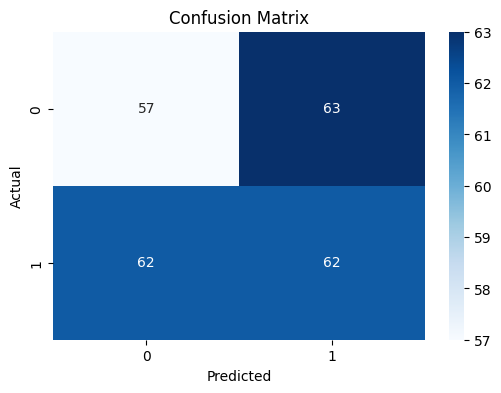

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.48770491803278687, 0.496, 0.5, 0.4979919678714859, 7.311462611457609)
/--------------------------------------------------------------------/
AAPL
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 18298.0098 - mae: 132.6367 - val_loss: 31984.3242 - val_mae: 178.5232 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 17912.0488 - mae: 131.9746 - val_loss: 31236.3887 - val_mae: 176.4200 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 17514.8672 - mae: 130.9418 - val_loss: 30035.3164 - val_mae: 172.9905 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 17063.5312 - mae: 129.5706 - val_loss: 28113.0898 - val_mae: 167.3818 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 16540.3164 - mae: 127.8270 - val_loss: 26069.7188 - val_mae: 161.1915 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 15875.1572 - mae: 125.3588 - val_loss: 25469.9180 - val_mae: 159.2169 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 15089.5059 - ma

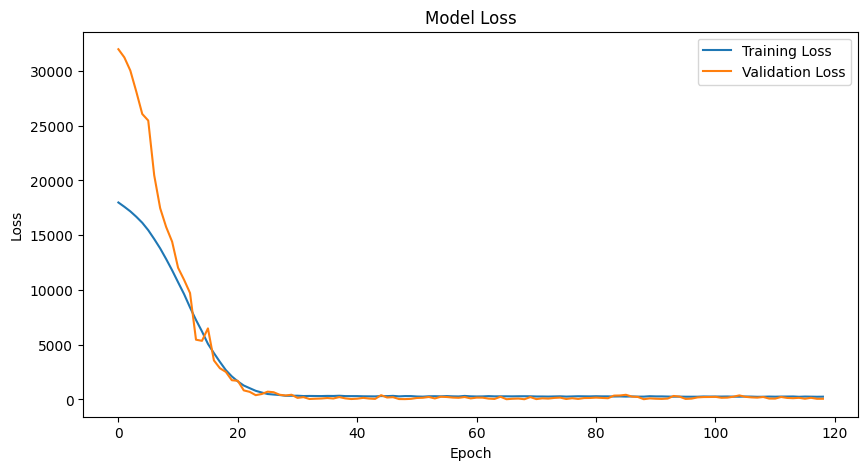

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Accuracy: 0.5328
Precision: 0.5931
Recall: 0.6099
F1-Score: 0.6014
RMSE: 29.465444


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


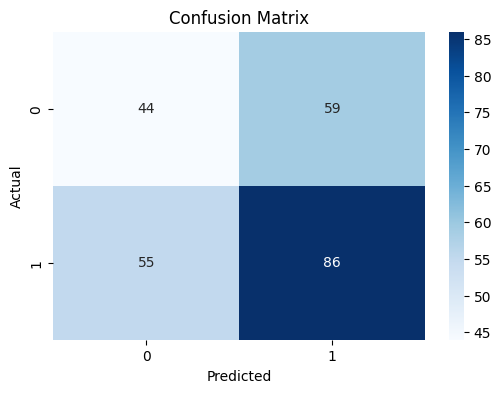

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.5327868852459017, 0.593103448275862, 0.6099290780141844, 0.6013986013986014, 29.46544368697586)
/--------------------------------------------------------------------/
EA
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 16737.6211 - mae: 128.9288 - val_loss: 16288.2559 - val_mae: 127.4498 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16564.5312 - mae: 128.4015 - val_loss: 16286.3271 - val_mae: 127.4460 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16357.3096 - mae: 127.6477 - val_loss: 16246.7490 - val_mae: 127.3040 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 16033.9385 - mae: 126.4411 - val_loss: 15900.7607 - val_mae: 125.9706 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 15676.0977 - mae: 125.0206 - val_loss: 15282.6543 - val_mae: 123.5413 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 15126.3174 - mae: 122.8125 - val_loss: 14380.7012 - val_mae: 119.8488 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 14411.1279 - ma

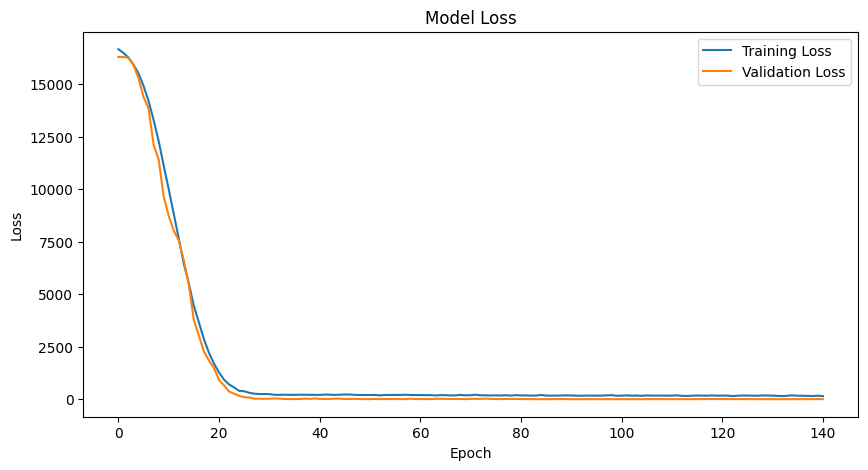

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Accuracy: 0.5082
Precision: 0.5426
Recall: 0.5344
F1-Score: 0.5385
RMSE: 7.730311


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


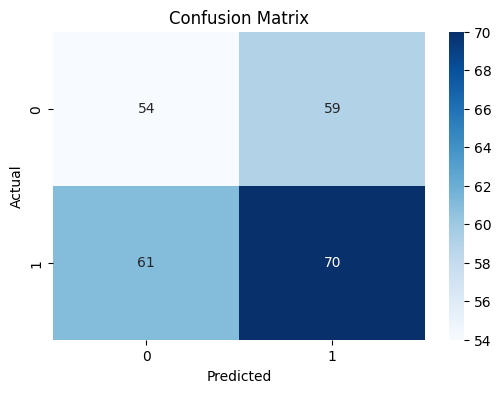

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5081967213114754, 0.5426356589147286, 0.5343511450381679, 0.5384615384615385, 7.730311154999196)
/--------------------------------------------------------------------/
MNST
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 1902.3638 - mae: 43.3507 - val_loss: 3044.0439 - val_mae: 55.0985 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1844.6757 - mae: 42.7852 - val_loss: 2970.8218 - val_mae: 54.4298 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1776.5303 - mae: 42.0258 - val_loss: 2845.9058 - val_mae: 53.2773 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1692.5824 - mae: 41.0293 - val_loss: 2586.4854 - val_mae: 50.7867 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1575.5016 - mae: 39.5198 - val_loss: 2160.3970 - val_mae: 46.4113 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1416.2988 - mae: 37.4511 - val_loss: 1846.1899 - val_mae: 42.8829 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1245.3265 - mae: 35.0832 - val_loss: 13

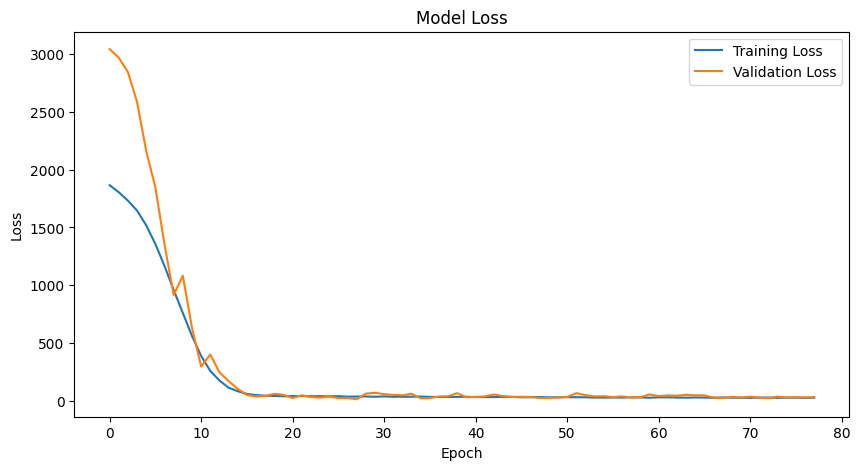

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Accuracy: 0.4795
Precision: 0.4688
Recall: 0.5042
F1-Score: 0.4858
RMSE: 3.217585


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


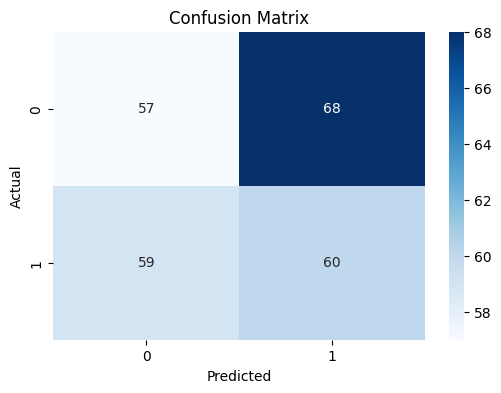

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.47950819672131145, 0.46875, 0.5042016806722689, 0.48582995951417, 3.21758459973537)
/--------------------------------------------------------------------/
WDAY
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 44892.8750 - mae: 207.7195 - val_loss: 49720.0547 - val_mae: 221.5455 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 44329.3008 - mae: 207.1904 - val_loss: 49487.9883 - val_mae: 221.0666 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 43715.2461 - mae: 206.3044 - val_loss: 49651.3516 - val_mae: 221.5824 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 42891.0703 - mae: 204.8464 - val_loss: 47996.5938 - val_mae: 218.0370 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 41936.9141 - mae: 202.9957 - val_loss: 44541.3125 - val_mae: 210.3046 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 40847.7930 - mae: 200.6949 - val_loss: 41806.0156 - val_mae: 203.7762 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 39363.0195 - ma

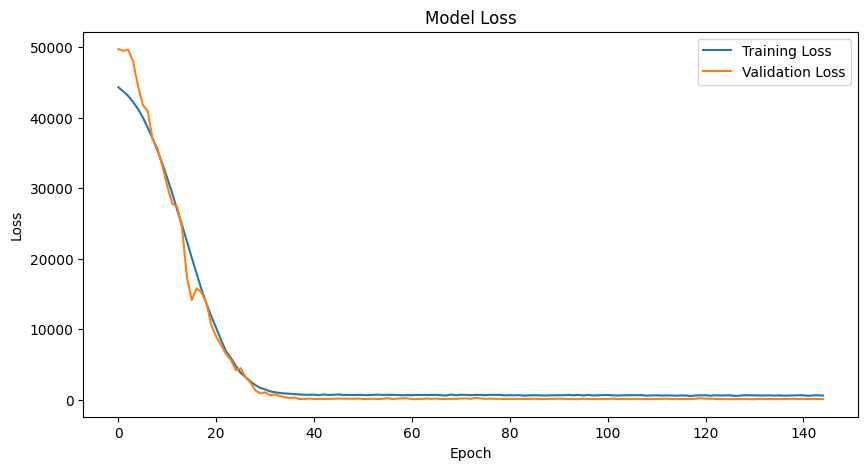

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Accuracy: 0.4549
Precision: 0.4561
Recall: 0.4228
F1-Score: 0.4388
RMSE: 10.191819


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


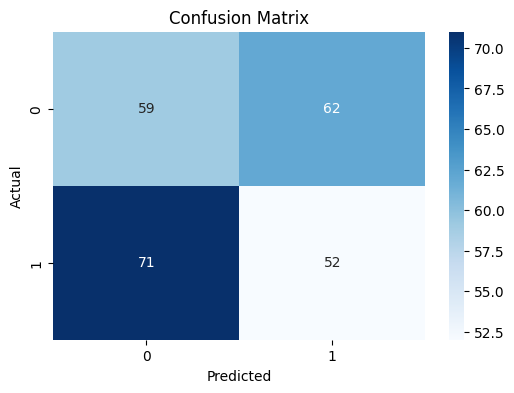

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.45491803278688525, 0.45614035087719296, 0.42276422764227645, 0.4388185654008439, 10.191818689679884)
/--------------------------------------------------------------------/
IDXX
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 221542.6406 - mae: 456.0084 - val_loss: 234418.9219 - val_mae: 482.6401 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 219661.9219 - mae: 455.3455 - val_loss: 233976.3750 - val_mae: 482.2042 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 217842.7656 - mae: 454.3246 - val_loss: 232311.9531 - val_mae: 480.5846 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 215664.0469 - mae: 452.8615 - val_loss: 228493.2500 - val_mae: 476.8101 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 212634.1875 - mae: 450.6253 - val_loss: 221470.9688 - val_mae: 469.5379 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 209514.1094 - mae: 448.1269 - val_loss: 215903.4062 - val_mae: 463.9415 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 205

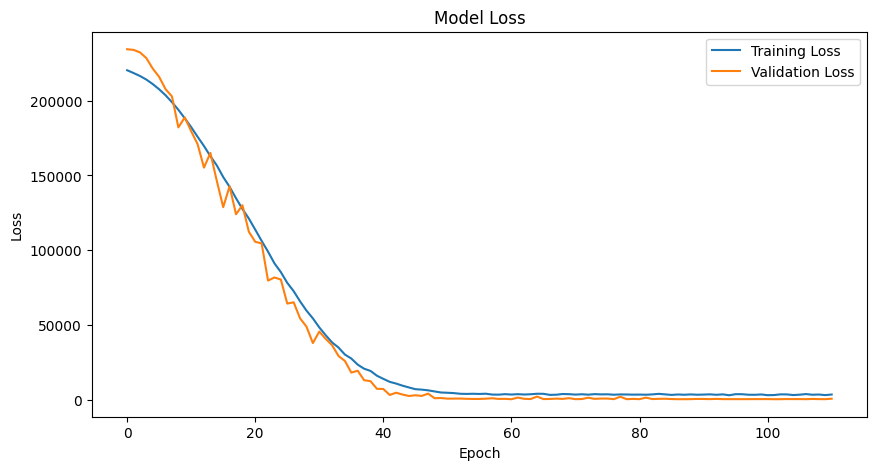

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Accuracy: 0.4959
Precision: 0.4407
Recall: 0.4771
F1-Score: 0.4581
RMSE: 16.993657


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


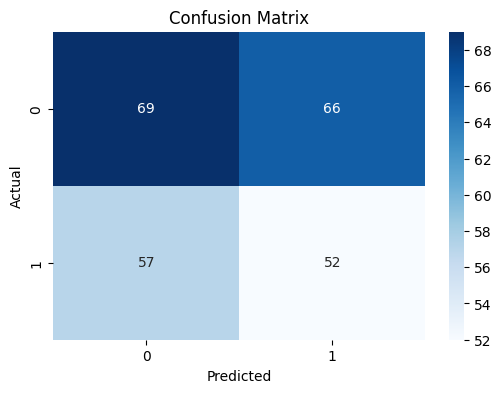

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4959016393442623, 0.4406779661016949, 0.47706422018348627, 0.4581497797356829, 16.993656513746622)
/--------------------------------------------------------------------/
TEAM
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 58979.6953 - mae: 230.2079 - val_loss: 33352.6875 - val_mae: 181.1837 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 57699.3008 - mae: 229.3869 - val_loss: 33881.5664 - val_mae: 182.6706 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 56725.3750 - mae: 228.4552 - val_loss: 34584.0430 - val_mae: 184.6818 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 55478.0078 - mae: 226.8867 - val_loss: 35515.1445 - val_mae: 187.2569 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 54089.9258 - mae: 224.8667 - val_loss: 37119.0039 - val_mae: 191.6116 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 52426.2344 - mae: 222.2282 - val_loss: 38434.1211 - val_mae: 195.0463 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 50604.2695 - ma

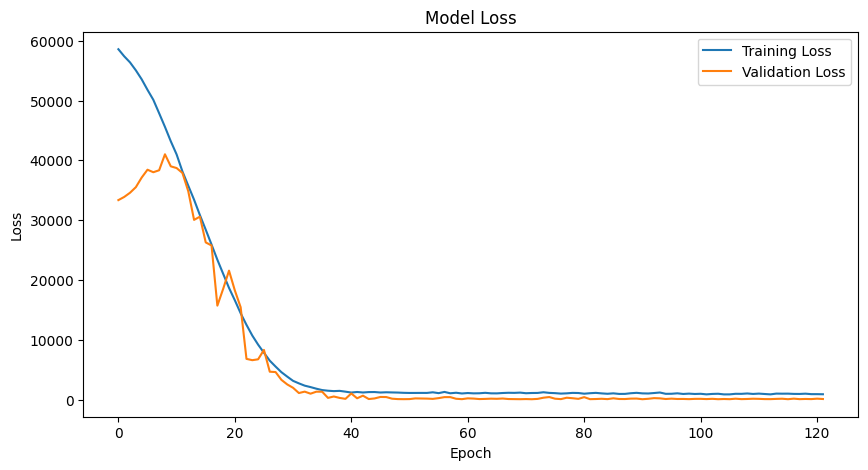

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Accuracy: 0.5656
Precision: 0.5649
Recall: 0.6016
F1-Score: 0.5827
RMSE: 10.692764


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


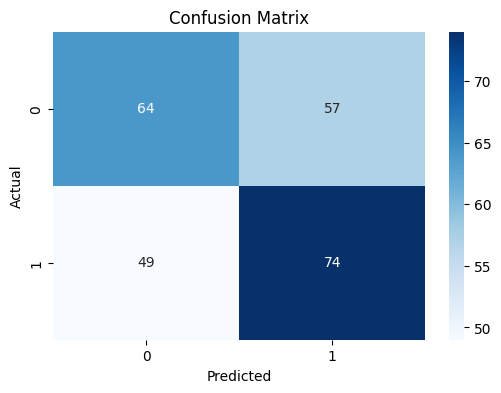

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5655737704918032, 0.5648854961832062, 0.6016260162601627, 0.5826771653543307, 10.692764499609929)
/--------------------------------------------------------------------/
SNPS
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 78446.2031 - mae: 272.8873 - val_loss: 204508.3438 - val_mae: 448.9618 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 77486.4375 - mae: 272.2975 - val_loss: 202622.6719 - val_mae: 446.8890 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 76519.2266 - mae: 271.3657 - val_loss: 198787.2188 - val_mae: 442.6628 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 75361.2578 - mae: 269.9225 - val_loss: 191947.8438 - val_mae: 435.0138 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 73796.6250 - mae: 267.7391 - val_loss: 180569.6875 - val_mae: 421.9158 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 72211.9609 - mae: 265.3837 - val_loss: 173748.9219 - val_mae: 413.7641 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 70100.210

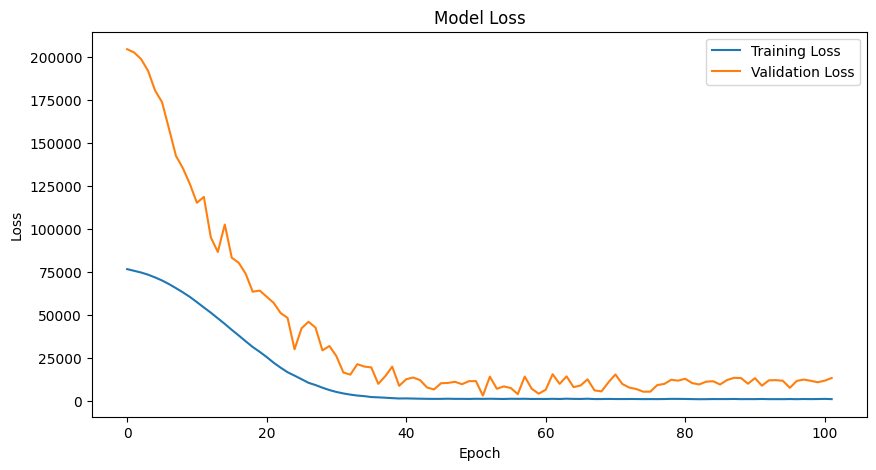

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy: 0.5000
Precision: 0.5231
Recall: 0.5312
F1-Score: 0.5271
RMSE: 127.897614


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


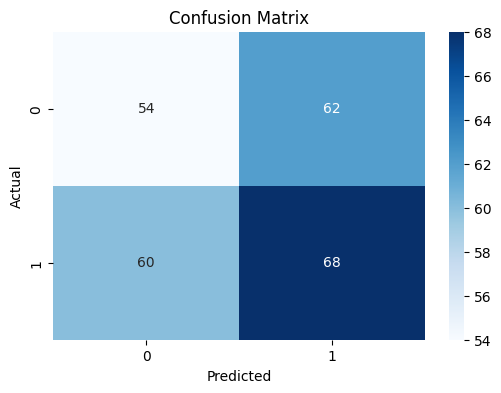

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5, 0.5230769230769231, 0.53125, 0.5271317829457365, 127.8976139905558)
/--------------------------------------------------------------------/
VRSK
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 34601.0625 - mae: 185.1799 - val_loss: 50613.5859 - val_mae: 224.2647 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 34365.0781 - mae: 184.6348 - val_loss: 50028.2031 - val_mae: 222.9608 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 33983.8047 - mae: 183.8022 - val_loss: 49114.7148 - val_mae: 220.9442 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 33456.4453 - mae: 182.4328 - val_loss: 47276.9258 - val_mae: 216.8345 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 32858.7070 - mae: 180.9229 - val_loss: 43662.3828 - val_mae: 208.6004 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 31946.7715 - mae: 178.4521 - val_loss: 39504.3555 - val_mae: 198.5472 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 30979.7812 - ma

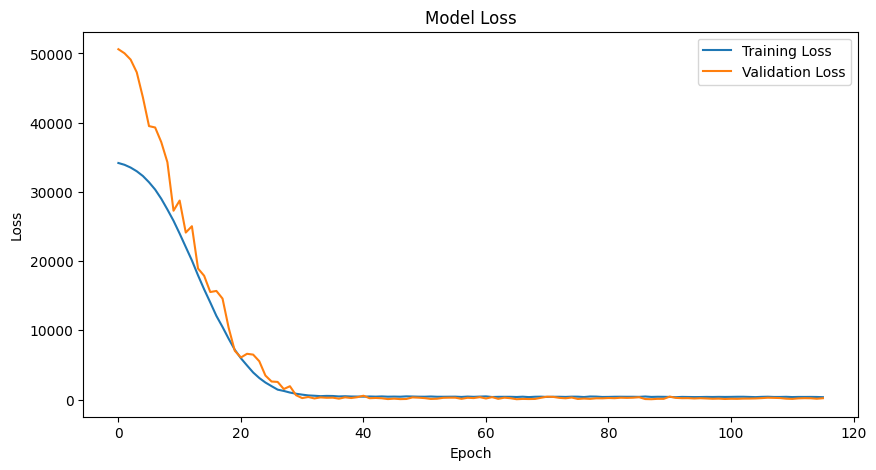

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy: 0.5082
Precision: 0.5447
Recall: 0.5115
F1-Score: 0.5276
RMSE: 30.419187


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


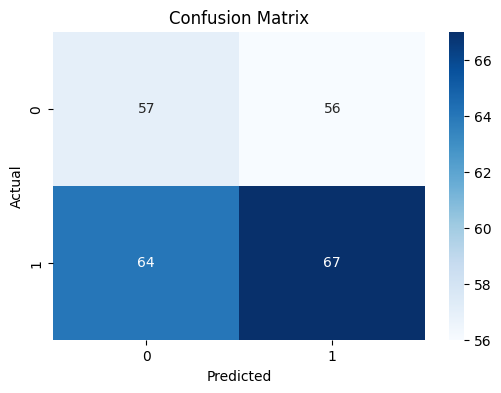

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5081967213114754, 0.5447154471544715, 0.5114503816793893, 0.5275590551181102, 30.419186702003717)
/--------------------------------------------------------------------/
AMD
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - loss: 7975.7671 - mae: 86.2407 - val_loss: 12004.0625 - val_mae: 108.7332 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7662.8418 - mae: 85.5828 - val_loss: 11732.1357 - val_mae: 107.4912 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7421.3179 - mae: 84.6765 - val_loss: 11202.7402 - val_mae: 105.0640 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7149.2432 - mae: 83.4446 - val_loss: 10517.5059 - val_mae: 101.8420 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6795.7974 - mae: 81.5770 - val_loss: 9550.9150 - val_mae: 97.0796 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6439.9863 - mae: 79.5059 - val_loss: 8645.0791 - val_mae: 92.5337 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5975.1104 - mae: 76.6317 - val_

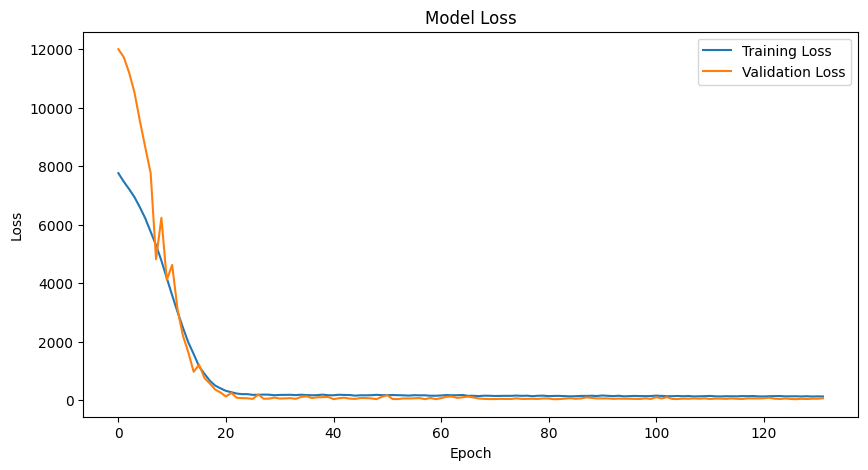

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.4590
Precision: 0.4322
Recall: 0.4397
F1-Score: 0.4359
RMSE: 21.074077


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


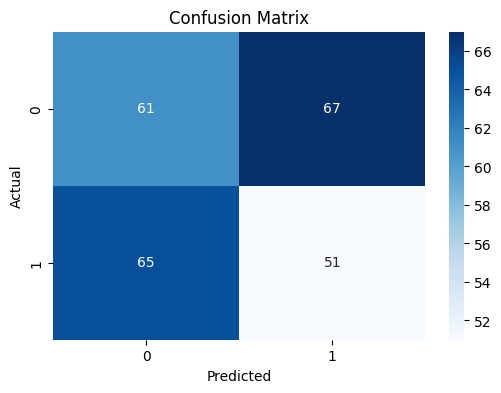

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.45901639344262296, 0.4322033898305085, 0.4396551724137931, 0.4358974358974359, 21.07407663794413)
/--------------------------------------------------------------------/
CTSH
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 5061.6328 - mae: 70.5597 - val_loss: 4360.0439 - val_mae: 65.8757 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4934.7778 - mae: 69.9189 - val_loss: 4335.6772 - val_mae: 65.6975 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4800.2568 - mae: 69.0711 - val_loss: 4311.1401 - val_mae: 65.5315 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4652.1230 - mae: 67.9985 - val_loss: 4175.1997 - val_mae: 64.5162 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4413.3501 - mae: 66.2450 - val_loss: 4064.6821 - val_mae: 63.7193 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4164.0747 - mae: 64.3277 - val_loss: 3710.2078 - val_mae: 60.8555 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3805.1926 - mae: 61.4372 - val_loss: 33

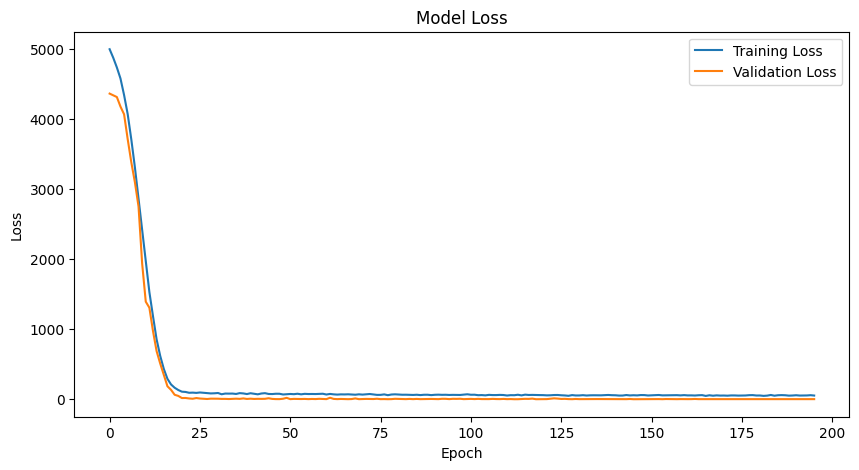

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.5451
Precision: 0.5610
Recall: 0.5476
F1-Score: 0.5542
RMSE: 1.856810


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


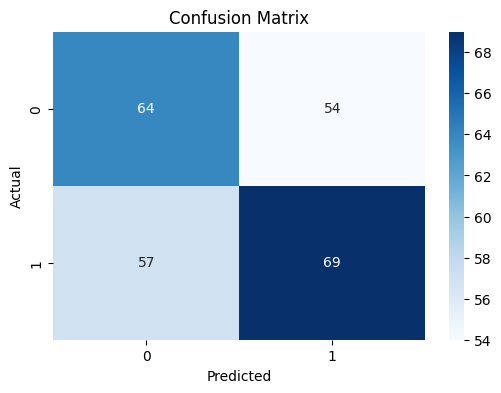

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5450819672131147, 0.5609756097560976, 0.5476190476190477, 0.5542168674698796, 1.8568099342809767)
/--------------------------------------------------------------------/
AMAT
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 11273.2803 - mae: 102.1788 - val_loss: 18959.5352 - val_mae: 137.0268 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 10842.8467 - mae: 101.3777 - val_loss: 18844.5059 - val_mae: 136.6263 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 10513.2363 - mae: 100.5142 - val_loss: 18183.0547 - val_mae: 134.2340 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 10108.4658 - mae: 99.0914 - val_loss: 16921.9062 - val_mae: 129.4955 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9672.4219 - mae: 97.2688 - val_loss: 15158.2510 - val_mae: 122.5929 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9127.4023 - mae: 94.7077 - val_loss: 13229.4365 - val_mae: 114.6682 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8573.9365 - mae: 91.

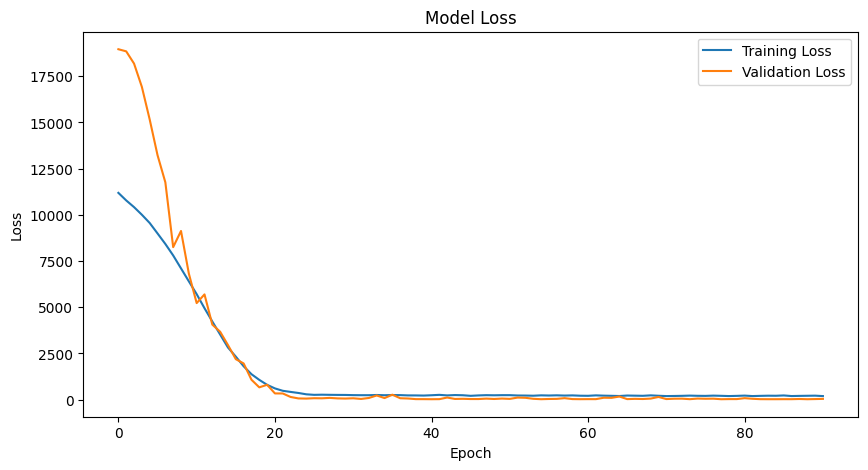

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.5082
Precision: 0.5132
Recall: 0.6290
F1-Score: 0.5652
RMSE: 43.120630


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


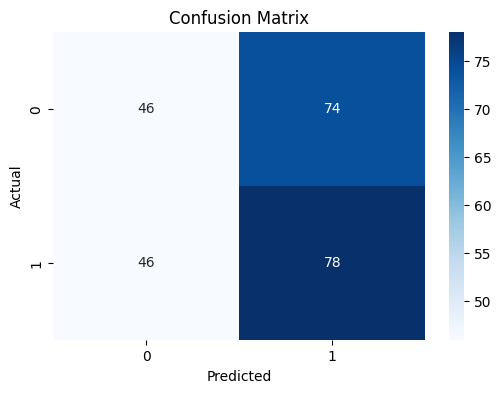

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5081967213114754, 0.5131578947368421, 0.6290322580645161, 0.5652173913043479, 43.12062956170522)
/--------------------------------------------------------------------/
AXON
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 19107.3008 - mae: 133.3976 - val_loss: 44357.3594 - val_mae: 209.7992 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18545.0352 - mae: 132.6902 - val_loss: 43743.5664 - val_mae: 208.3374 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 18087.6230 - mae: 131.7837 - val_loss: 42195.1055 - val_mae: 204.6275 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17515.9902 - mae: 130.2606 - val_loss: 40184.1797 - val_mae: 199.7357 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16880.5195 - mae: 128.3609 - val_loss: 36513.6680 - val_mae: 190.3823 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16073.7100 - mae: 125.5921 - val_loss: 33011.9766 - val_mae: 180.9996 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 15325.2188 - ma

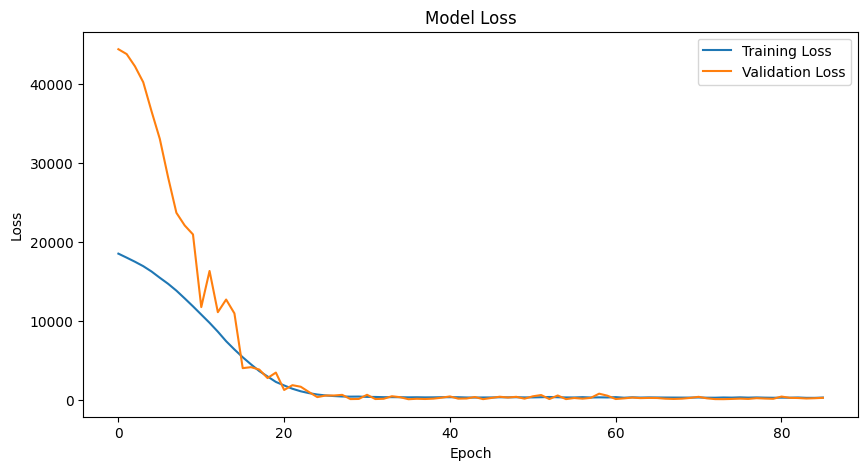

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.4877
Precision: 0.5227
Recall: 0.5267
F1-Score: 0.5247
RMSE: 180.475493


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


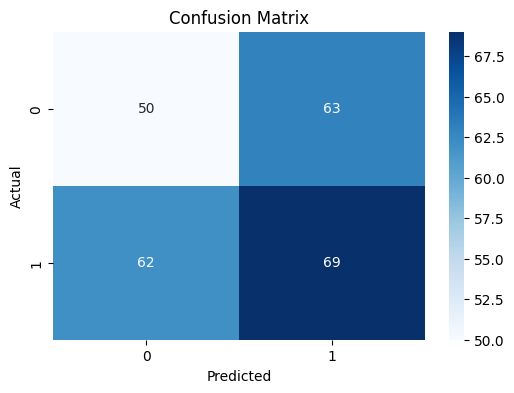

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.48770491803278687, 0.5227272727272727, 0.5267175572519084, 0.5247148288973383, 180.4754928959096)
/--------------------------------------------------------------------/
NFLX
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 199004.5781 - mae: 425.7483 - val_loss: 165633.8125 - val_mae: 403.7638 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 196922.7188 - mae: 425.0872 - val_loss: 164224.8438 - val_mae: 402.0526 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 194792.4844 - mae: 423.9730 - val_loss: 164091.7969 - val_mae: 401.9995 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 192286.9844 - mae: 422.3556 - val_loss: 163869.9375 - val_mae: 402.0135 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 189524.9375 - mae: 420.3657 - val_loss: 162709.6562 - val_mae: 400.9538 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 185955.8594 - mae: 417.5082 - val_loss: 159658.9688 - val_mae: 397.5611 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 182

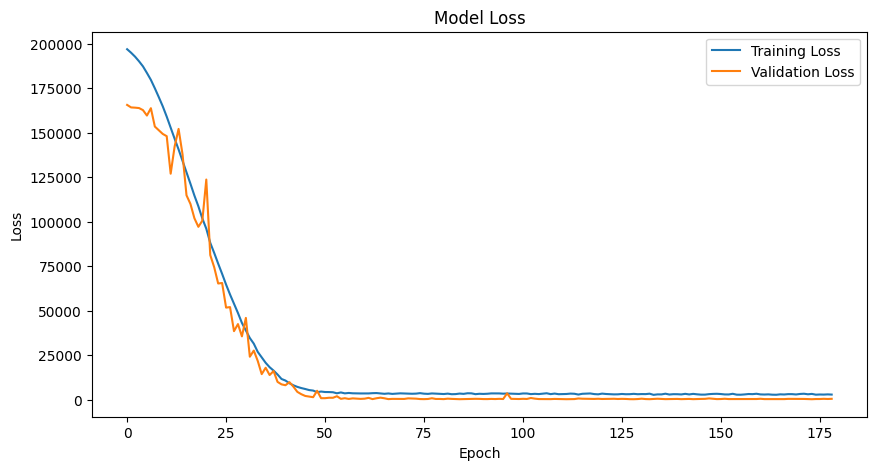

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.5000
Precision: 0.5344
Recall: 0.5344
F1-Score: 0.5344
RMSE: 80.797447


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


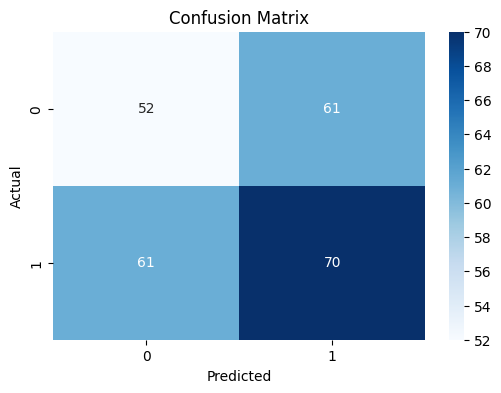

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5, 0.5343511450381679, 0.5343511450381679, 0.5343511450381679, 80.79744710734518)
/--------------------------------------------------------------------/
DXCM
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 10661.9258 - mae: 101.2530 - val_loss: 12753.3457 - val_mae: 111.9849 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 10397.4258 - mae: 100.6366 - val_loss: 12691.5537 - val_mae: 111.7252 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 10149.5771 - mae: 99.7469 - val_loss: 12492.2266 - val_mae: 110.8565 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9883.9590 - mae: 98.6536 - val_loss: 12038.5518 - val_mae: 108.8927 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9489.8525 - mae: 96.8886 - val_loss: 10599.2266 - val_mae: 102.3496 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9039.5527 - mae: 94.5995 - val_loss: 9813.9512 - val_mae: 98.4363 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8442.7559 - mae: 91.4273

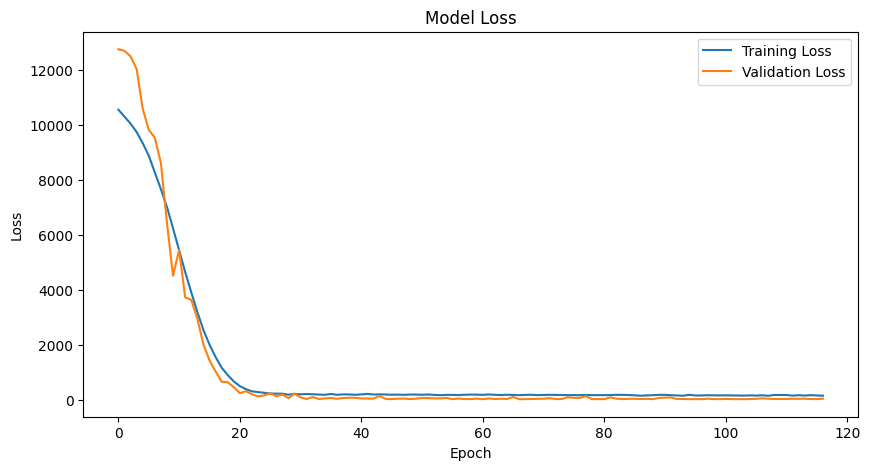

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.4877
Precision: 0.4915
Recall: 0.4715
F1-Score: 0.4813
RMSE: 6.808338


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


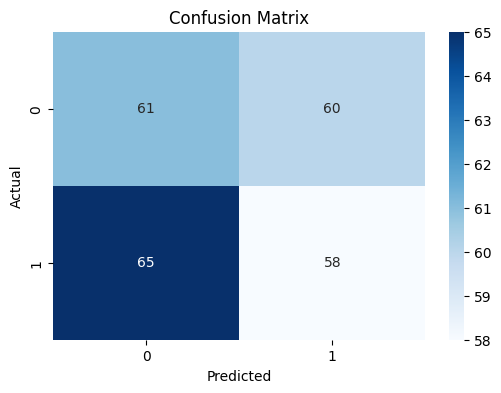

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.48770491803278687, 0.4915254237288136, 0.4715447154471545, 0.48132780082987553, 6.808337692729276)
/--------------------------------------------------------------------/
CSGP
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 5968.0376 - mae: 76.6684 - val_loss: 6344.7051 - val_mae: 79.3975 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5862.1255 - mae: 76.2068 - val_loss: 6275.6587 - val_mae: 78.9758 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5730.6050 - mae: 75.4413 - val_loss: 6096.1587 - val_mae: 77.8612 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5559.2109 - mae: 74.3597 - val_loss: 5704.2090 - val_mae: 75.3912 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5317.4277 - mae: 72.7303 - val_loss: 5442.7720 - val_mae: 73.6755 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5016.6826 - mae: 70.6186 - val_loss: 4803.4326 - val_mae: 69.2185 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4655.6602 - mae: 67.9920 - val_loss: 45

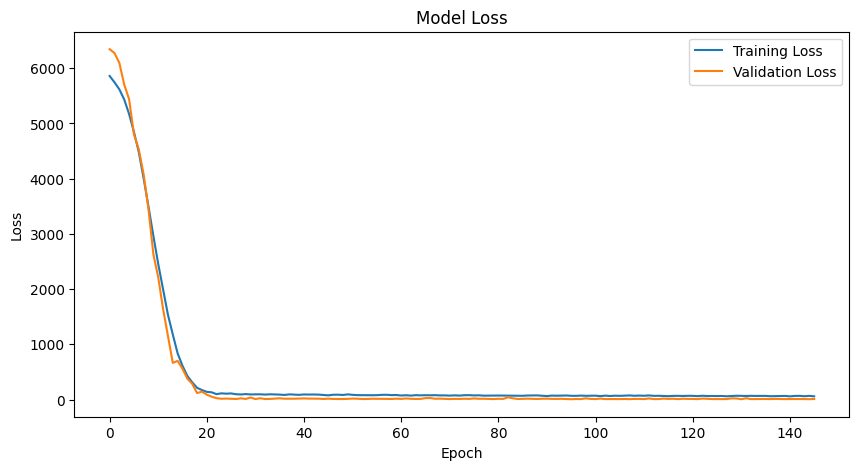

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.4877
Precision: 0.5039
Recall: 0.5079
F1-Score: 0.5059
RMSE: 2.800409


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


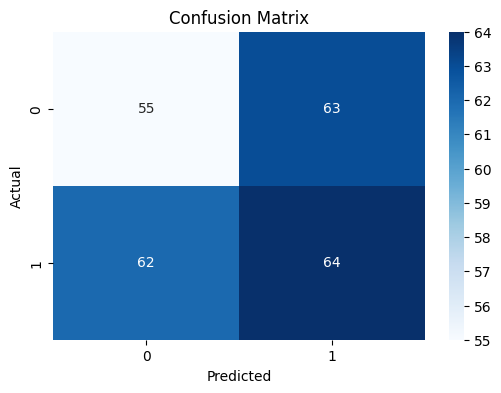

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.48770491803278687, 0.5039370078740157, 0.5079365079365079, 0.5059288537549407, 2.8004089288376295)
/--------------------------------------------------------------------/
TSLA
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 50840.5117 - mae: 207.9438 - val_loss: 53236.3203 - val_mae: 228.0956 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 49605.5938 - mae: 207.3510 - val_loss: 52110.8672 - val_mae: 225.6751 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 48422.7109 - mae: 206.0784 - val_loss: 51151.3516 - val_mae: 223.7742 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 47172.1562 - mae: 204.5620 - val_loss: 48936.3984 - val_mae: 219.0135 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 45623.7188 - mae: 202.3448 - val_loss: 46752.2656 - val_mae: 214.5685 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 44114.7188 - mae: 200.0483 - val_loss: 44552.8906 - val_mae: 209.6772 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 42120.6875 - ma

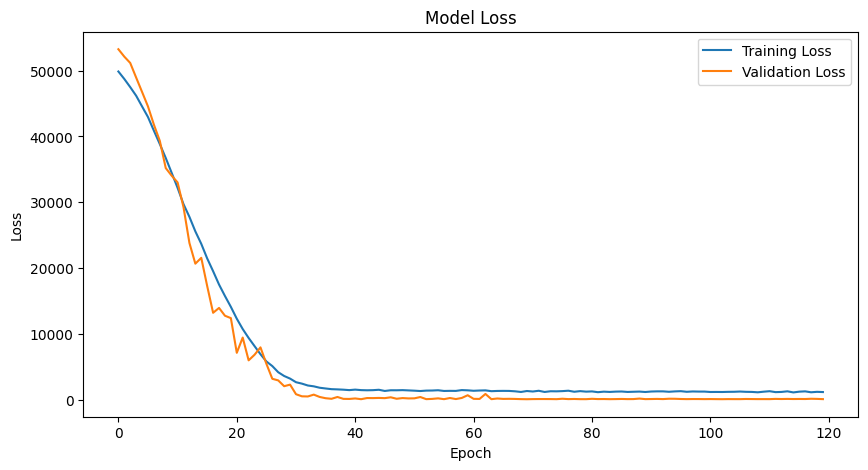

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Accuracy: 0.4959
Precision: 0.5130
Recall: 0.4683
F1-Score: 0.4896
RMSE: 36.474127


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


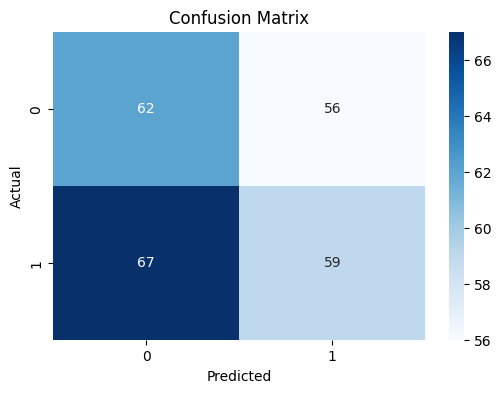

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4959016393442623, 0.5130434782608696, 0.46825396825396826, 0.4896265560165975, 36.47412684781695)
/--------------------------------------------------------------------/
DASH
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 16526.5742 - mae: 116.7007 - val_loss: 6753.2407 - val_mae: 81.6141 - learning_rate: 0.0010
Epoch 2/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 15829.6738 - mae: 116.2028 - val_loss: 6481.2461 - val_mae: 79.9521 - learning_rate: 0.0010
Epoch 3/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 15309.6104 - mae: 115.4339 - val_loss: 6422.1250 - val_mae: 79.6367 - learning_rate: 0.0010
Epoch 4/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 14905.8359 - mae: 114.7509 - val_loss: 6832.7627 - val_mae: 82.2380 - learning_rate: 0.0010
Epoch 5/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 14306.1768 - mae: 113.2632 - val_loss: 7614.7861 - val_mae: 86.8651 - learning_rate: 0.0010
Epoch 6/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 13771.2852 - mae: 111.7171 - val_loss: 8647.1123 - val_mae: 92.6326 - learning_rate: 0.0010
Epoch 7/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 13169.0205 - mae: 109.9322 

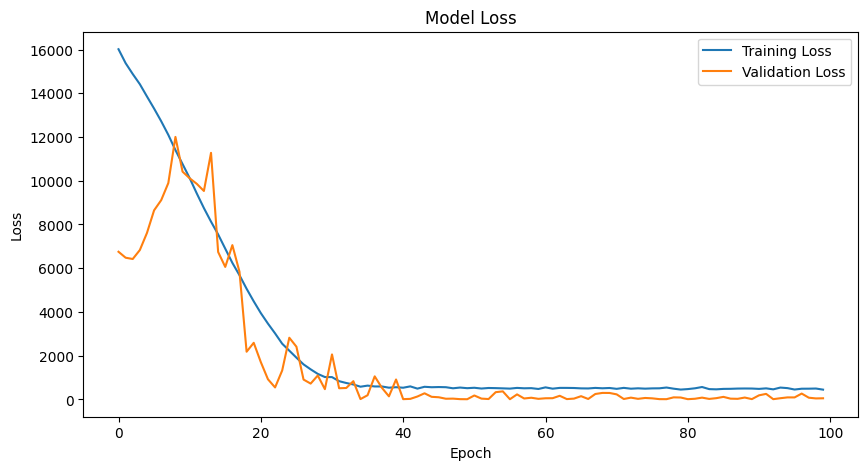

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Accuracy: 0.4877
Precision: 0.5111
Recall: 0.5391
F1-Score: 0.5247
RMSE: 7.851524


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


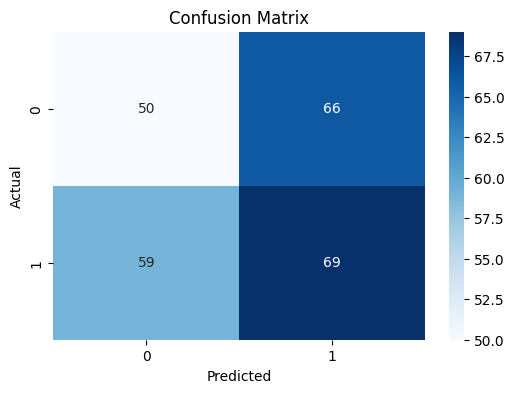

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.48770491803278687, 0.5111111111111111, 0.5390625, 0.5247148288973384, 7.851524473197901)
/--------------------------------------------------------------------/
CDW
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 26251.1211 - mae: 159.3581 - val_loss: 38139.7695 - val_mae: 194.5343 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 25825.3789 - mae: 158.6987 - val_loss: 37336.4766 - val_mae: 192.4676 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 25408.2422 - mae: 157.8977 - val_loss: 36136.0938 - val_mae: 189.3377 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 24854.3262 - mae: 156.5573 - val_loss: 34054.6953 - val_mae: 183.8860 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 24171.7070 - mae: 154.6749 - val_loss: 31762.4238 - val_mae: 177.6895 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 23419.0938 - mae: 152.4469 - val_loss: 29109.5840 - val_mae: 170.1598 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 22419.2207 - ma

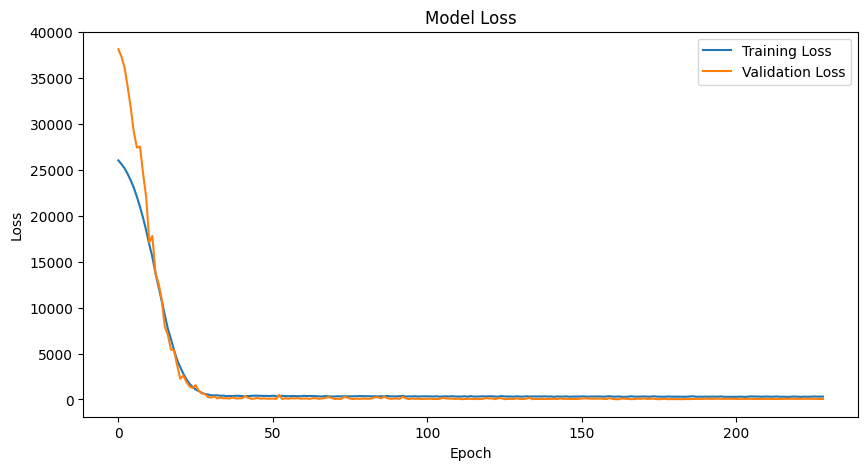

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.4467
Precision: 0.4576
Recall: 0.4320
F1-Score: 0.4444
RMSE: 14.279883


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


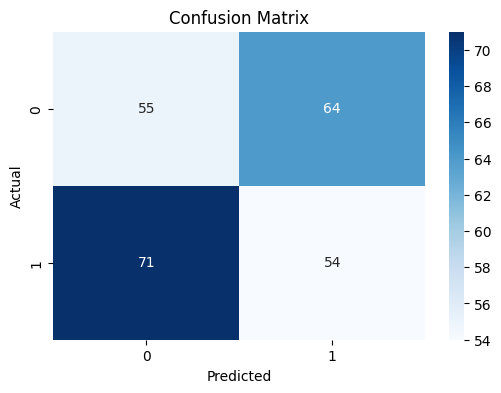

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.44672131147540983, 0.4576271186440678, 0.432, 0.4444444444444444, 14.279882784833088)
/--------------------------------------------------------------------/
BKNG
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 4320263.5000 - mae: 2057.0735 - val_loss: 8539777.0000 - val_mae: 2909.2639 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4315016.5000 - mae: 2056.3518 - val_loss: 8532690.0000 - val_mae: 2908.0632 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4309661.5000 - mae: 2055.5947 - val_loss: 8520639.0000 - val_mae: 2906.0657 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4301977.5000 - mae: 2054.1870 - val_loss: 8483783.0000 - val_mae: 2899.8354 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4291151.5000 - mae: 2052.0989 - val_loss: 8420534.0000 - val_mae: 2889.2322 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4278679.5000 - mae: 2049.6167 - val_loss: 8336282.0000 - val_mae: 2874.5000 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 

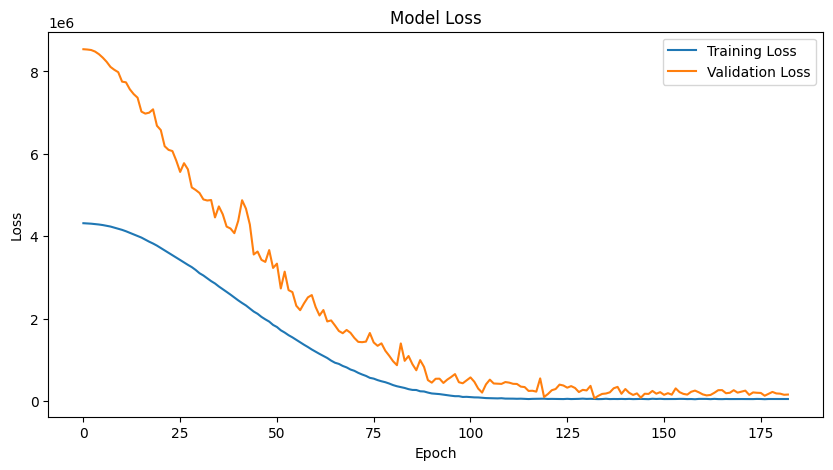

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step
Accuracy: 0.5492
Precision: 0.6190
Recall: 0.5571
F1-Score: 0.5865
RMSE: 1127.861715


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


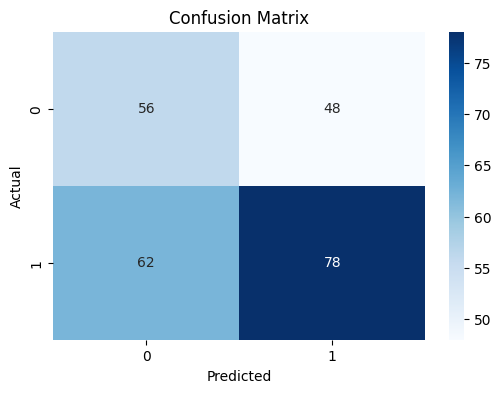

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.5491803278688525, 0.6190476190476191, 0.5571428571428572, 0.5864661654135339, 1127.8617148978121)
/--------------------------------------------------------------------/
MDLZ
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 3617.0808 - mae: 59.9826 - val_loss: 5017.5039 - val_mae: 70.7540 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3541.8984 - mae: 59.4104 - val_loss: 4917.7129 - val_mae: 70.0456 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3451.2739 - mae: 58.6609 - val_loss: 4693.1436 - val_mae: 68.4241 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3326.2632 - mae: 57.5826 - val_loss: 4321.9282 - val_mae: 65.6561 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3155.9031 - mae: 56.0803 - val_loss: 3956.7546 - val_mae: 62.8114 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2930.7634 - mae: 53.9973 - val_loss: 3567.7883 - val_mae: 59.6528 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2651.5864 - mae: 51.3460 - val_loss: 30

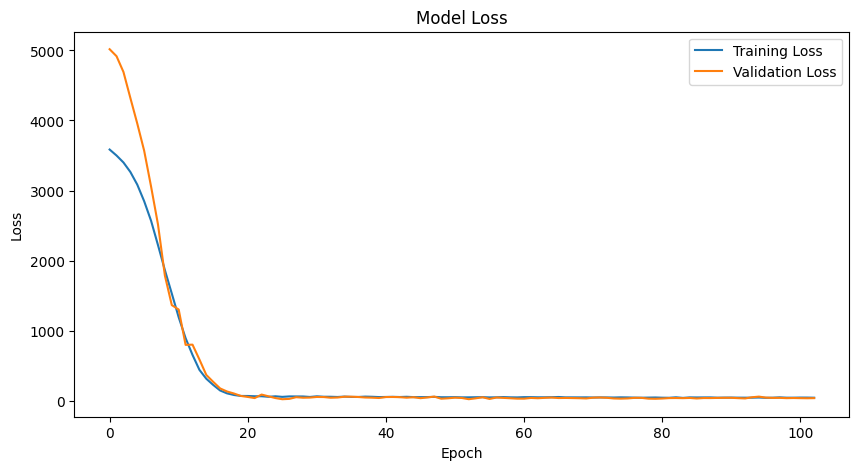

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Accuracy: 0.4795
Precision: 0.4370
Recall: 0.4643
F1-Score: 0.4502
RMSE: 3.510272


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


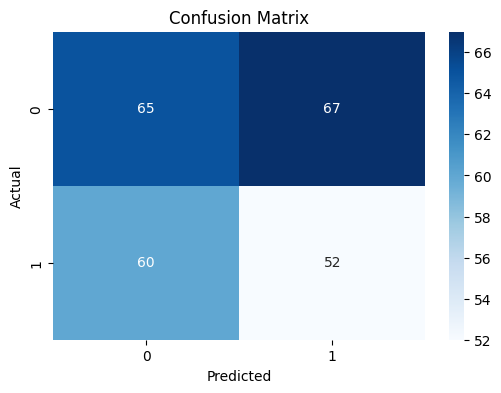

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.47950819672131145, 0.4369747899159664, 0.4642857142857143, 0.45021645021645024, 3.5102720606104145)
/--------------------------------------------------------------------/
CCEP
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 2547.3574 - mae: 50.0641 - val_loss: 3838.7341 - val_mae: 61.8973 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2456.4893 - mae: 49.3575 - val_loss: 3716.2012 - val_mae: 60.9000 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2367.3347 - mae: 48.5226 - val_loss: 3553.8601 - val_mae: 59.5532 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2284.7349 - mae: 47.6628 - val_loss: 3319.8979 - val_mae: 57.5667 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2135.1826 - mae: 46.0537 - val_loss: 2985.7339 - val_mae: 54.5843 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1937.4639 - mae: 43.8446 - val_loss: 2535.7837 - val_mae: 50.2964 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1723.9865 - mae: 41.3160 - val_loss: 19

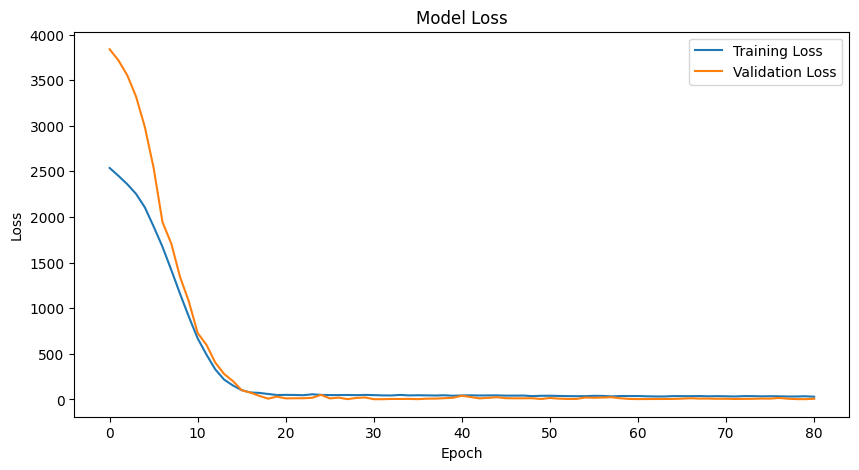

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Accuracy: 0.4713
Precision: 0.5040
Recall: 0.4846
F1-Score: 0.4941
RMSE: 10.947106


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


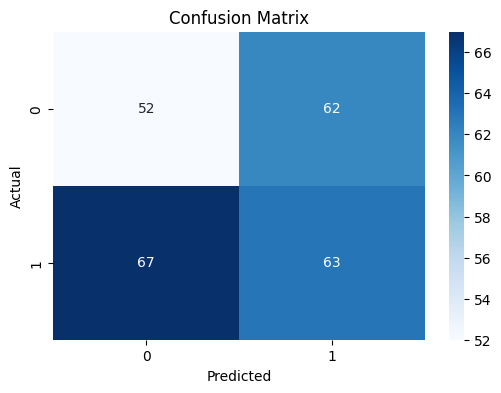

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.4713114754098361, 0.504, 0.4846153846153846, 0.4941176470588235, 10.947106136484349)
/--------------------------------------------------------------------/
CEG
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 6048.1504 - mae: 76.3538 - val_loss: 12879.3262 - val_mae: 113.3350 - learning_rate: 0.0010
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5958.2036 - mae: 75.9861 - val_loss: 12785.9424 - val_mae: 112.9224 - learning_rate: 0.0010
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5857.6226 - mae: 75.5739 - val_loss: 12689.5410 - val_mae: 112.4953 - learning_rate: 0.0010
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5806.6885 - mae: 75.4337 - val_loss: 12569.9023 - val_mae: 111.9634 - learning_rate: 0.0010
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5716.8101 - mae: 75.0145 - val_loss: 12420.9268 - val_mae: 111.2971 - learning_rate: 0.0010
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5627.3037 - mae: 74.5003 - val_loss: 12141.5596 - val_mae: 110.0387 - learning_rate: 0.0010
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5527.9092 - mae: 73.9049 - 

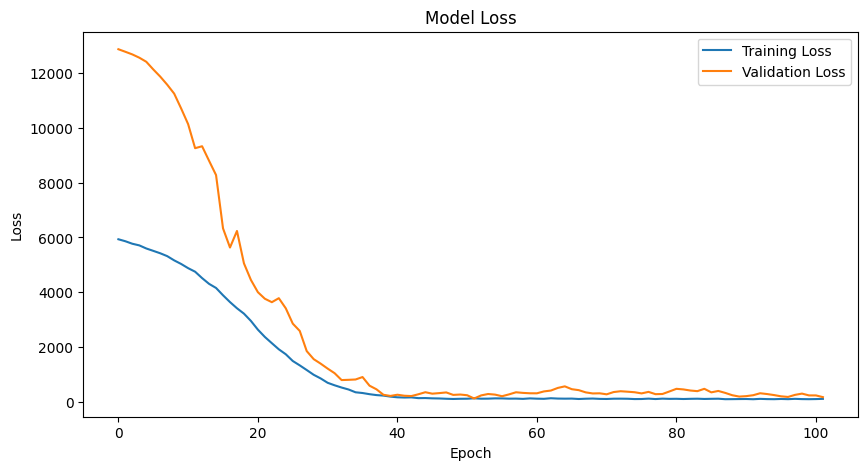

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.4959
Precision: 0.5446
Recall: 0.4586
F1-Score: 0.4980
RMSE: 107.004711


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


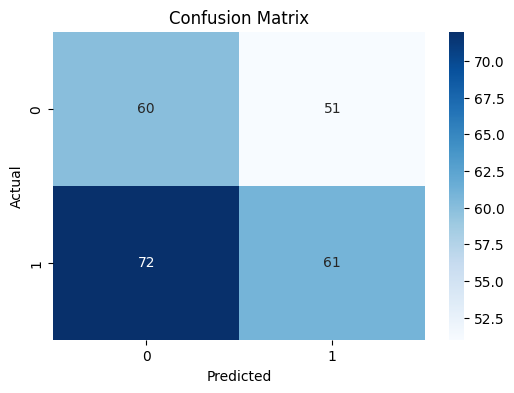

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4959016393442623, 0.5446428571428571, 0.45864661654135336, 0.4979591836734694, 107.00471118387958)
/--------------------------------------------------------------------/
FAST
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 614.7878 - mae: 24.5882 - val_loss: 788.8384 - val_mae: 28.0396 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 587.9979 - mae: 24.1261 - val_loss: 756.3937 - val_mae: 27.4550 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 551.8188 - mae: 23.3892 - val_loss: 718.2156 - val_mae: 26.7492 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 506.4133 - mae: 22.3849 - val_loss: 614.6741 - val_mae: 24.7470 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 448.4132 - mae: 21.0104 - val_loss: 517.1998 - val_mae: 22.7029 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 371.4735 - mae: 19.0832 - val_loss: 377.8739 - val_mae: 19.4096 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 296.4244 - mae: 16.9805 - val_loss: 257.8004 - val_

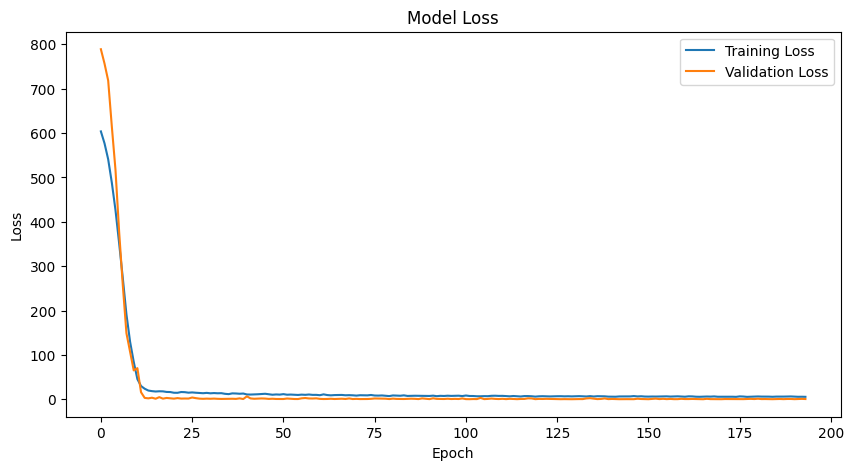

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Accuracy: 0.5492
Precision: 0.5286
Recall: 0.6271
F1-Score: 0.5736
RMSE: 5.251017


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


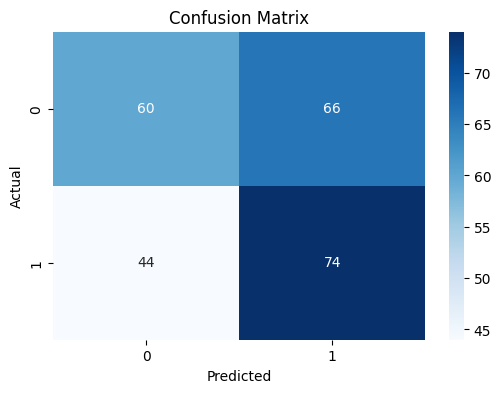

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5491803278688525, 0.5285714285714286, 0.6271186440677966, 0.5736434108527132, 5.251016731436233)
/--------------------------------------------------------------------/
NXPI
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 29162.4785 - mae: 167.3385 - val_loss: 37747.6523 - val_mae: 193.4425 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 28652.2617 - mae: 166.6251 - val_loss: 36855.9336 - val_mae: 191.1417 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 28168.7812 - mae: 165.8127 - val_loss: 35527.2305 - val_mae: 187.6999 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 27516.0078 - mae: 164.3456 - val_loss: 33977.1641 - val_mae: 183.6429 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 26766.2168 - mae: 162.4293 - val_loss: 32042.9473 - val_mae: 178.4182 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 25936.9141 - mae: 160.1245 - val_loss: 30036.4023 - val_mae: 172.7493 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 24878.4805 - ma

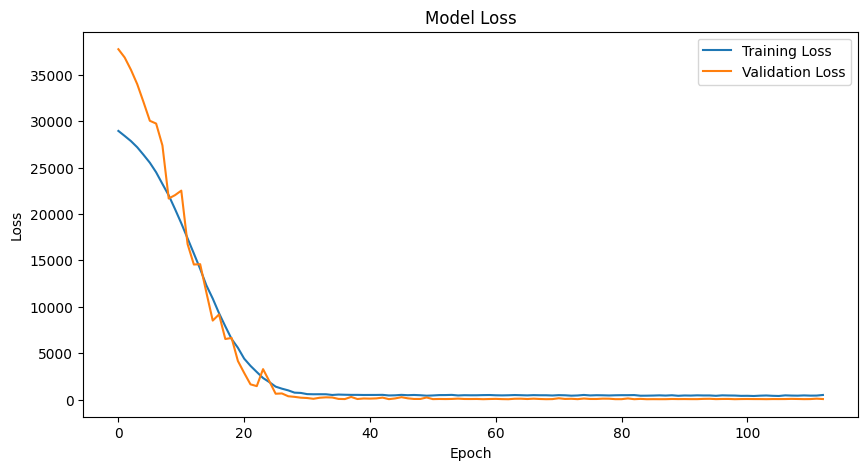

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.4631
Precision: 0.5085
Recall: 0.4511
F1-Score: 0.4781
RMSE: 21.921243


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


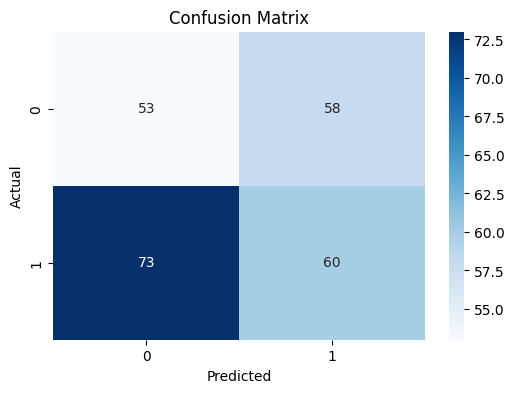

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.46311475409836067, 0.5084745762711864, 0.45112781954887216, 0.4780876494023904, 21.921243031433363)
/--------------------------------------------------------------------/
VRTX
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 62886.1133 - mae: 247.8446 - val_loss: 122267.9609 - val_mae: 349.0012 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 62328.1367 - mae: 247.2349 - val_loss: 121457.4844 - val_mae: 347.8404 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 61643.2148 - mae: 246.2226 - val_loss: 120097.1875 - val_mae: 345.8908 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 60960.5547 - mae: 245.2275 - val_loss: 116419.6328 - val_mae: 340.5869 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 59788.9492 - mae: 243.1639 - val_loss: 110301.3438 - val_mae: 331.5939 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 58503.1602 - mae: 240.7730 - val_loss: 99959.7812 - val_mae: 315.5642 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 57008.6641

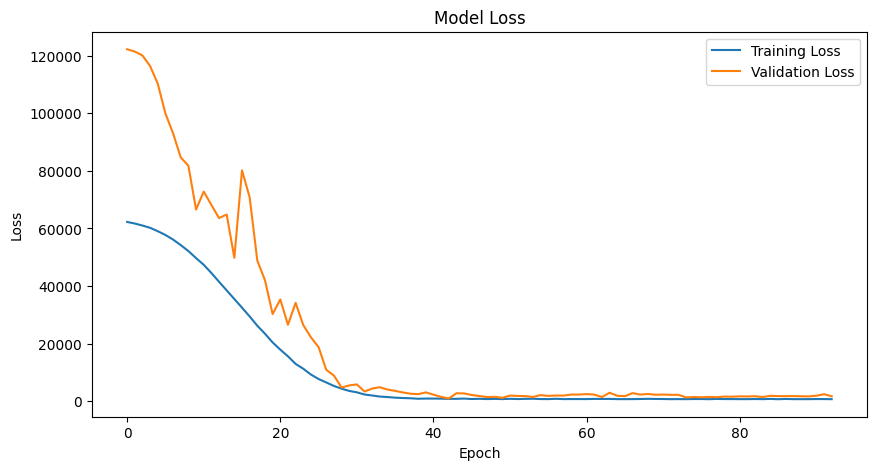

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.5123
Precision: 0.5667
Recall: 0.5037
F1-Score: 0.5333
RMSE: 124.734906


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


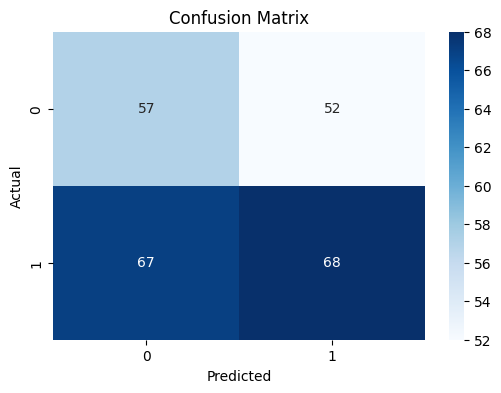

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5122950819672131, 0.5666666666666667, 0.5037037037037037, 0.5333333333333332, 124.73490649166119)
/--------------------------------------------------------------------/
PEP
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 24236.6973 - mae: 154.8714 - val_loss: 31507.8711 - val_mae: 177.2440 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 24029.4668 - mae: 154.3770 - val_loss: 30988.9727 - val_mae: 175.7866 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 23724.1602 - mae: 153.5806 - val_loss: 30261.1934 - val_mae: 173.7378 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 23325.4629 - mae: 152.3929 - val_loss: 29633.8457 - val_mae: 171.9757 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 22859.1816 - mae: 150.9579 - val_loss: 26659.5723 - val_mae: 163.0709 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 22192.2168 - mae: 148.7672 - val_loss: 24317.3516 - val_mae: 155.6813 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 21259.2930 - ma

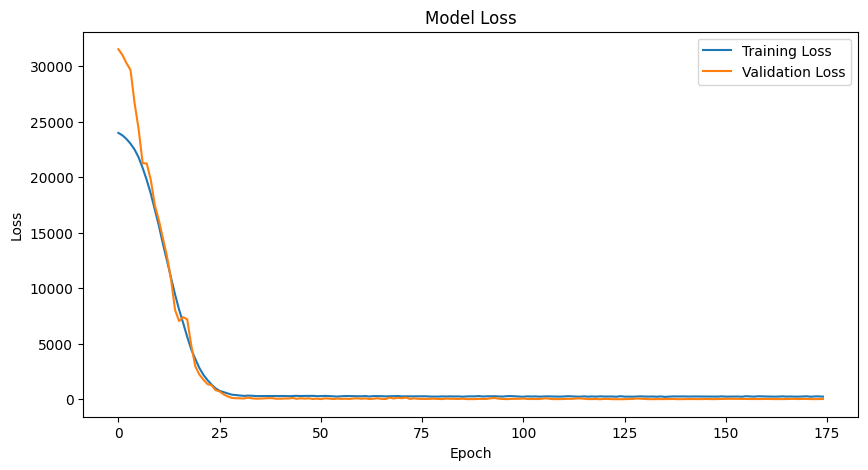

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.4877
Precision: 0.4737
Recall: 0.4538
F1-Score: 0.4635
RMSE: 3.371928


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


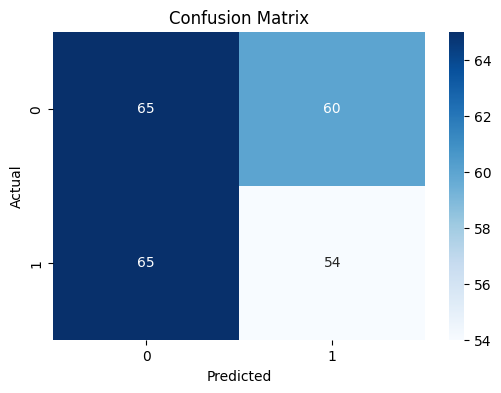

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.48770491803278687, 0.47368421052631576, 0.453781512605042, 0.463519313304721, 3.3719283501866983)
/--------------------------------------------------------------------/
CTAS
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 8581.6729 - mae: 91.5413 - val_loss: 15536.6182 - val_mae: 124.3082 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8406.7939 - mae: 91.0048 - val_loss: 15531.8184 - val_mae: 124.2910 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8217.6240 - mae: 90.1605 - val_loss: 15291.9824 - val_mae: 123.3342 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7971.0410 - mae: 88.9360 - val_loss: 14531.9355 - val_mae: 120.2623 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7680.7812 - mae: 87.3232 - val_loss: 13223.7695 - val_mae: 114.7547 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7320.5972 - mae: 85.2041 - val_loss: 11948.9004 - val_mae: 109.0179 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6867.0771 - mae: 82.5020 - 

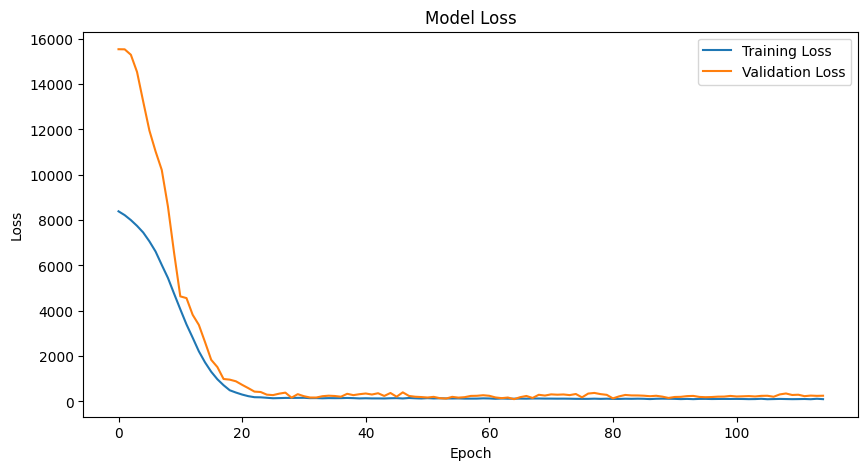

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Accuracy: 0.4303
Precision: 0.5238
Recall: 0.4552
F1-Score: 0.4871
RMSE: 67.163130


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


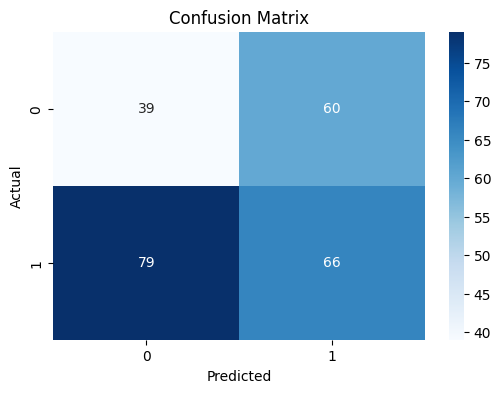

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.430327868852459, 0.5238095238095238, 0.45517241379310347, 0.48708487084870855, 67.16312962667328)
/--------------------------------------------------------------------/
META
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 62193.2930 - mae: 238.8441 - val_loss: 83396.6094 - val_mae: 285.6911 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 61128.4609 - mae: 238.1530 - val_loss: 82969.1328 - val_mae: 284.9839 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 60089.3047 - mae: 237.1254 - val_loss: 82236.6719 - val_mae: 283.9746 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 58771.7344 - mae: 235.4678 - val_loss: 81291.7891 - val_mae: 282.6374 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 57337.0000 - mae: 233.3867 - val_loss: 78420.0234 - val_mae: 278.0396 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 55707.2109 - mae: 230.8366 - val_loss: 73336.0234 - val_mae: 269.3539 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 53669.9883 - ma

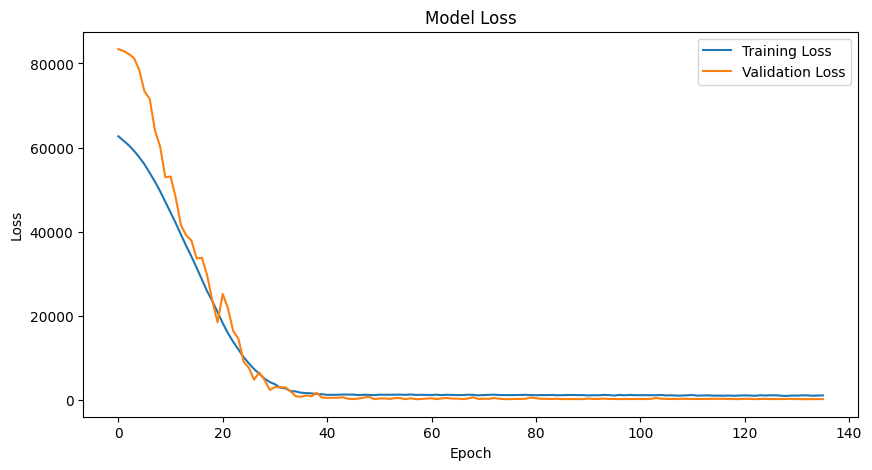

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Accuracy: 0.4836
Precision: 0.5161
Recall: 0.4923
F1-Score: 0.5039
RMSE: 158.055298


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


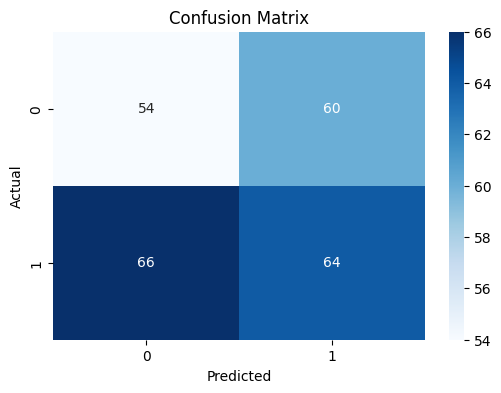

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.48360655737704916, 0.5161290322580645, 0.49230769230769234, 0.5039370078740157, 158.0552978825122)
/--------------------------------------------------------------------/
MAR
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - loss: 19919.4648 - mae: 138.6603 - val_loss: 35976.0586 - val_mae: 188.9390 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 19517.7441 - mae: 138.0095 - val_loss: 34929.5234 - val_mae: 186.1805 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 19113.8633 - mae: 136.9584 - val_loss: 33423.5625 - val_mae: 182.1670 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18700.8184 - mae: 135.7828 - val_loss: 31398.1992 - val_mae: 176.6359 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18145.7285 - mae: 133.9809 - val_loss: 29237.5156 - val_mae: 170.2770 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17488.2754 - mae: 131.6933 - val_loss: 27338.3242 - val_mae: 164.7392 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16717.1348 - m

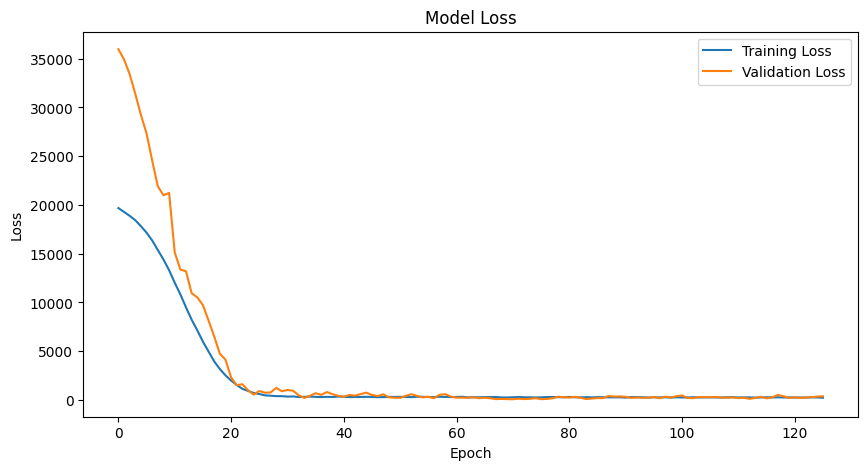

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Accuracy: 0.4713
Precision: 0.5299
Recall: 0.4559
F1-Score: 0.4901
RMSE: 55.503264


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


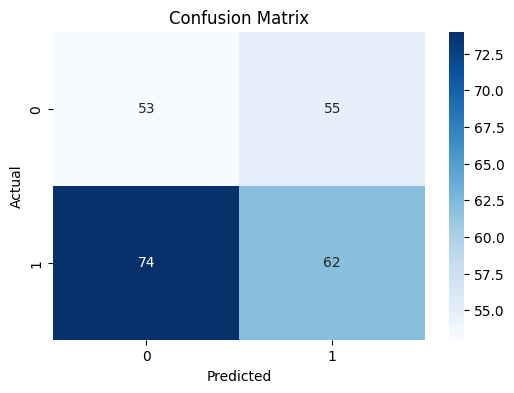

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.4713114754098361, 0.5299145299145299, 0.45588235294117646, 0.4901185770750988, 55.503264324393754)
/--------------------------------------------------------------------/
SHOP
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 8837.5254 - mae: 85.6952 - val_loss: 3473.8201 - val_mae: 58.2469 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8190.6152 - mae: 84.8791 - val_loss: 3300.1797 - val_mae: 56.8321 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7749.2266 - mae: 83.6726 - val_loss: 3600.5601 - val_mae: 59.5126 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7346.4624 - mae: 82.2787 - val_loss: 3567.3633 - val_mae: 59.4393 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6841.2842 - mae: 80.0497 - val_loss: 3928.5559 - val_mae: 62.3829 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6370.7681 - mae: 77.7940 - val_loss: 3908.7861 - val_mae: 62.2953 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5883.5801 - mae: 75.0348 - val_loss: 46

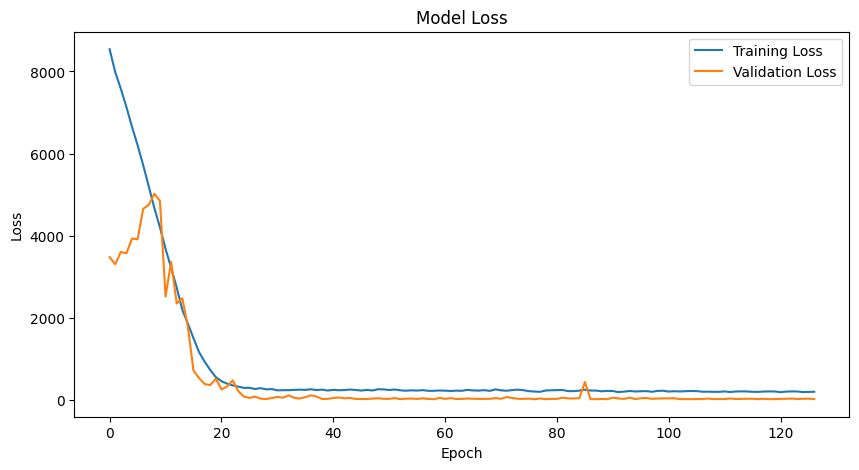

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.4795
Precision: 0.5118
Recall: 0.5000
F1-Score: 0.5058
RMSE: 6.880222


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


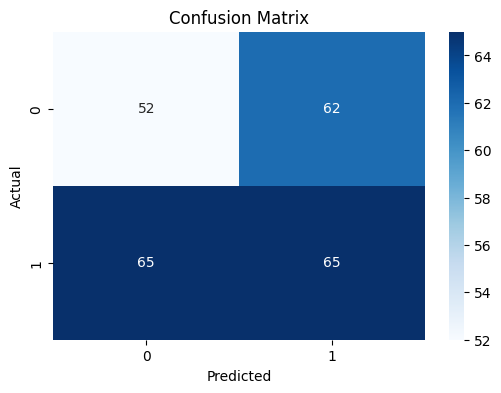

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.47950819672131145, 0.5118110236220472, 0.5, 0.5058365758754864, 6.880221991889092)
/--------------------------------------------------------------------/
MU
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 4517.8550 - mae: 65.9400 - val_loss: 4598.1982 - val_mae: 67.5145 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4339.5308 - mae: 65.1876 - val_loss: 4467.4561 - val_mae: 66.5524 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4213.5366 - mae: 64.4529 - val_loss: 4252.6963 - val_mae: 64.9809 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4030.0874 - mae: 63.1773 - val_loss: 4331.9434 - val_mae: 65.6631 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3820.9390 - mae: 61.4513 - val_loss: 3874.7715 - val_mae: 62.1060 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3565.5205 - mae: 59.3171 - val_loss: 3322.8555 - val_mae: 57.5109 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3278.1372 - mae: 56.7911 - val_loss: 32

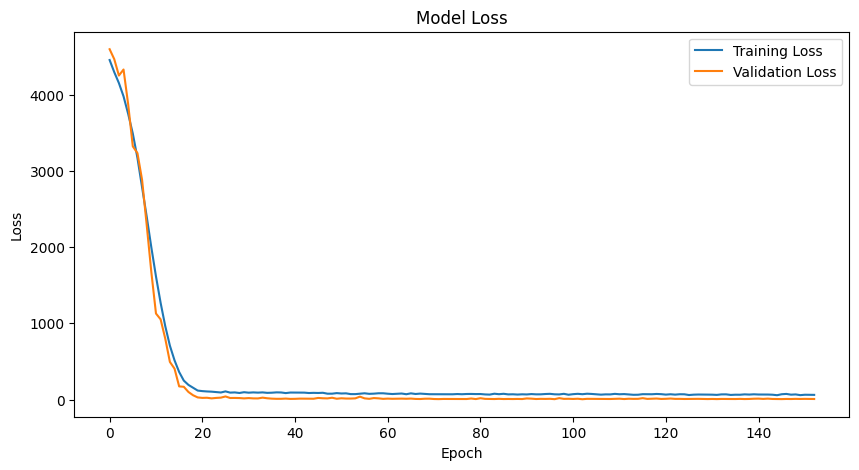

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Accuracy: 0.5410
Precision: 0.5625
Recall: 0.5625
F1-Score: 0.5625
RMSE: 19.502597


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


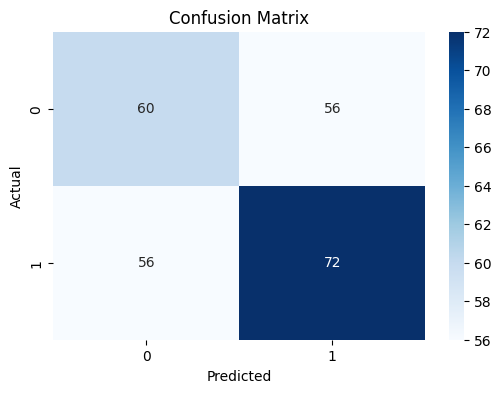

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5409836065573771, 0.5625, 0.5625, 0.5625, 19.5025971739825)
/--------------------------------------------------------------------/
ADBE
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 215456.2031 - mae: 453.4239 - val_loss: 251318.3281 - val_mae: 494.0176 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 214016.6250 - mae: 452.7798 - val_loss: 250479.7656 - val_mae: 493.2664 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 212695.1875 - mae: 451.9762 - val_loss: 248556.3750 - val_mae: 491.7093 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 210754.9688 - mae: 450.5376 - val_loss: 243774.7188 - val_mae: 487.6558 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 208297.5156 - mae: 448.5723 - val_loss: 238539.9844 - val_mae: 483.2703 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 205433.0000 - mae: 446.1326 - val_loss: 231244.9531 - val_mae: 476.4791 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 201

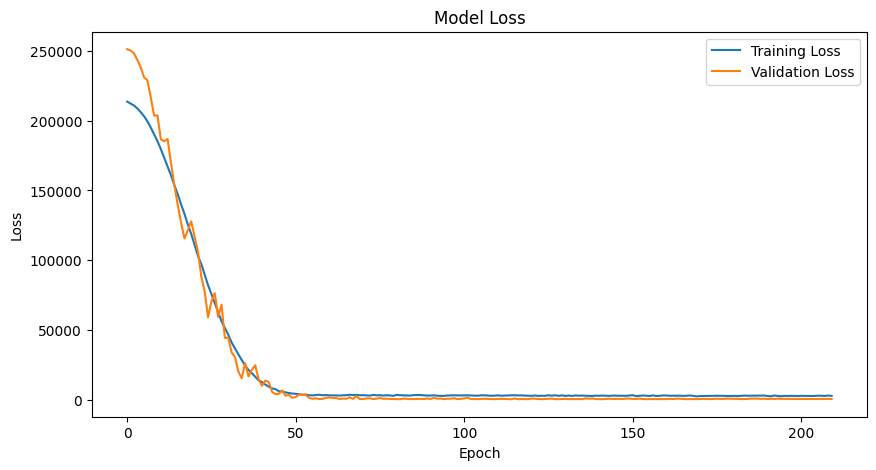

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy: 0.5041
Precision: 0.4844
Recall: 0.5299
F1-Score: 0.5061
RMSE: 20.136823


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


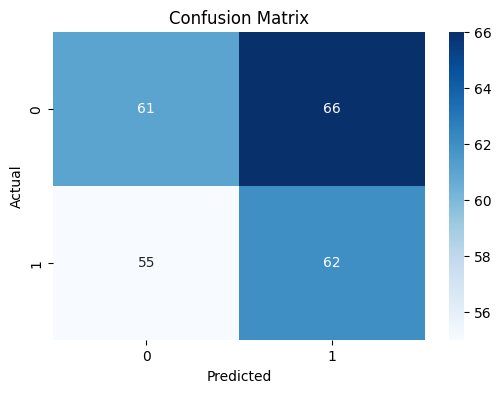

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5040983606557377, 0.484375, 0.5299145299145299, 0.5061224489795918, 20.136822655254026)
/--------------------------------------------------------------------/
PANW
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 4807.6895 - mae: 66.6501 - val_loss: 13894.7305 - val_mae: 116.7271 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4570.0371 - mae: 66.2205 - val_loss: 13507.3398 - val_mae: 115.0680 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4368.6436 - mae: 65.1841 - val_loss: 13050.9541 - val_mae: 113.1318 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4159.5127 - mae: 63.8775 - val_loss: 12404.8164 - val_mae: 110.3721 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3919.3494 - mae: 62.1238 - val_loss: 11258.2373 - val_mae: 105.2166 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3651.4861 - mae: 59.9441 - val_loss: 9911.6055 - val_mae: 98.6929 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3364.9424 - mae: 57.4300 - va

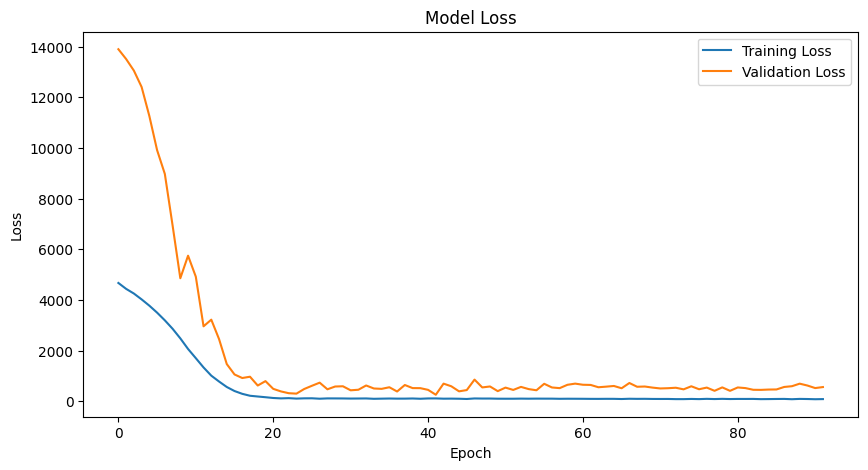

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Accuracy: 0.4590
Precision: 0.5225
Recall: 0.4234
F1-Score: 0.4677
RMSE: 58.743065


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


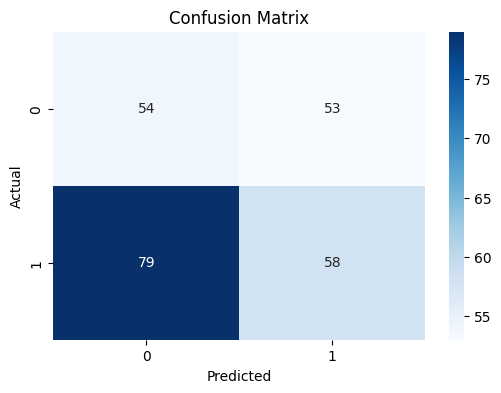

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.45901639344262296, 0.5225225225225225, 0.4233576642335766, 0.467741935483871, 58.743064945428884)
/--------------------------------------------------------------------/
ON
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 2352.2397 - mae: 45.2516 - val_loss: 7307.5400 - val_mae: 84.8504 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2140.0186 - mae: 44.6717 - val_loss: 6814.4917 - val_mae: 81.9199 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2010.3208 - mae: 43.8721 - val_loss: 6048.5049 - val_mae: 77.1590 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1866.3584 - mae: 42.5076 - val_loss: 5215.7554 - val_mae: 71.5871 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1717.2477 - mae: 40.8677 - val_loss: 4827.9639 - val_mae: 68.8431 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1573.6584 - mae: 39.0731 - val_loss: 3875.0439 - val_mae: 61.5706 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1403.2678 - mae: 36.7867 - val_loss: 34

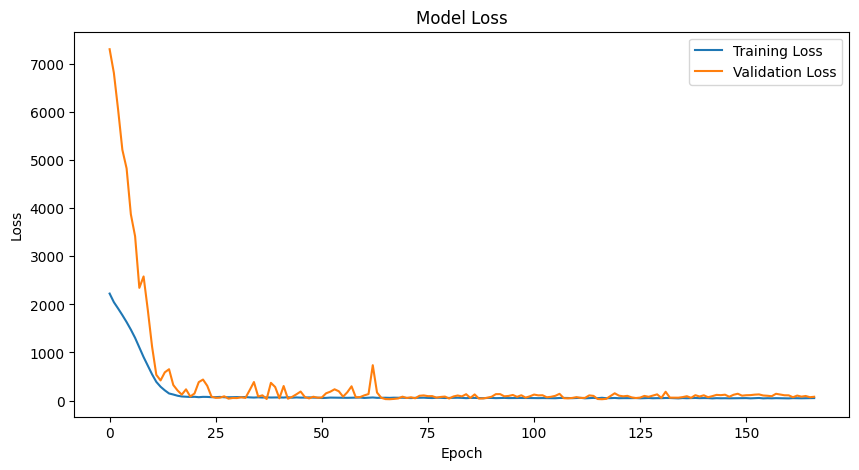

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy: 0.5082
Precision: 0.5041
Recall: 0.5041
F1-Score: 0.5041
RMSE: 5.201260


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


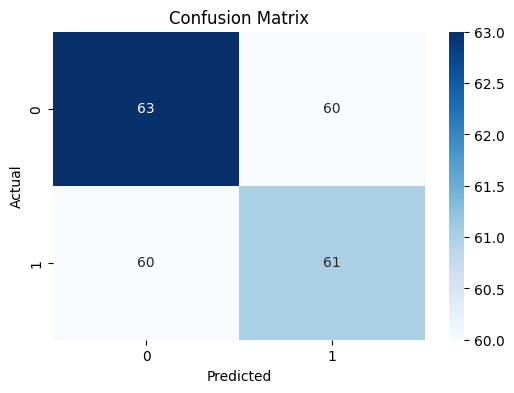

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5081967213114754, 0.5041322314049587, 0.5041322314049587, 0.5041322314049587, 5.201259761743422)
/--------------------------------------------------------------------/
ROST
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - loss: 10975.7383 - mae: 103.8387 - val_loss: 12941.9453 - val_mae: 113.3176 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 10819.9043 - mae: 103.4296 - val_loss: 12564.7471 - val_mae: 111.6477 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 10605.2021 - mae: 102.5958 - val_loss: 12068.3281 - val_mae: 109.4226 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 10345.3018 - mae: 101.4028 - val_loss: 11637.9785 - val_mae: 107.4795 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 10010.0088 - mae: 99.7910 - val_loss: 10837.5234 - val_mae: 103.8710 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9607.6182 - mae: 97.7579 - val_loss: 10060.5059 - val_mae: 100.0881 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9042.7139 - mae: 9

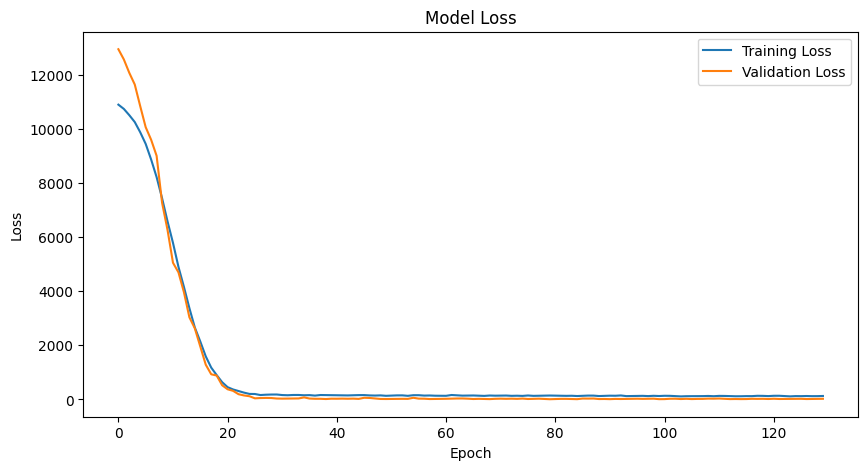

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Accuracy: 0.4754
Precision: 0.4692
Recall: 0.5083
F1-Score: 0.4880
RMSE: 9.811667


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


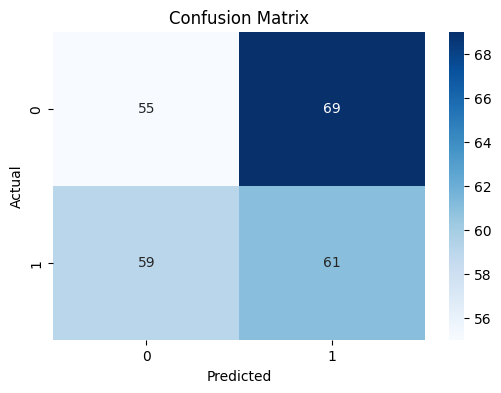

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.47540983606557374, 0.46923076923076923, 0.5083333333333333, 0.488, 9.811666554452547)
/--------------------------------------------------------------------/
MELI
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 1518098.5000 - mae: 1175.6956 - val_loss: 1735129.5000 - val_mae: 1310.5153 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1512703.8750 - mae: 1175.1732 - val_loss: 1732913.2500 - val_mae: 1309.6915 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1507128.5000 - mae: 1174.1941 - val_loss: 1726009.5000 - val_mae: 1307.1405 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1500298.8750 - mae: 1172.6438 - val_loss: 1715602.1250 - val_mae: 1303.4277 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1492171.2500 - mae: 1170.5503 - val_loss: 1695534.3750 - val_mae: 1295.9127 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1481328.5000 - mae: 1167.5131 - val_loss: 1670026.5000 - val_mae: 1286.3964 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 

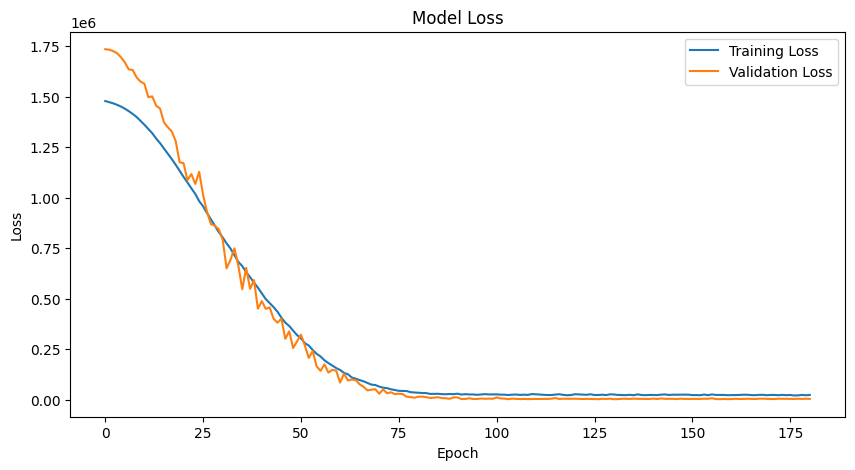

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Accuracy: 0.4918
Precision: 0.5207
Recall: 0.4884
F1-Score: 0.5040
RMSE: 131.400379


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


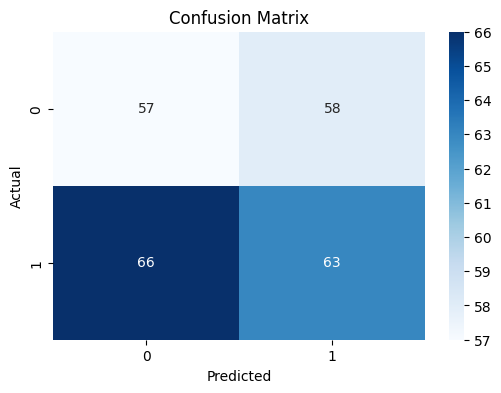

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4918032786885246, 0.5206611570247934, 0.4883720930232558, 0.504, 131.40037852644357)
/--------------------------------------------------------------------/
WBD
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 659.1585 - mae: 23.9693 - val_loss: 129.9396 - val_mae: 11.3137 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 588.5493 - mae: 23.4921 - val_loss: 111.5842 - val_mae: 10.4733 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 539.6063 - mae: 22.6230 - val_loss: 98.9736 - val_mae: 9.8628 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 490.3947 - mae: 21.5567 - val_loss: 89.6742 - val_mae: 9.3804 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 430.9910 - mae: 20.1964 - val_loss: 111.9513 - val_mae: 10.4917 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 373.7750 - mae: 18.7707 - val_loss: 110.4076 - val_mae: 10.4264 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 294.2054 - mae: 16.4807 - val_loss: 65.4481 - val_mae: 

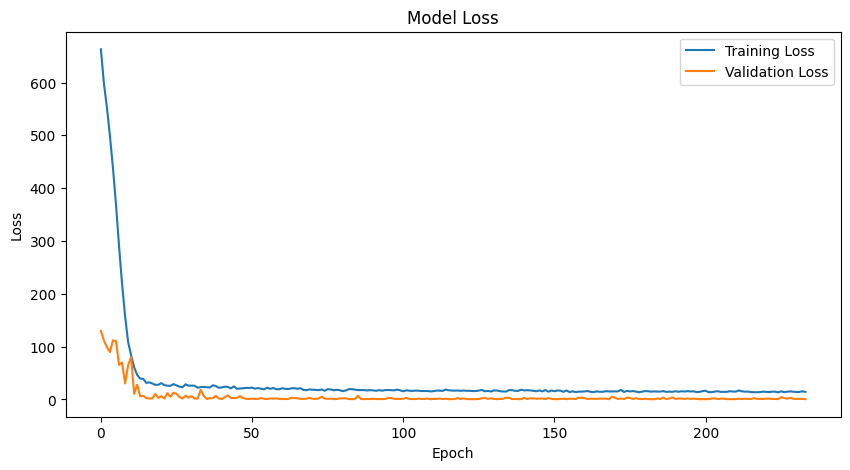

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.4959
Precision: 0.5221
Recall: 0.4609
F1-Score: 0.4896
RMSE: 1.738809


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


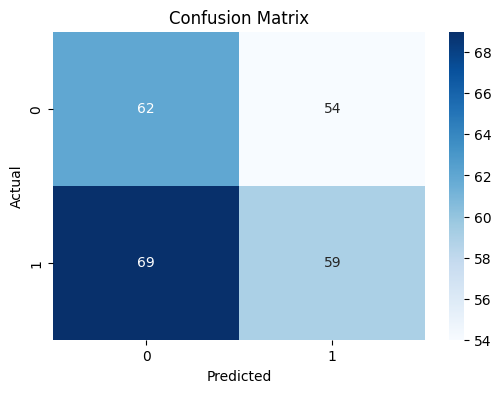

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4959016393442623, 0.5221238938053098, 0.4609375, 0.48962655601659755, 1.7388093600946923)
/--------------------------------------------------------------------/
PAYX
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - loss: 11140.0469 - mae: 103.8574 - val_loss: 13295.7266 - val_mae: 115.1401 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 10880.6904 - mae: 103.2103 - val_loss: 12997.3906 - val_mae: 113.8403 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 10658.8242 - mae: 102.5497 - val_loss: 12450.0684 - val_mae: 111.4249 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 10325.8545 - mae: 101.1580 - val_loss: 11756.7393 - val_mae: 108.3155 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9991.0391 - mae: 99.6174 - val_loss: 10699.5449 - val_mae: 103.3654 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9568.3457 - mae: 97.5210 - val_loss: 9944.4258 - val_mae: 99.6256 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8977.3018 - mae: 94.4

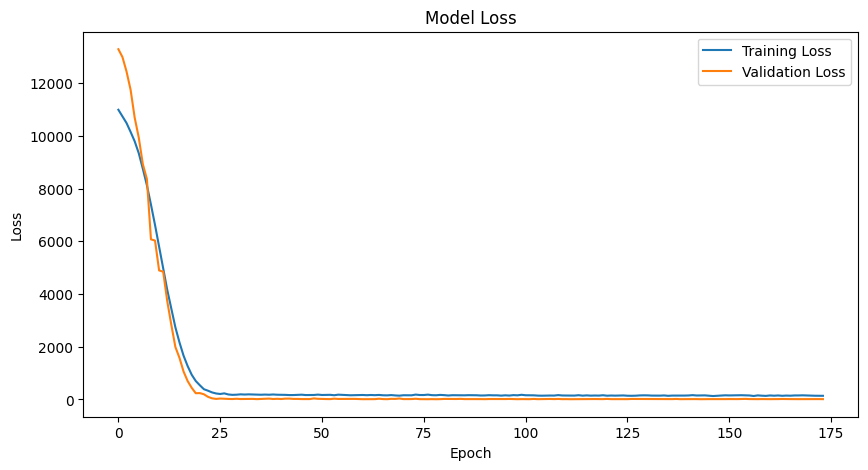

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy: 0.5082
Precision: 0.5441
Recall: 0.5606
F1-Score: 0.5522
RMSE: 3.775999


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


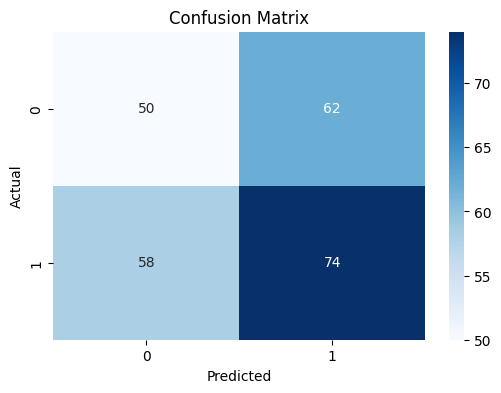

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.5081967213114754, 0.5441176470588235, 0.5606060606060606, 0.5522388059701493, 3.775999032938502)
/--------------------------------------------------------------------/
KLAC
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 97894.7891 - mae: 302.9057 - val_loss: 221581.3750 - val_mae: 467.0844 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 96778.6484 - mae: 302.3543 - val_loss: 219416.8906 - val_mae: 464.7986 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 95520.8203 - mae: 301.2849 - val_loss: 214786.0938 - val_mae: 459.8881 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 93987.6719 - mae: 299.7349 - val_loss: 209170.6875 - val_mae: 453.8974 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 92239.5938 - mae: 297.7246 - val_loss: 200255.1250 - val_mae: 444.0658 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 90138.6094 - mae: 294.9734 - val_loss: 187097.6719 - val_mae: 429.1932 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 87693.335

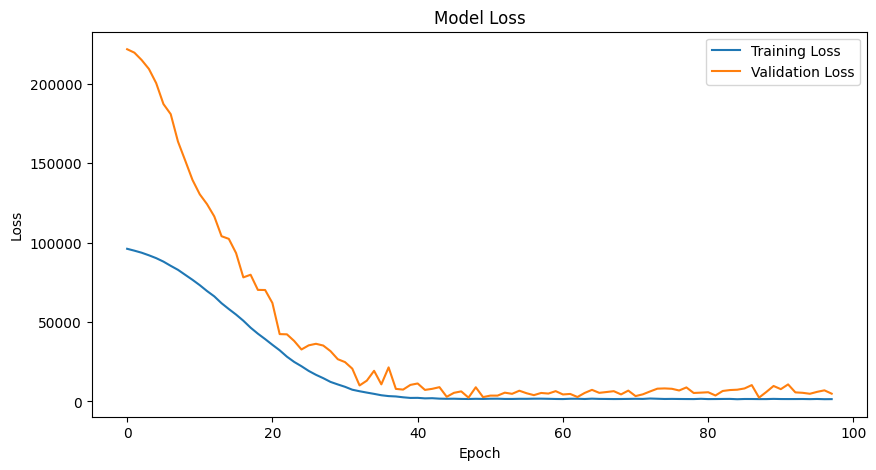

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Accuracy: 0.4959
Precision: 0.5596
Recall: 0.4485
F1-Score: 0.4980
RMSE: 293.513594


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


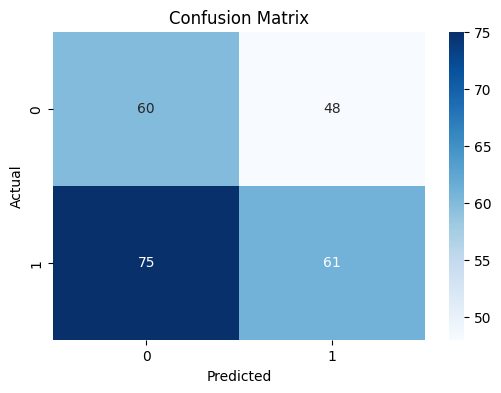

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4959016393442623, 0.5596330275229358, 0.4485294117647059, 0.4979591836734694, 293.51359378435666)
/--------------------------------------------------------------------/
CSX
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 922.8088 - mae: 30.0982 - val_loss: 972.4137 - val_mae: 31.1467 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 882.1975 - mae: 29.5685 - val_loss: 929.7540 - val_mae: 30.4580 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 838.8747 - mae: 28.8548 - val_loss: 874.7195 - val_mae: 29.5474 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 782.0877 - mae: 27.8344 - val_loss: 792.8531 - val_mae: 28.1268 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 709.4695 - mae: 26.4842 - val_loss: 685.1216 - val_mae: 26.1425 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 606.1320 - mae: 24.4397 - val_loss: 515.1154 - val_mae: 22.6581 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 495.0681 - mae: 22.0212 - val_loss: 385.5872 - val_

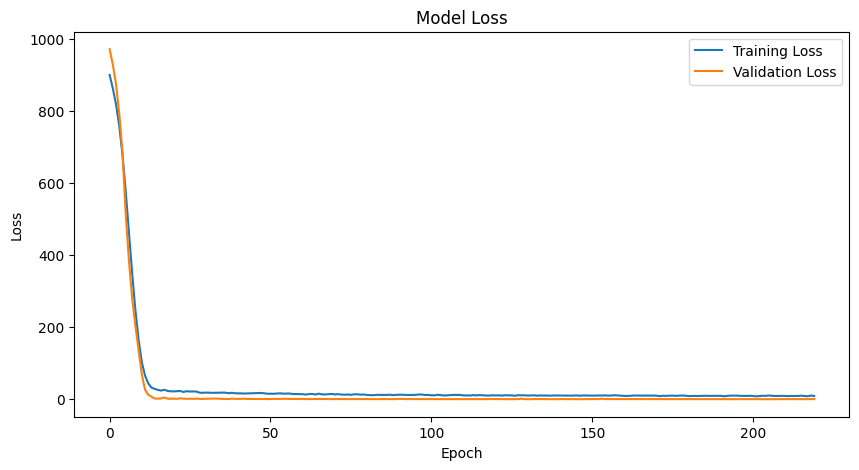

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Accuracy: 0.5328
Precision: 0.5210
Recall: 0.5210
F1-Score: 0.5210
RMSE: 1.009814


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


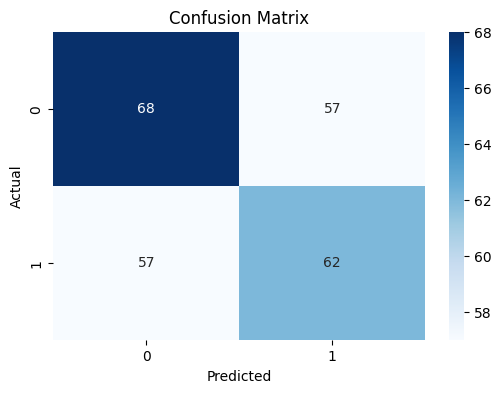

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5327868852459017, 0.5210084033613446, 0.5210084033613446, 0.5210084033613446, 1.0098139805249875)
/--------------------------------------------------------------------/
KHC
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - loss: 1293.0662 - mae: 35.7597 - val_loss: 1261.4149 - val_mae: 35.4254 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1246.4816 - mae: 35.1997 - val_loss: 1207.4800 - val_mae: 34.6668 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1195.5548 - mae: 34.4661 - val_loss: 1142.5200 - val_mae: 33.7385 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1124.4662 - mae: 33.4269 - val_loss: 1016.1540 - val_mae: 31.7954 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1024.9054 - mae: 31.8767 - val_loss: 865.5029 - val_mae: 29.3798 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 906.5287 - mae: 29.9464 - val_loss: 685.6138 - val_mae: 26.1436 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 756.6889 - mae: 27.2896 - val_loss: 563.16

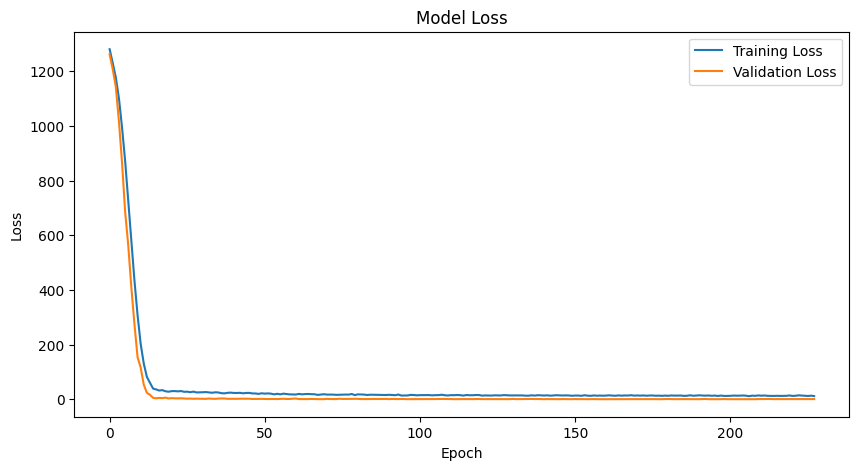

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Accuracy: 0.5697
Precision: 0.5656
Recall: 0.5702
F1-Score: 0.5679
RMSE: 0.847245


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


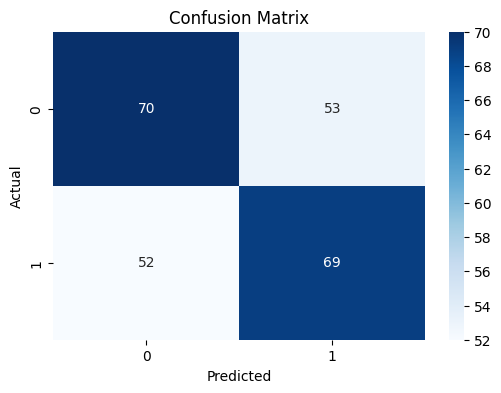

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.569672131147541, 0.5655737704918032, 0.5702479338842975, 0.5679012345679012, 0.8472451201414696)
/--------------------------------------------------------------------/
LULU
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 112519.7109 - mae: 331.0997 - val_loss: 153865.9844 - val_mae: 389.8584 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 111791.6172 - mae: 330.4943 - val_loss: 152861.8594 - val_mae: 388.5742 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 110957.4062 - mae: 329.6393 - val_loss: 150899.8438 - val_mae: 386.1146 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 109951.7266 - mae: 328.4968 - val_loss: 147772.0625 - val_mae: 382.1732 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 108347.2891 - mae: 326.4122 - val_loss: 141199.0000 - val_mae: 373.7916 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 106720.5703 - mae: 324.2926 - val_loss: 139405.5781 - val_mae: 371.4695 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 104

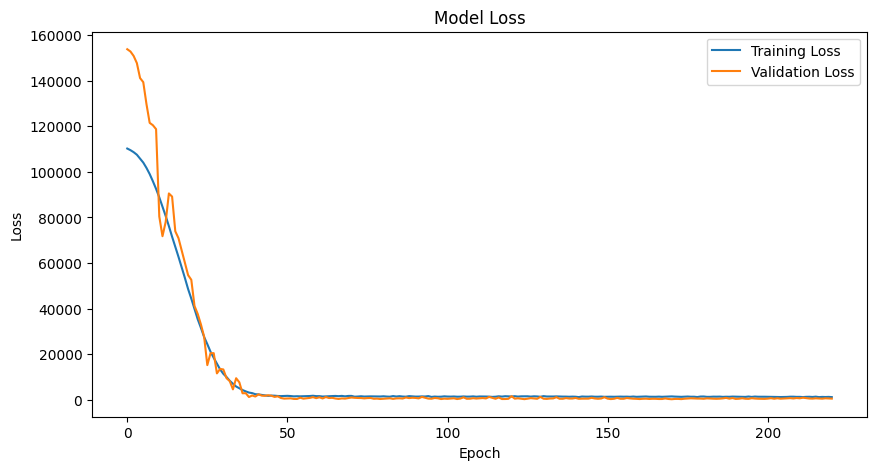

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.4508
Precision: 0.4634
Recall: 0.4560
F1-Score: 0.4597
RMSE: 15.896804


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


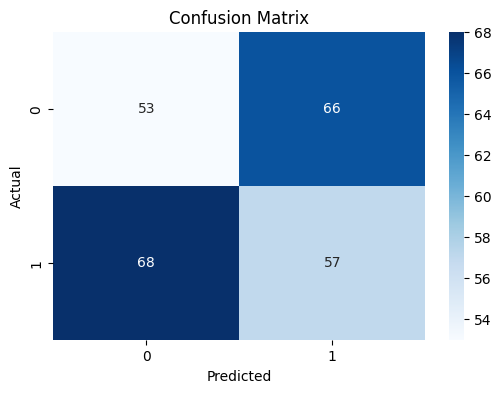

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.45081967213114754, 0.4634146341463415, 0.456, 0.45967741935483875, 15.896803655539951)
/--------------------------------------------------------------------/
CRWD
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 31244.0215 - mae: 167.1216 - val_loss: 28829.4980 - val_mae: 165.8768 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 30447.8184 - mae: 166.5302 - val_loss: 28632.0332 - val_mae: 165.3581 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 29683.3809 - mae: 165.3730 - val_loss: 28094.2695 - val_mae: 164.0136 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 28760.1895 - mae: 163.8401 - val_loss: 28188.8555 - val_mae: 164.9862 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 27821.0918 - mae: 161.9449 - val_loss: 26731.8535 - val_mae: 161.0580 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 26717.4688 - mae: 159.4424 - val_loss: 24480.9609 - val_mae: 154.2238 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 25378.6562 - ma

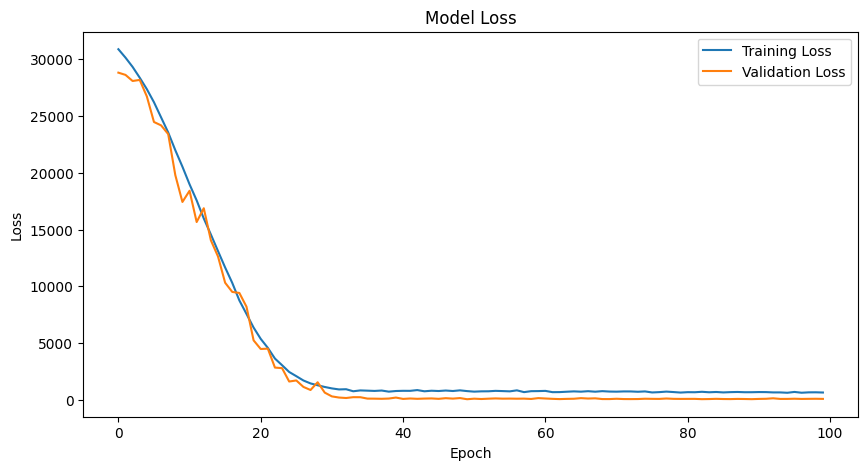

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Accuracy: 0.4508
Precision: 0.4779
Recall: 0.4186
F1-Score: 0.4463
RMSE: 57.586779


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


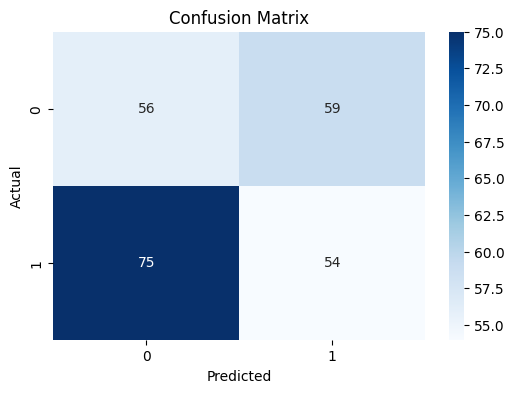

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.45081967213114754, 0.4778761061946903, 0.4186046511627907, 0.4462809917355372, 57.58677887335374)
/--------------------------------------------------------------------/
AZN
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - loss: 3344.8718 - mae: 57.5125 - val_loss: 4665.2344 - val_mae: 68.1996 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3266.0452 - mae: 56.9437 - val_loss: 4522.1548 - val_mae: 67.1459 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3169.7839 - mae: 56.1771 - val_loss: 4258.3872 - val_mae: 65.1585 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3054.4409 - mae: 55.1572 - val_loss: 3919.6809 - val_mae: 62.5129 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2887.5151 - mae: 53.6131 - val_loss: 3371.2183 - val_mae: 58.0173 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2677.8799 - mae: 51.5990 - val_loss: 2854.6521 - val_mae: 53.3727 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2402.8472 - mae: 48.8468 - val_loss: 28

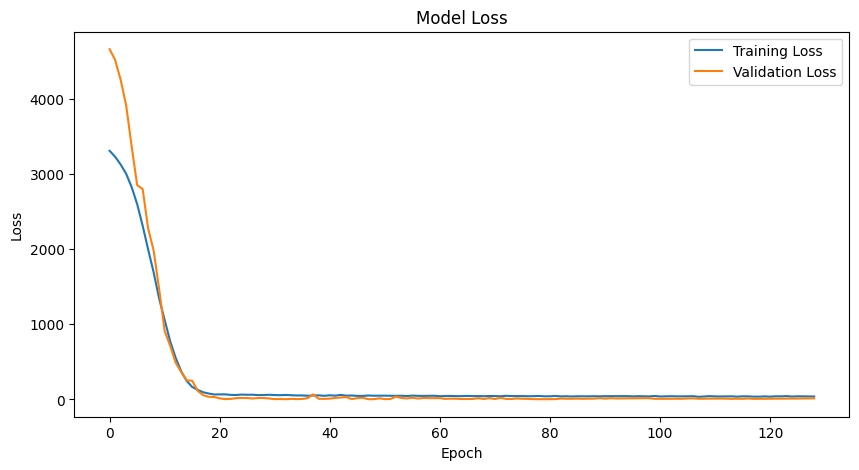

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Accuracy: 0.4877
Precision: 0.5420
Recall: 0.5221
F1-Score: 0.5318
RMSE: 3.196495


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


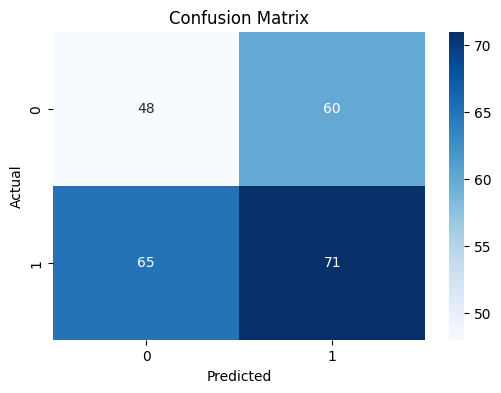

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.48770491803278687, 0.5419847328244275, 0.5220588235294118, 0.5318352059925094, 3.1964950444556717)
/--------------------------------------------------------------------/
TXN
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 27485.8105 - mae: 164.2762 - val_loss: 27674.0254 - val_mae: 166.0015 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 27147.0703 - mae: 163.6986 - val_loss: 27409.1387 - val_mae: 165.2077 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 26785.7832 - mae: 162.8681 - val_loss: 26841.9199 - val_mae: 163.5220 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 26313.0449 - mae: 161.6202 - val_loss: 25886.5215 - val_mae: 160.6116 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 25653.2637 - mae: 159.7172 - val_loss: 25040.3809 - val_mae: 158.0347 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 24924.6680 - mae: 157.5174 - val_loss: 24300.4668 - val_mae: 155.7676 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 23937.1016 - ma

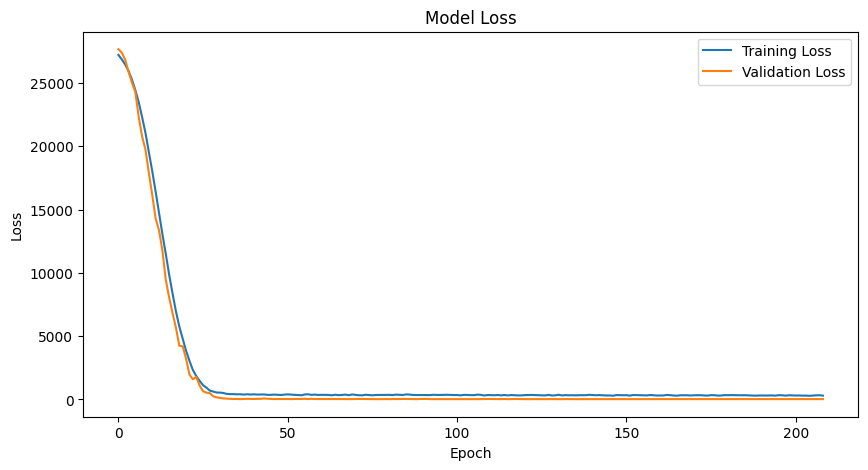

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Accuracy: 0.5410
Precision: 0.5517
Recall: 0.5161
F1-Score: 0.5333
RMSE: 8.444725


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


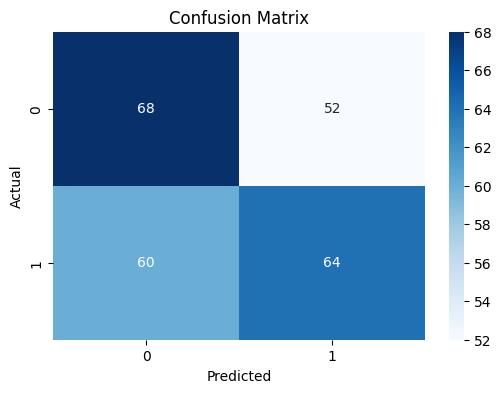

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5409836065573771, 0.5517241379310345, 0.5161290322580645, 0.5333333333333333, 8.444724705712801)
/--------------------------------------------------------------------/
TTWO
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 22942.0820 - mae: 148.8200 - val_loss: 19670.9746 - val_mae: 139.7292 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 22498.2930 - mae: 148.1399 - val_loss: 19763.7891 - val_mae: 140.0912 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 22146.6387 - mae: 147.4143 - val_loss: 19880.2520 - val_mae: 140.5795 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 21647.7520 - mae: 146.0779 - val_loss: 20187.7148 - val_mae: 141.8203 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 21057.0996 - mae: 144.3624 - val_loss: 20567.1523 - val_mae: 143.2697 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 20239.2949 - mae: 141.6982 - val_loss: 19202.5801 - val_mae: 138.4993 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 19394.7461 - ma

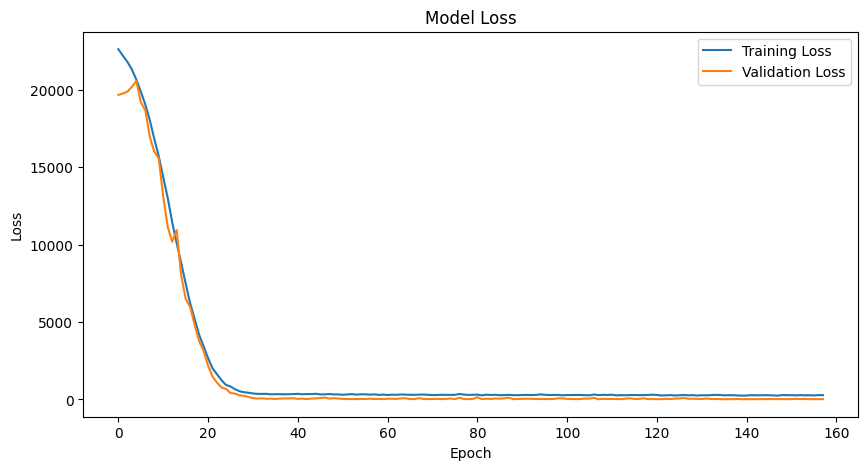

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Accuracy: 0.5287
Precision: 0.5909
Recall: 0.5612
F1-Score: 0.5756
RMSE: 4.044451


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


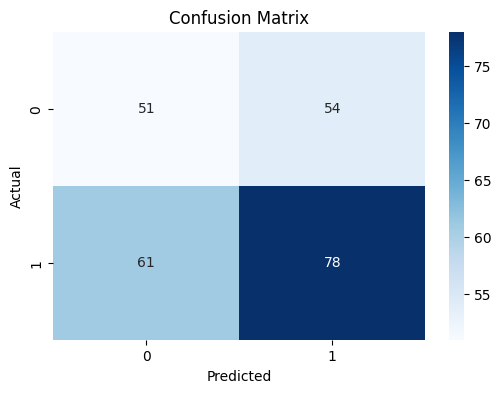

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5286885245901639, 0.5909090909090909, 0.5611510791366906, 0.5756457564575646, 4.044450688506008)
/--------------------------------------------------------------------/
ROP
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 180046.2969 - mae: 422.5090 - val_loss: 233875.1250 - val_mae: 482.5664 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 179446.0469 - mae: 421.9774 - val_loss: 233376.7812 - val_mae: 482.0582 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 178576.3906 - mae: 421.1938 - val_loss: 231863.1250 - val_mae: 480.4954 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 177379.7812 - mae: 419.9893 - val_loss: 229150.5938 - val_mae: 477.6978 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 175782.5938 - mae: 418.2642 - val_loss: 225916.6562 - val_mae: 474.3055 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 173804.8906 - mae: 416.0107 - val_loss: 217231.9375 - val_mae: 465.2674 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 171

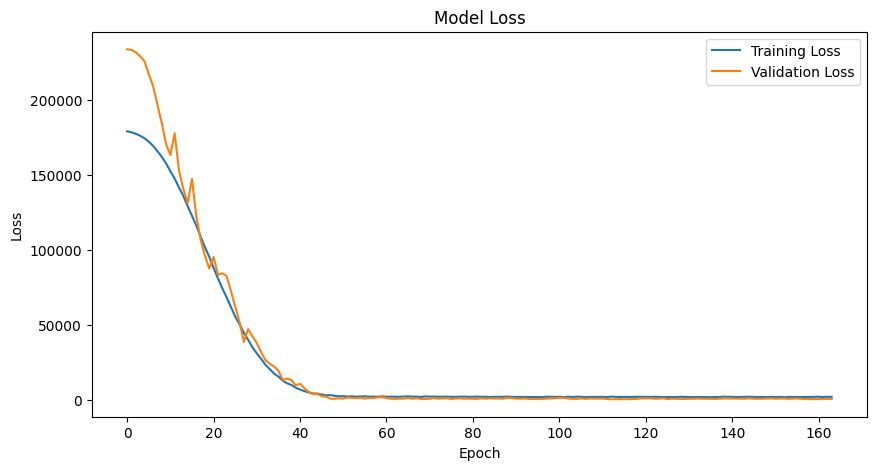

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.5123
Precision: 0.5481
Recall: 0.5606
F1-Score: 0.5543
RMSE: 48.736907


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


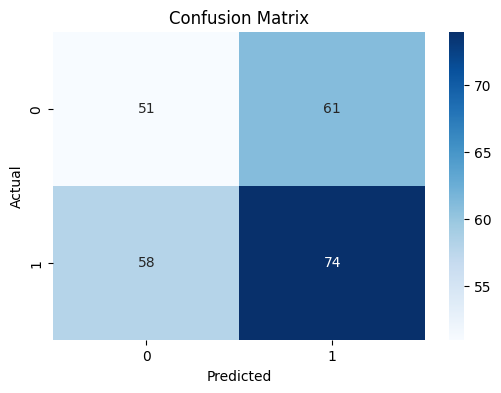

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5122950819672131, 0.5481481481481482, 0.5606060606060606, 0.5543071161048688, 48.73690739128549)
/--------------------------------------------------------------------/
ZS
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 35261.8320 - mae: 174.8046 - val_loss: 23664.8125 - val_mae: 150.3199 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 34300.4883 - mae: 174.2150 - val_loss: 23843.0117 - val_mae: 150.9992 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 33355.5469 - mae: 173.0284 - val_loss: 24563.4531 - val_mae: 153.5569 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 32347.8125 - mae: 171.4827 - val_loss: 25073.7559 - val_mae: 155.6349 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 31241.5000 - mae: 169.4462 - val_loss: 25646.5840 - val_mae: 158.0231 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 29919.9766 - mae: 166.7697 - val_loss: 25146.0059 - val_mae: 156.4428 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 28623.6250 - ma

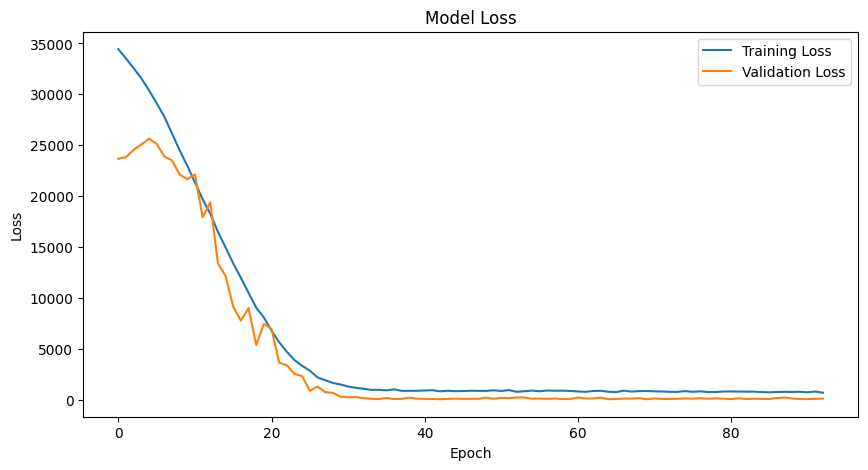

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Accuracy: 0.5000
Precision: 0.5197
Recall: 0.5197
F1-Score: 0.5197
RMSE: 12.309737


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


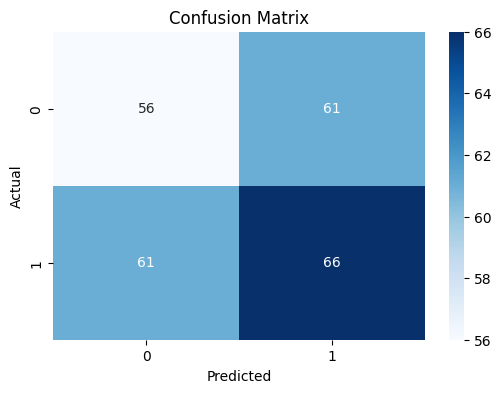

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5, 0.5196850393700787, 0.5196850393700787, 0.5196850393700787, 12.30973732805273)
/--------------------------------------------------------------------/
GFS
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 3500.1838 - mae: 58.8173 - val_loss: 3141.6663 - val_mae: 55.9672 - learning_rate: 0.0010
Epoch 2/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3458.8831 - mae: 58.5041 - val_loss: 3090.0969 - val_mae: 55.5051 - learning_rate: 0.0010
Epoch 3/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3428.8037 - mae: 58.3098 - val_loss: 3035.2207 - val_mae: 55.0082 - learning_rate: 0.0010
Epoch 4/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3397.9395 - mae: 58.0515 - val_loss: 2975.0759 - val_mae: 54.4580 - learning_rate: 0.0010
Epoch 5/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3333.3394 - mae: 57.5178 - val_loss: 2911.4717 - val_mae: 53.8742 - learning_rate: 0.0010
Epoch 6/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3262.0471 - mae: 56.8962 - val_loss: 2850.3506 - val_mae: 53.3075 - learning_rate: 0.0010
Epoch 7/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3204.6489 - mae: 56.3652 - val_loss: 27

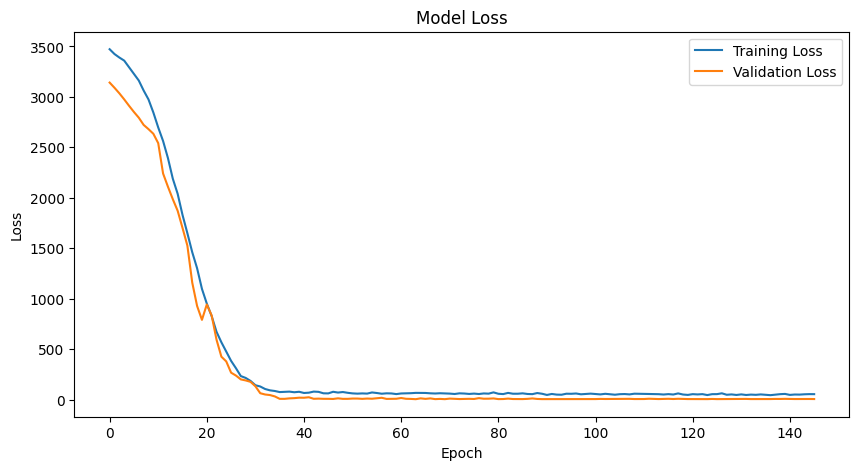

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 0.4959
Precision: 0.4797
Recall: 0.5000
F1-Score: 0.4896
RMSE: 3.596154


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


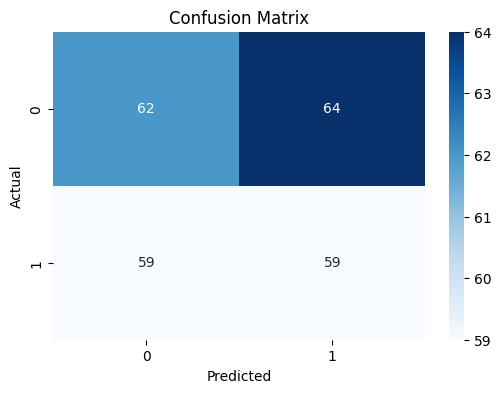

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4959016393442623, 0.4796747967479675, 0.5, 0.4896265560165975, 3.5961541759135582)
/--------------------------------------------------------------------/
ISRG
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 67060.4609 - mae: 254.2401 - val_loss: 90934.1953 - val_mae: 300.4347 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 66285.9688 - mae: 253.5070 - val_loss: 90483.7344 - val_mae: 299.6911 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 65530.5938 - mae: 252.5626 - val_loss: 89444.2969 - val_mae: 298.0037 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 64669.5703 - mae: 251.3777 - val_loss: 87668.7188 - val_mae: 295.1128 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 63425.1016 - mae: 249.3915 - val_loss: 84894.5781 - val_mae: 290.5149 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 61910.3125 - mae: 246.8294 - val_loss: 80095.0625 - val_mae: 282.3694 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 60187.6914 - ma

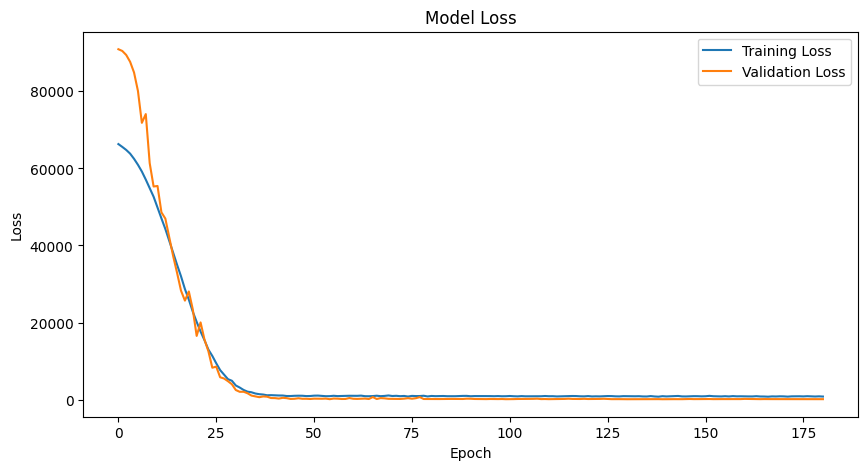

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.4918
Precision: 0.5290
Recall: 0.5530
F1-Score: 0.5407
RMSE: 96.211401


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


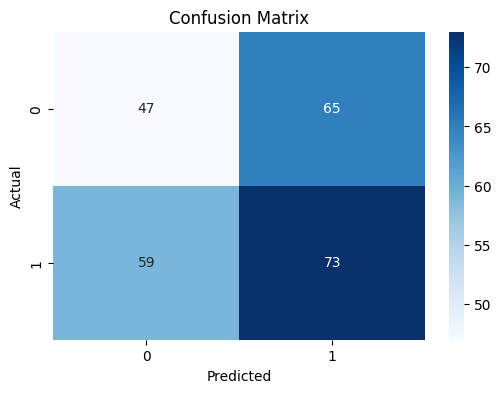

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4918032786885246, 0.5289855072463768, 0.553030303030303, 0.5407407407407409, 96.2114013275126)
/--------------------------------------------------------------------/
PLTR
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 294.8121 - mae: 15.7283 - val_loss: 256.6583 - val_mae: 15.8608 - learning_rate: 0.0010
Epoch 2/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 243.4012 - mae: 15.1238 - val_loss: 241.8136 - val_mae: 15.3869 - learning_rate: 0.0010
Epoch 3/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 228.6352 - mae: 14.7643 - val_loss: 226.0141 - val_mae: 14.8647 - learning_rate: 0.0010
Epoch 4/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 206.5513 - mae: 13.9995 - val_loss: 203.6617 - val_mae: 14.0944 - learning_rate: 0.0010
Epoch 5/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 187.1115 - mae: 13.2814 - val_loss: 163.7751 - val_mae: 12.6204 - learning_rate: 0.0010
Epoch 6/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 162.6637 - mae: 12.2846 - val_loss: 129.0772 - val_mae: 11.2037 - learning_rate: 0.0010
Epoch 7/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 133.7134 - mae: 11.0921 - val_loss: 111.2214 - val_

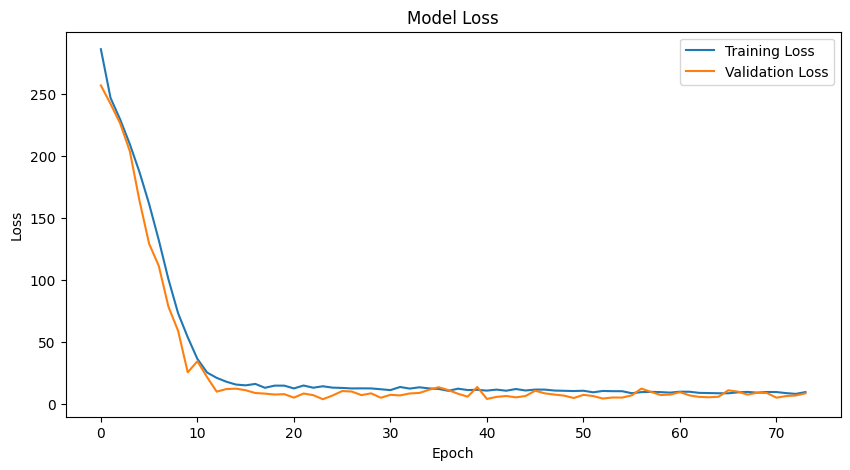

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy: 0.5205
Precision: 0.5484
Recall: 0.5271
F1-Score: 0.5375
RMSE: 14.991632


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


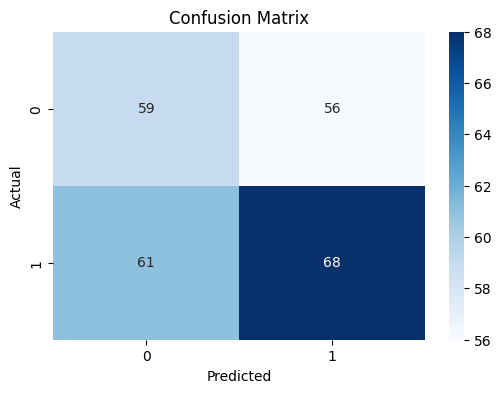

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5204918032786885, 0.5483870967741935, 0.5271317829457365, 0.5375494071146245, 14.991631693656554)
/--------------------------------------------------------------------/
ADSK
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 59522.4336 - mae: 239.7762 - val_loss: 43213.5781 - val_mae: 207.5401 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 58841.8125 - mae: 239.0877 - val_loss: 42841.3516 - val_mae: 206.6441 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 58092.6641 - mae: 238.1193 - val_loss: 42426.9961 - val_mae: 205.6534 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 57255.5781 - mae: 236.8889 - val_loss: 44219.5820 - val_mae: 210.0539 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 56115.7266 - mae: 234.9951 - val_loss: 44621.4375 - val_mae: 211.0690 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 54739.1641 - mae: 232.4648 - val_loss: 46432.3125 - val_mae: 215.3182 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 53117.1406 - ma

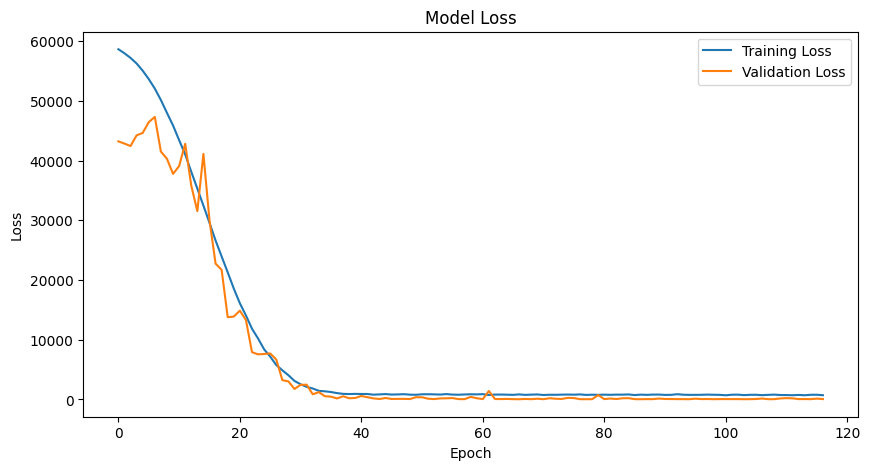

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Accuracy: 0.5123
Precision: 0.5639
Recall: 0.5515
F1-Score: 0.5576
RMSE: 10.835265


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


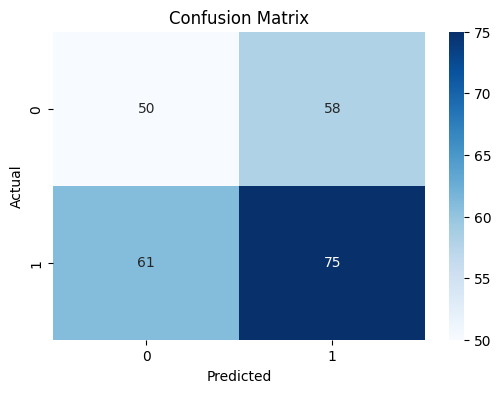

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5122950819672131, 0.5639097744360902, 0.5514705882352942, 0.5576208178438661, 10.835264834457927)
/--------------------------------------------------------------------/
CPRT
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 892.2260 - mae: 29.4671 - val_loss: 1900.6501 - val_mae: 43.4399 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 837.4558 - mae: 28.7689 - val_loss: 1827.6791 - val_mae: 42.5975 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 805.1788 - mae: 28.2546 - val_loss: 1745.4515 - val_mae: 41.6355 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 739.1793 - mae: 27.0363 - val_loss: 1574.0648 - val_mae: 39.5331 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 669.1301 - mae: 25.6972 - val_loss: 1227.1588 - val_mae: 34.9263 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 578.1790 - mae: 23.8328 - val_loss: 1110.5796 - val_mae: 33.2228 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 473.0246 - mae: 21.5054 - val_loss: 898.7622 

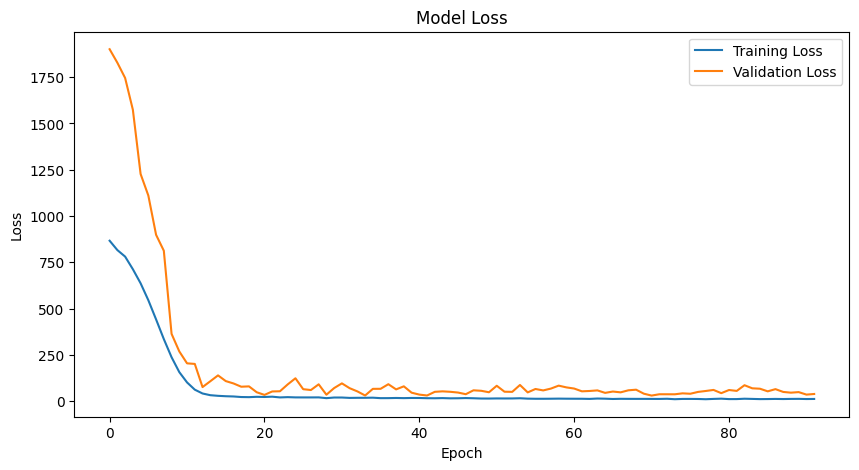

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 836ms/step
Accuracy: 0.4590
Precision: 0.4951
Recall: 0.3893
F1-Score: 0.4359
RMSE: 14.592065


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


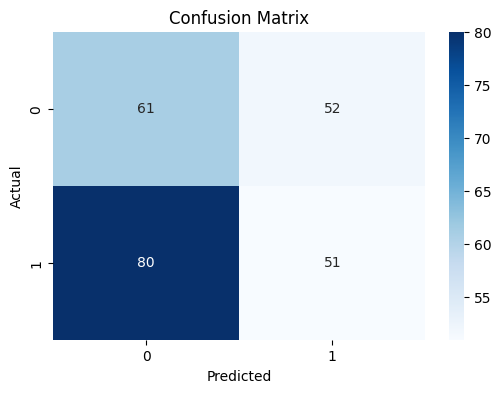

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(0.45901639344262296, 0.49514563106796117, 0.3893129770992366, 0.4358974358974359, 14.592064966322948)
/--------------------------------------------------------------------/
AMGN
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 56612.8281 - mae: 237.2883 - val_loss: 62993.7617 - val_mae: 250.1528 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 56300.6836 - mae: 236.7104 - val_loss: 62627.2188 - val_mae: 249.4309 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 55922.8398 - mae: 235.9722 - val_loss: 62307.2070 - val_mae: 248.8143 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 55379.8828 - mae: 234.8933 - val_loss: 61472.7500 - val_mae: 247.2556 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 54581.2070 - mae: 233.2483 - val_loss: 59734.4023 - val_mae: 243.7942 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 53624.5430 - mae: 231.2295 - val_loss: 57671.9297 - val_mae: 239.8171 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 52178.2812 - ma

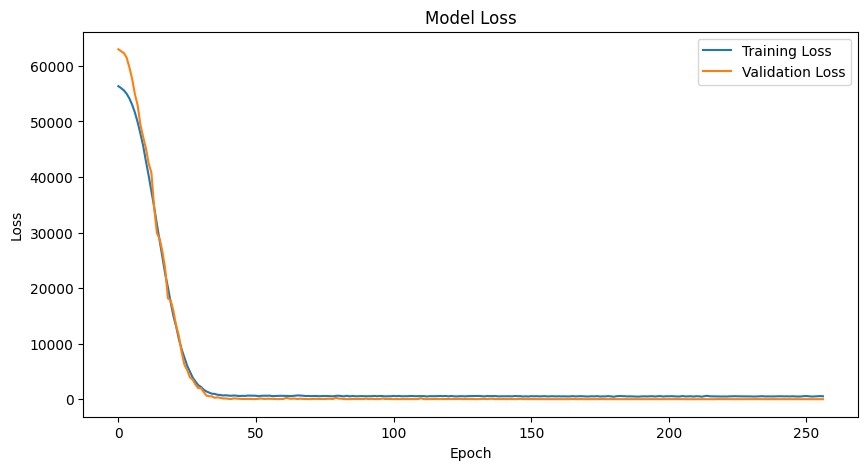

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Accuracy: 0.4713
Precision: 0.4733
Recall: 0.5082
F1-Score: 0.4901
RMSE: 26.763130


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


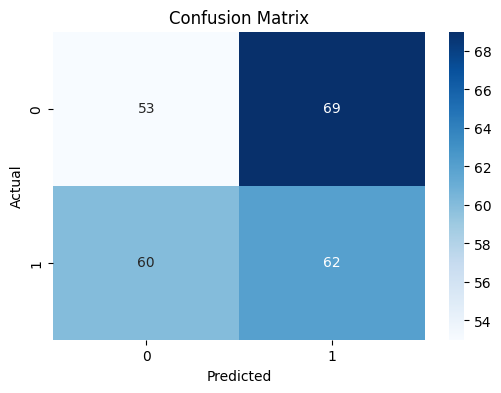

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4713114754098361, 0.4732824427480916, 0.5081967213114754, 0.4901185770750988, 26.763130316406723)
/--------------------------------------------------------------------/
EXC
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 1297.7535 - mae: 35.5352 - val_loss: 1553.7665 - val_mae: 39.3757 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1238.8240 - mae: 34.9871 - val_loss: 1489.1260 - val_mae: 38.5516 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1170.1857 - mae: 34.0547 - val_loss: 1366.2379 - val_mae: 36.9311 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1084.8508 - mae: 32.7989 - val_loss: 1177.2448 - val_mae: 34.2854 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 995.4606 - mae: 31.3938 - val_loss: 1018.0346 - val_mae: 31.8614 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 883.6262 - mae: 29.5363 - val_loss: 883.1591 - val_mae: 29.6860 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 738.7885 - mae: 26.9497 - val_loss: 703.98

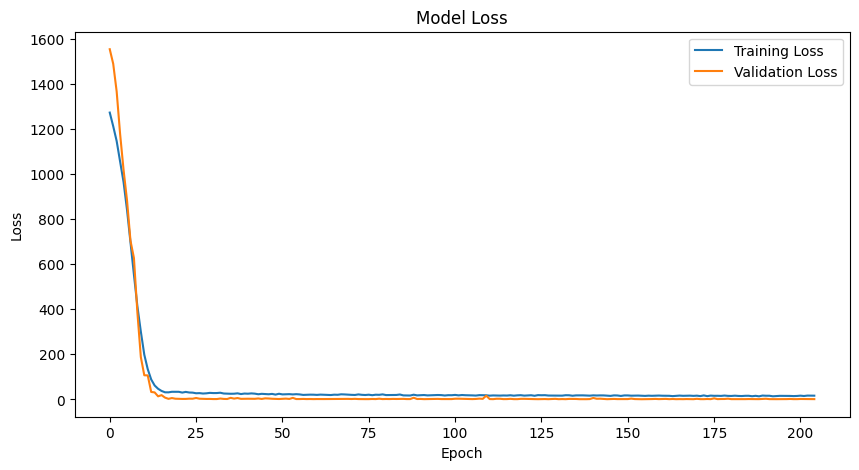

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Accuracy: 0.4959
Precision: 0.5149
Recall: 0.5433
F1-Score: 0.5287
RMSE: 0.916583


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


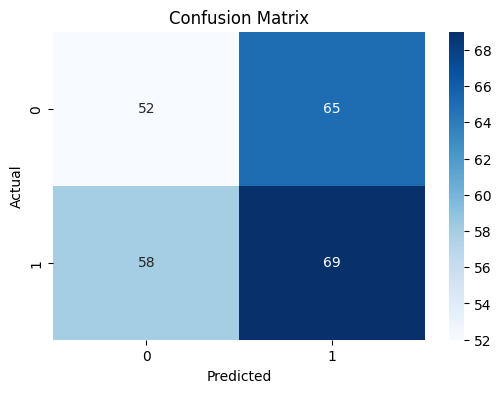

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4959016393442623, 0.5149253731343284, 0.5433070866141733, 0.5287356321839081, 0.916582519557005)
/--------------------------------------------------------------------/
DDOG
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 11249.3545 - mae: 100.6466 - val_loss: 8906.5010 - val_mae: 92.9940 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 10870.7520 - mae: 100.1322 - val_loss: 8688.1357 - val_mae: 91.8467 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 10530.9512 - mae: 99.1749 - val_loss: 8312.5508 - val_mae: 89.9237 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 10129.3320 - mae: 97.8517 - val_loss: 8008.0781 - val_mae: 88.3744 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9636.0430 - mae: 95.9790 - val_loss: 8028.0137 - val_mae: 88.7341 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9089.2422 - mae: 93.6734 - val_loss: 8056.3364 - val_mae: 89.1605 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8502.7393 - mae: 90.9428 - val_lo

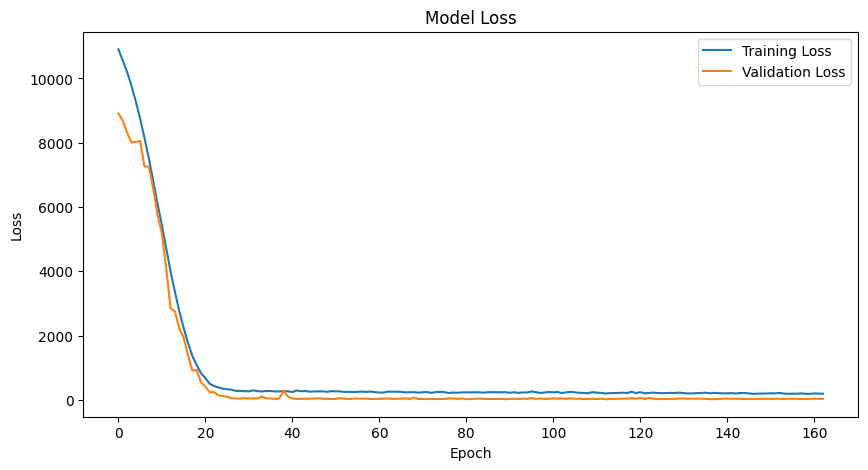

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.4713
Precision: 0.5000
Recall: 0.4961
F1-Score: 0.4981
RMSE: 5.838544


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


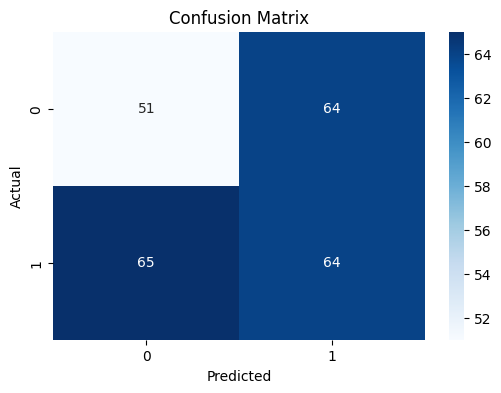

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.4713114754098361, 0.5, 0.49612403100775193, 0.4980544747081712, 5.83854446929506)
/--------------------------------------------------------------------/
AEP
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 7912.6460 - mae: 88.6796 - val_loss: 6805.3418 - val_mae: 82.2863 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7813.4663 - mae: 88.2458 - val_loss: 6712.7163 - val_mae: 81.7370 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7656.1738 - mae: 87.3860 - val_loss: 6525.2109 - val_mae: 80.5904 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7469.4663 - mae: 86.3205 - val_loss: 6438.3843 - val_mae: 80.0595 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7219.3301 - mae: 84.8532 - val_loss: 6362.2905 - val_mae: 79.6439 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6862.0454 - mae: 82.7029 - val_loss: 5706.0659 - val_mae: 75.3631 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6440.5522 - mae: 80.0925 - val_loss: 54

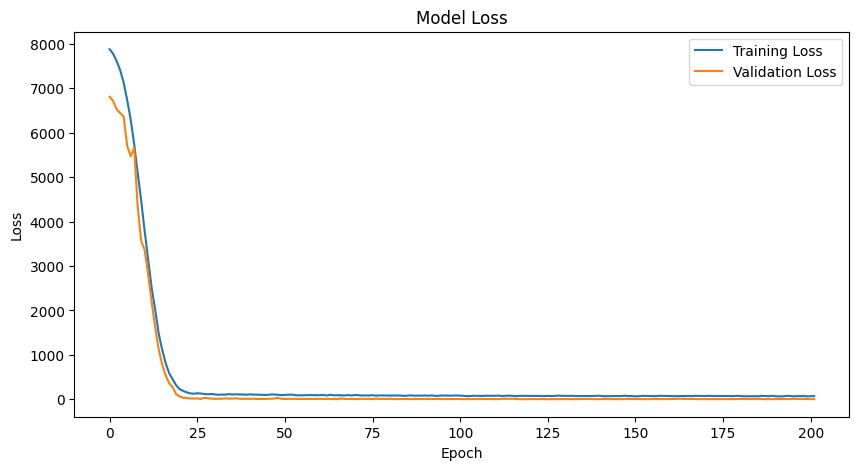

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Accuracy: 0.5123
Precision: 0.5161
Recall: 0.5203
F1-Score: 0.5182
RMSE: 1.757418


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


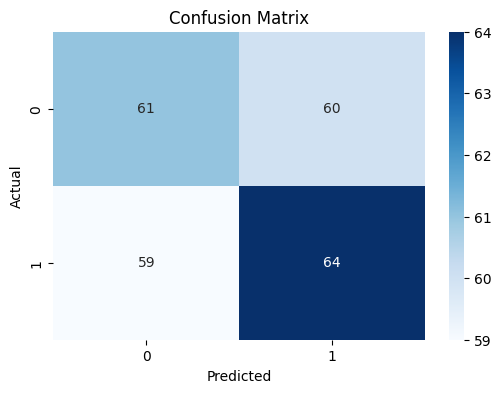

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5122950819672131, 0.5161290322580645, 0.5203252032520326, 0.5182186234817813, 1.7574183789239073)
/--------------------------------------------------------------------/
PCAR
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 3453.3147 - mae: 58.4580 - val_loss: 6760.9541 - val_mae: 81.8386 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3376.1050 - mae: 57.8679 - val_loss: 6627.8599 - val_mae: 81.0203 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3269.3103 - mae: 56.9759 - val_loss: 6404.1108 - val_mae: 79.6345 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3142.6382 - mae: 55.8415 - val_loss: 6001.6279 - val_mae: 77.1125 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2979.9570 - mae: 54.4222 - val_loss: 5499.8872 - val_mae: 73.7643 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2752.0007 - mae: 52.2734 - val_loss: 4671.0425 - val_mae: 67.9660 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2468.2051 - mae: 49.4545 - val_loss: 35

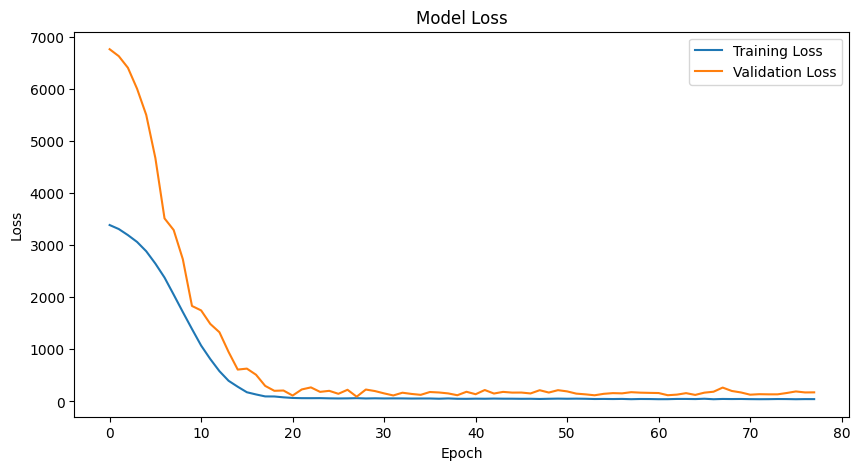

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy: 0.5328
Precision: 0.5645
Recall: 0.5385
F1-Score: 0.5512
RMSE: 31.061339


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


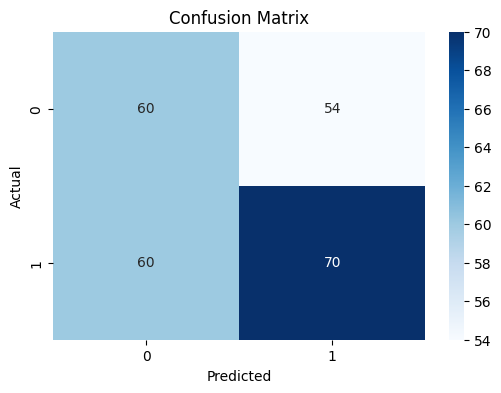

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5327868852459017, 0.5645161290322581, 0.5384615384615384, 0.5511811023622047, 31.0613385913371)
/--------------------------------------------------------------------/
TMUS
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 15970.9941 - mae: 125.2847 - val_loss: 20162.9570 - val_mae: 141.8245 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15757.3086 - mae: 124.7136 - val_loss: 19883.4941 - val_mae: 140.8398 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15460.6309 - mae: 123.7824 - val_loss: 19312.0898 - val_mae: 138.8156 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 15123.0986 - mae: 122.6044 - val_loss: 18697.3711 - val_mae: 136.5896 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 14702.1396 - mae: 120.9505 - val_loss: 17422.8477 - val_mae: 131.8596 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 14150.2148 - mae: 118.6703 - val_loss: 16499.2168 - val_mae: 128.2946 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 13540.7891 - ma

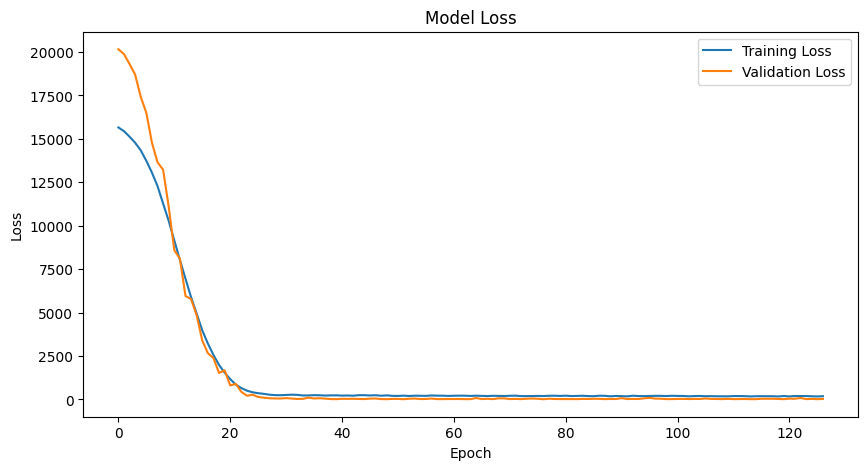

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Accuracy: 0.5041
Precision: 0.5606
Recall: 0.5401
F1-Score: 0.5502
RMSE: 42.213332


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


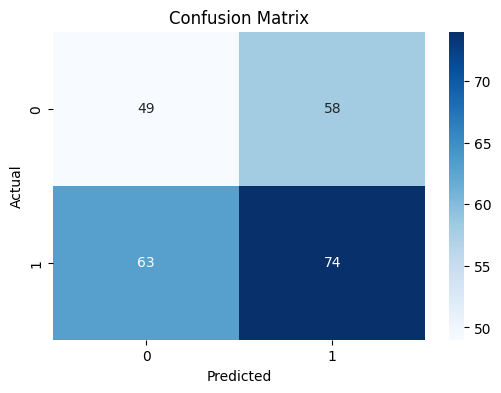

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5040983606557377, 0.5606060606060606, 0.5401459854014599, 0.550185873605948, 42.21333200021521)
/--------------------------------------------------------------------/
COST
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 189489.2500 - mae: 427.4669 - val_loss: 302101.8750 - val_mae: 547.8196 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 188099.4375 - mae: 426.7815 - val_loss: 303942.3125 - val_mae: 549.5102 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 186838.2656 - mae: 425.8778 - val_loss: 303885.5938 - val_mae: 549.5545 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 185133.5312 - mae: 424.5038 - val_loss: 298490.2188 - val_mae: 544.8666 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 182986.0312 - mae: 422.5962 - val_loss: 285900.0938 - val_mae: 533.2510 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 180158.8594 - mae: 419.9185 - val_loss: 271747.0938 - val_mae: 519.6516 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 176

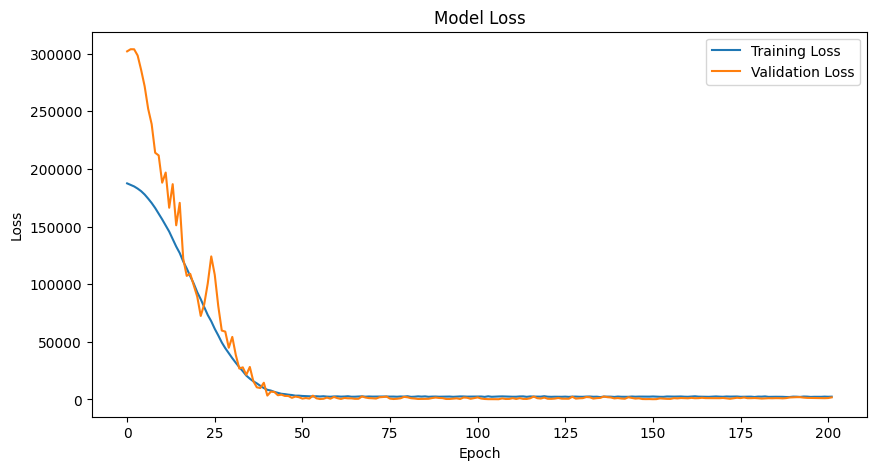

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Accuracy: 0.5205
Precision: 0.5769
Recall: 0.4511
F1-Score: 0.5063
RMSE: 244.385565


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


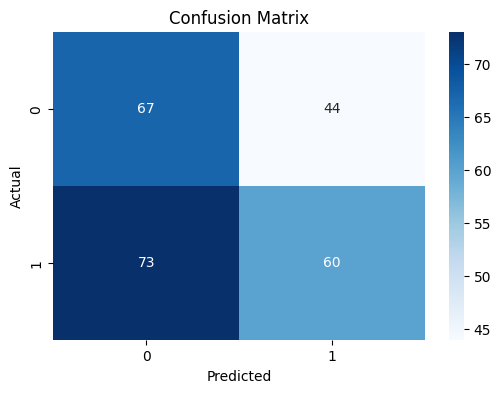

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5204918032786885, 0.5769230769230769, 0.45112781954887216, 0.5063291139240507, 244.38556487083255)
/--------------------------------------------------------------------/
INTU
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - loss: 181509.7969 - mae: 414.0868 - val_loss: 248004.1719 - val_mae: 494.7288 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 179937.5469 - mae: 413.4167 - val_loss: 247308.4219 - val_mae: 494.0732 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 178373.1719 - mae: 412.4935 - val_loss: 244892.1406 - val_mae: 491.8069 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 176339.3125 - mae: 410.8543 - val_loss: 236219.8750 - val_mae: 483.3482 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 174052.0625 - mae: 408.8618 - val_loss: 229620.1562 - val_mae: 476.5604 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 171093.3906 - mae: 406.0759 - val_loss: 221105.8281 - val_mae: 467.9930 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 167

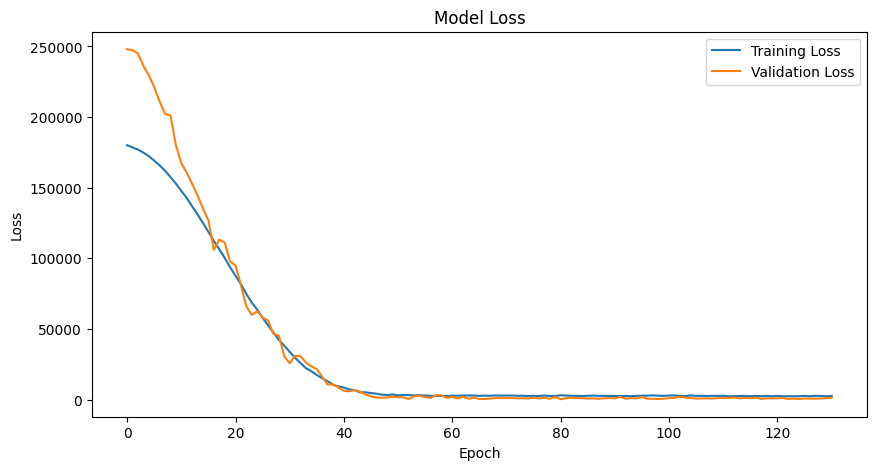

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Accuracy: 0.4877
Precision: 0.5224
Recall: 0.5344
F1-Score: 0.5283
RMSE: 20.978403


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


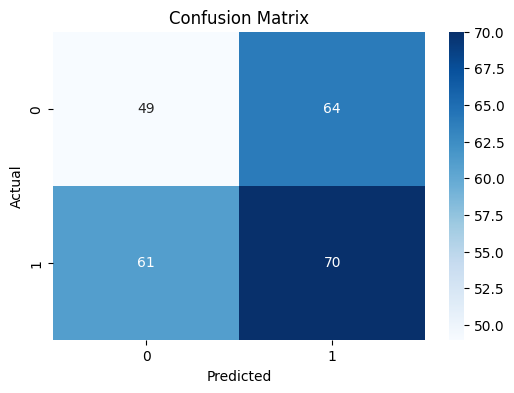

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.48770491803278687, 0.5223880597014925, 0.5343511450381679, 0.5283018867924528, 20.978403013062017)
/--------------------------------------------------------------------/
ASML
/--------------------------------------------------------------------/


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 324006.1875 - mae: 547.3710 - val_loss: 447547.1562 - val_mae: 667.1722 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 321378.1875 - mae: 546.6296 - val_loss: 446376.9688 - val_mae: 666.3112 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 318819.2500 - mae: 545.4514 - val_loss: 440863.1562 - val_mae: 662.2220 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 315965.8438 - mae: 544.0153 - val_loss: 432069.2188 - val_mae: 655.6921 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 312198.2188 - mae: 541.7007 - val_loss: 417944.4062 - val_mae: 644.9273 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 308380.2812 - mae: 539.3090 - val_loss: 402264.6875 - val_mae: 632.7311 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 303

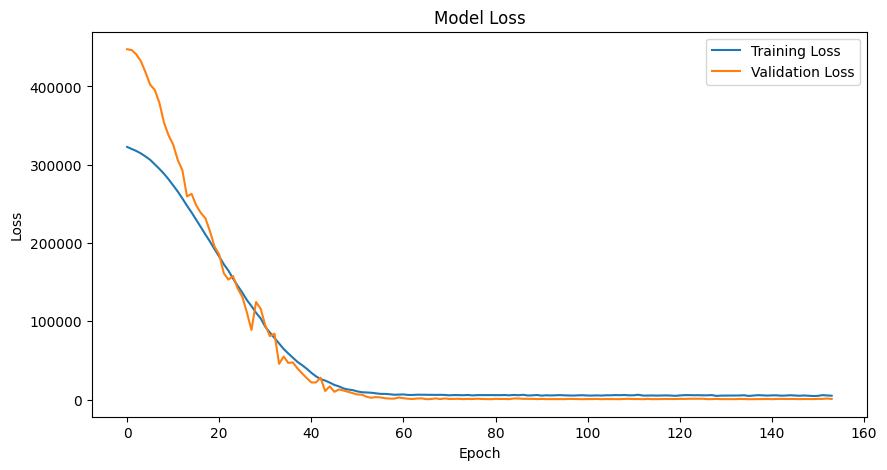

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy: 0.5246
Precision: 0.5441
Recall: 0.5781
F1-Score: 0.5606
RMSE: 98.492433


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


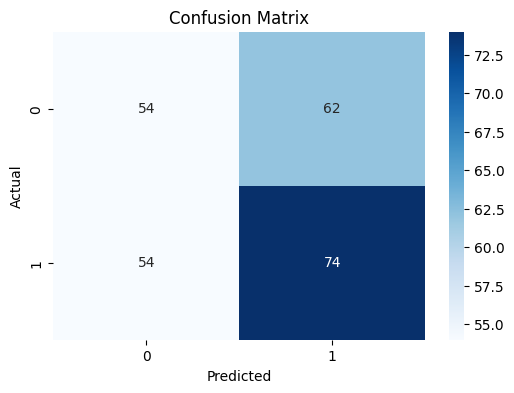

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(0.5245901639344263, 0.5441176470588235, 0.578125, 0.5606060606060606, 98.49243285096821)
    Ticker  Accuracy  Precision    Recall  F1-Score        RMSE
0     FANG  0.524590   0.578125  0.544118  0.560606   22.037217
1      BKR  0.508197   0.512397  0.504065  0.508197    2.252786
2     CDNS  0.540984   0.546875  0.564516  0.555556   85.658883
3     CSCO  0.540984   0.585366  0.541353  0.562500    1.180957
4     MSTR  0.504098   0.508333  0.495935  0.502058  124.394575
..     ...       ...        ...       ...       ...         ...
96    PCAR  0.532787   0.564516  0.538462  0.551181   31.061339
97    TMUS  0.504098   0.560606  0.540146  0.550186   42.213332
98    COST  0.520492   0.576923  0.451128  0.506329  244.385565
99    INTU  0.487705   0.522388  0.534351  0.528302   20.978403
100   ASML  0.524590   0.544118  0.578125  0.560606   98.492433

[101 rows x 6 columns]


In [6]:
# Load and preprocess data
file_path = '/kaggle/input/nasdaq100-stock-dataa/nasdaq100_stock_data.csv'
sequence_length = 5
df = load_data(file_path)
accuracies = []
precisions = []
recalls = []
f1_scores = []
RMSES = []

# Get the first level of the MultiIndex
tickers = df.columns.get_level_values(0).unique()

# Exclude 'Date'
tickers = tickers[tickers != 'Date'].tolist()
for ticker in tickers:
    result_list = []
    result_list = execute_training_tickers(ticker,sequence_length)
    print(result_list)
    accuracies.append(result_list[0])
    precisions.append(result_list[1])
    recalls.append(result_list[2])
    f1_scores.append(result_list[3])
    RMSES.append(result_list[4])

# Save accuracies, precisions, recalls, f1_scores and RMSES into a dataframe and save as .csv
# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Ticker': tickers,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores,
    'RMSE': RMSES
})

# Show the dataframe
print(results_df)

# Save to CSV
results_df.to_csv('lstm_evaluation_results.csv', index=False)




In [7]:
results_df.to_csv('/kaggle/working/lstm_evaluation_results.csv', index=False)

In [8]:
results_df.head()

Ticker  Accuracy  Precision    Recall  F1-Score        RMSE
0   FANG  0.524590   0.578125  0.544118  0.560606   22.037217
1    BKR  0.508197   0.512397  0.504065  0.508197    2.252786
2   CDNS  0.540984   0.546875  0.564516  0.555556   85.658883
3   CSCO  0.540984   0.585366  0.541353  0.562500    1.180957
4   MSTR  0.504098   0.508333  0.495935  0.502058  124.394575

In [14]:
df_prueba = pd.read_csv("/kaggle/working/lstm_evaluation_results.csv")
# Converts the dataframe into str object with formatting
print(df_prueba.to_markdown())

|     | Ticker   |   Accuracy |   Precision |   Recall |   F1-Score |        RMSE |
|----:|:---------|-----------:|------------:|---------:|-----------:|------------:|
|   0 | FANG     |   0.52459  |    0.578125 | 0.544118 |   0.560606 |   22.0372   |
|   1 | BKR      |   0.508197 |    0.512397 | 0.504065 |   0.508197 |    2.25279  |
|   2 | CDNS     |   0.540984 |    0.546875 | 0.564516 |   0.555556 |   85.6589   |
|   3 | CSCO     |   0.540984 |    0.585366 | 0.541353 |   0.5625   |    1.18096  |
|   4 | MSTR     |   0.504098 |    0.508333 | 0.495935 |   0.502058 |  124.395    |
|   5 | GOOG     |   0.471311 |    0.568345 | 0.533784 |   0.550523 |    9.33779  |
|   6 | FTNT     |   0.483607 |    0.532258 | 0.492537 |   0.511628 |    9.46382  |
|   7 | NVDA     |   0.483607 |    0.53913  | 0.459259 |   0.496    |   80.3387   |
|   8 | TTD      |   0.516393 |    0.557143 | 0.58209  |   0.569343 |   13.4279   |
|   9 | GOOGL    |   0.495902 |    0.590551 | 0.513699 |   0.549451 |   21.1